<a href="https://colab.research.google.com/github/GScaramussa/Mineracao/blob/main/mineracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adicionando o banco

In [260]:
import pandas as pd
import numpy as np

# Carregar o CSV
raw_path = "kendo_matches_work.csv"
df = pd.read_csv(raw_path)

print("Shape original:", df.shape)
display(df.head())

Shape original: (202, 9)


,Unnamed: 0,match_id,ippon_number,seconds_between,ippon_taken,men,kote,do,tsuki
0,1,1,1,1,0,1,0,0,0
1,2,1,2,5,1,0,1,0,0
2,3,2,1,10,0,0,1,0,0
3,4,2,2,48,0,1,0,0,0
4,5,3,1,38,0,1,0,0,0


In [261]:
# Remover coluna-índice exportada por engano
idx_cols = [c for c in df.columns if c.lower().startswith("unnamed")]
if idx_cols:
    df = df.drop(columns=idx_cols)
    print(f"Removidas colunas de índice exportado: {idx_cols}")

Removidas colunas de índice exportado: ['Unnamed: 0']


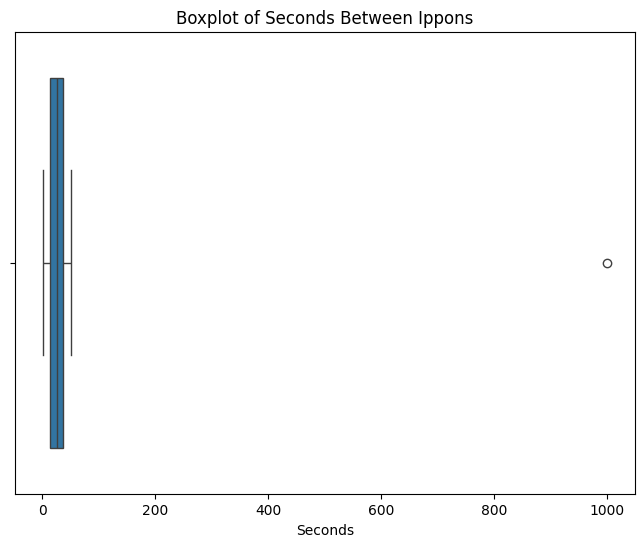

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot for the 'seconds_between' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['seconds_between'])
plt.title('Boxplot of Seconds Between Ippons')
plt.xlabel('Seconds')
plt.show()

In [263]:
# Padronização de tipos / mapeamento de valores
# Colunas esperadas
expected_cols = [
    "match_id", "ippon_number", "seconds_between", "ippon_taken",
    "men", "kote", "do", "tsuki"
]

# Verificar se todas existem (se faltar, acuse para evitar erro silencioso)
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Colunas ausentes no CSV: {missing}")

In [264]:
# Remover espaços em branco em strings
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str).str.strip()

In [265]:
# Mapeamento de strings comuns para binário
# (O/o -> 0, I/l/| -> 1, yes/true/y -> 1, no/false/n -> 0)
binary_map = {
    "o": 0, "O": 0, "0": 0, "no": 0, "false": 0, "n": 0,
    "i": 1, "I": 1, "l": 0, "|": 1, "1": 1, "yes": 1, "true": 1, "y": 1
}


In [266]:
bin_cols = ["men", "kote", "do", "tsuki", "ippon_taken"]

for col in bin_cols:
    # aplica mapeamento em valores de texto conhecidos
    df[col] = df[col].replace(binary_map)
    # converte para numérico (coerce -> valores inválidos viram NaN)
    df[col] = pd.to_numeric(df[col], errors="coerce")

/tmp/ipython-input-3103012044.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(binary_map)


In [267]:
# Convert all columns to numeric first, coercing errors to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Now convert to Int64, which can handle NaNs
for col in df.columns:
    df[col] = df[col].astype('Int64')

In [268]:
# Validar campos binários (0/1)
# Qualquer valor que não seja 0 ou 1 nas colunas binárias será considerado erro -> NaN
for col in bin_cols:
    df.loc[~df[col].isin([0, 1]), col] = np.nan

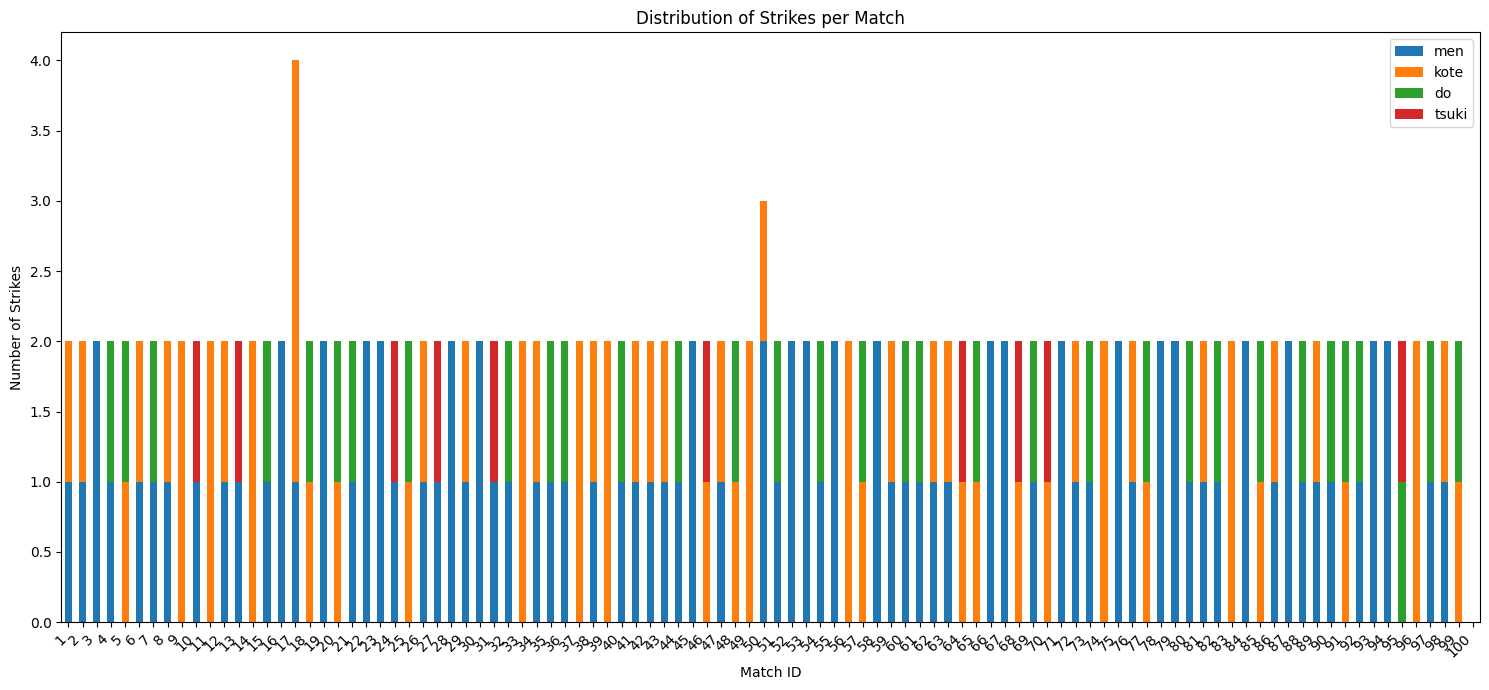

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by match_id and sum the strike counts
strike_summary = df.groupby('match_id')[['men', 'kote', 'do', 'tsuki']].sum()

# Create a stacked bar plot
strike_summary.plot(kind='bar', stacked=True, figsize=(15, 7))

plt.title('Distribution of Strikes per Match')
plt.xlabel('Match ID')
plt.ylabel('Number of Strikes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [270]:
# Dropar linhas que possuem seconds_between maiores que 300s (tempo de partida)
before_drop = df.shape[0]
df = df[df['seconds_between'] <= 300].copy()
after_drop = df.shape[0]

print(f"Número de linhas antes de remover: {before_drop}")
print(f"Número de linhas depois de remover: {after_drop}")

Número de linhas antes de remover: 202
Número de linhas depois de remover: 201


In [271]:
# Retirar partidas que não possuem valor verdadeiro nos golpes
# Criar uma máscara para identificar linhas onde a soma das colunas de golpe é 0 (ou NaN)
strike_cols = ["men", "kote", "do", "tsuki"]
# Check if the sum of strikes is 0 or NaN (assuming 1 for a valid strike)
mask_no_strike = (df[strike_cols].sum(axis=1) == 0) | (df[strike_cols].sum(axis=1).isna())

# Get the number of rows before dropping
before_drop = df.shape[0]

# Drop the rows where the mask is True
df = df[~mask_no_strike].copy()

# Get the number of rows after dropping
after_drop = df.shape[0]

print(f"Número de linhas antes de remover: {before_drop}")
print(f"Número de linhas depois de remover: {after_drop}")

display(df.head())

Número de linhas antes de remover: 201
Número de linhas depois de remover: 199


,match_id,ippon_number,seconds_between,ippon_taken,men,kote,do,tsuki
0,1,1,1,0,1,0,0,0
1,1,2,5,1,0,1,0,0
2,2,1,10,0,0,1,0,0
3,2,2,48,0,1,0,0,0
4,3,1,38,0,1,0,0,0


/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


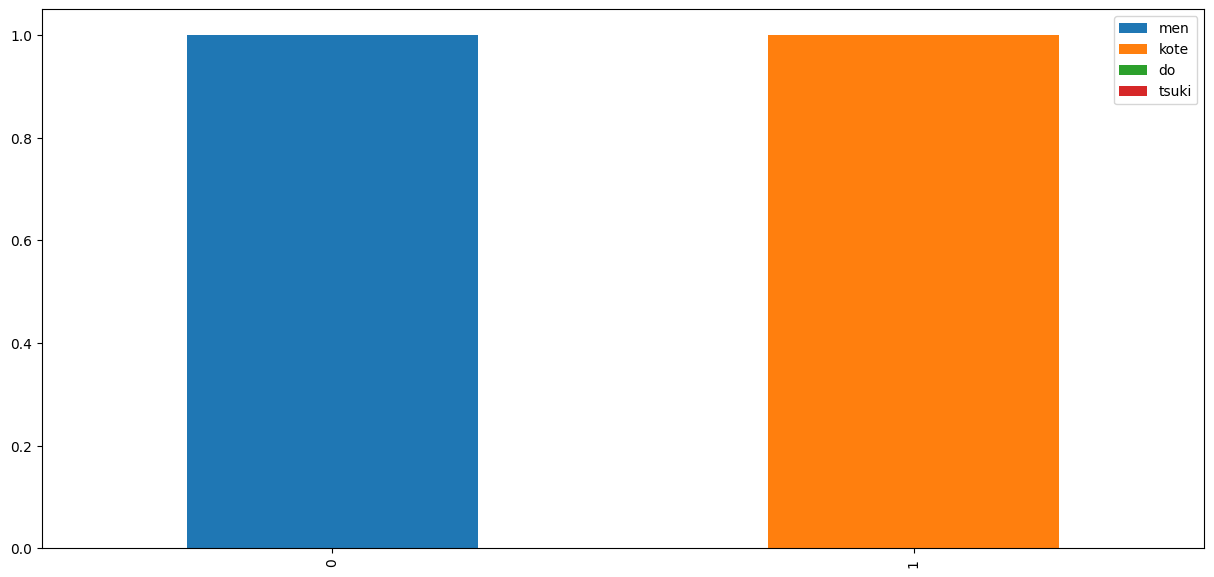

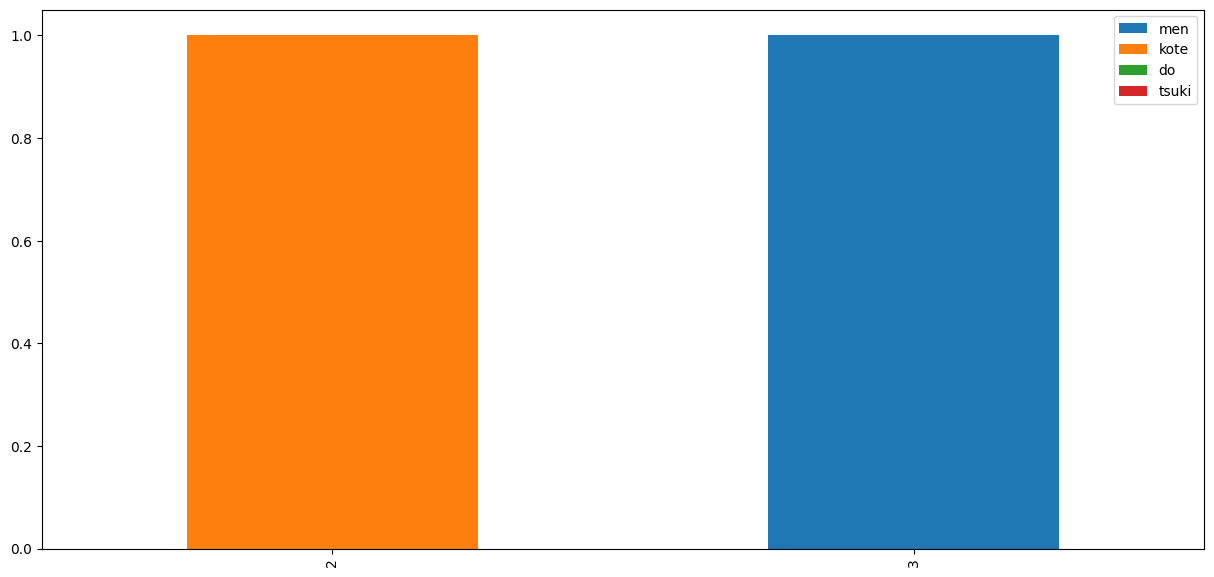

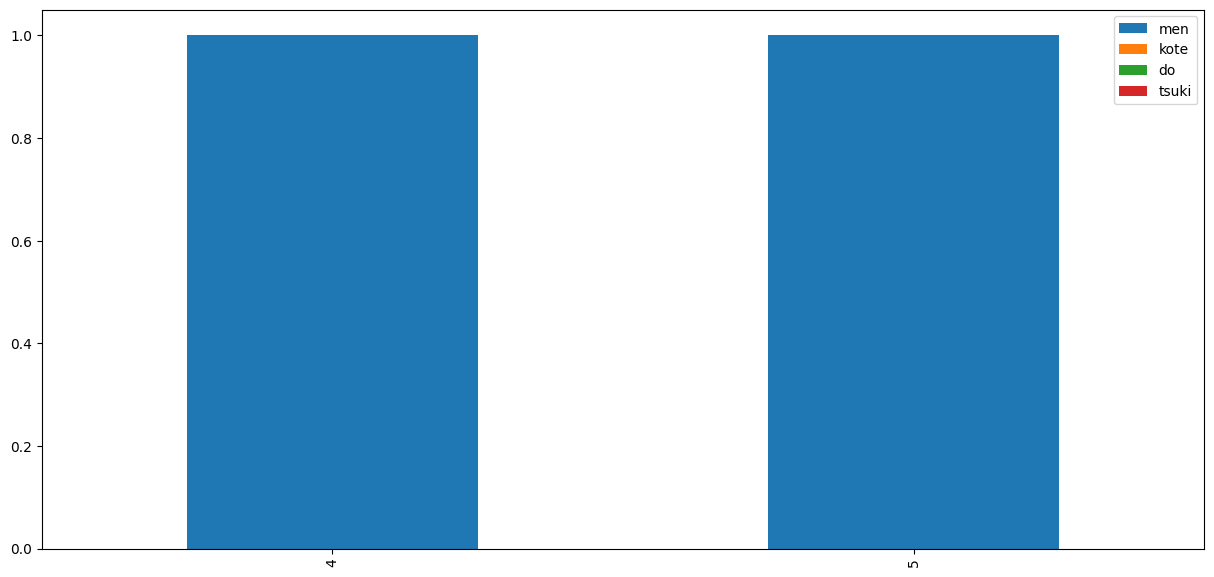

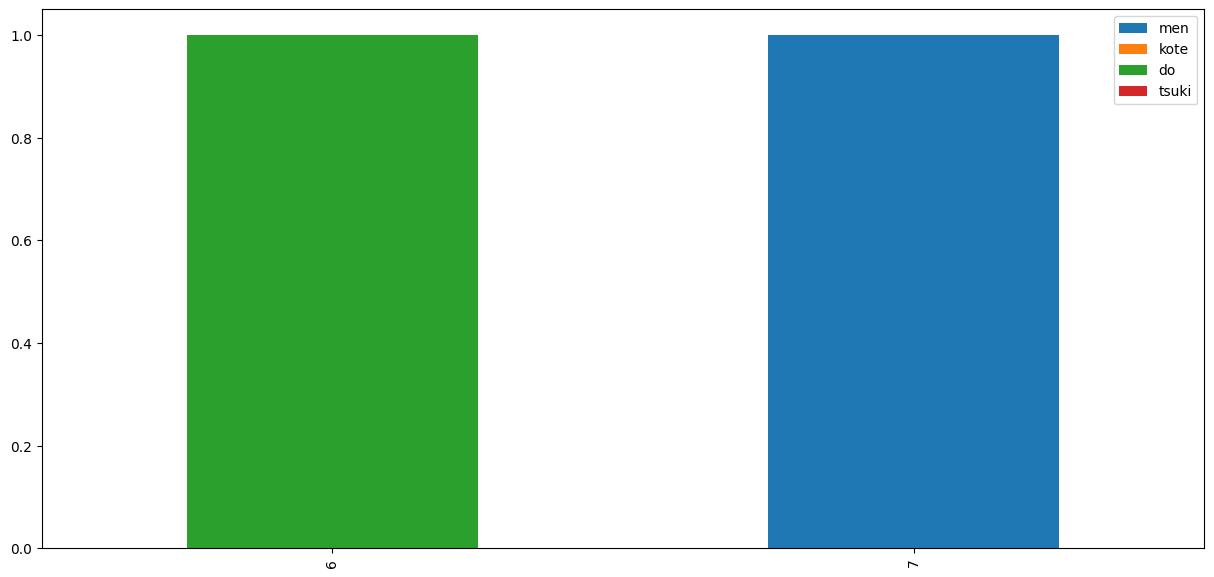

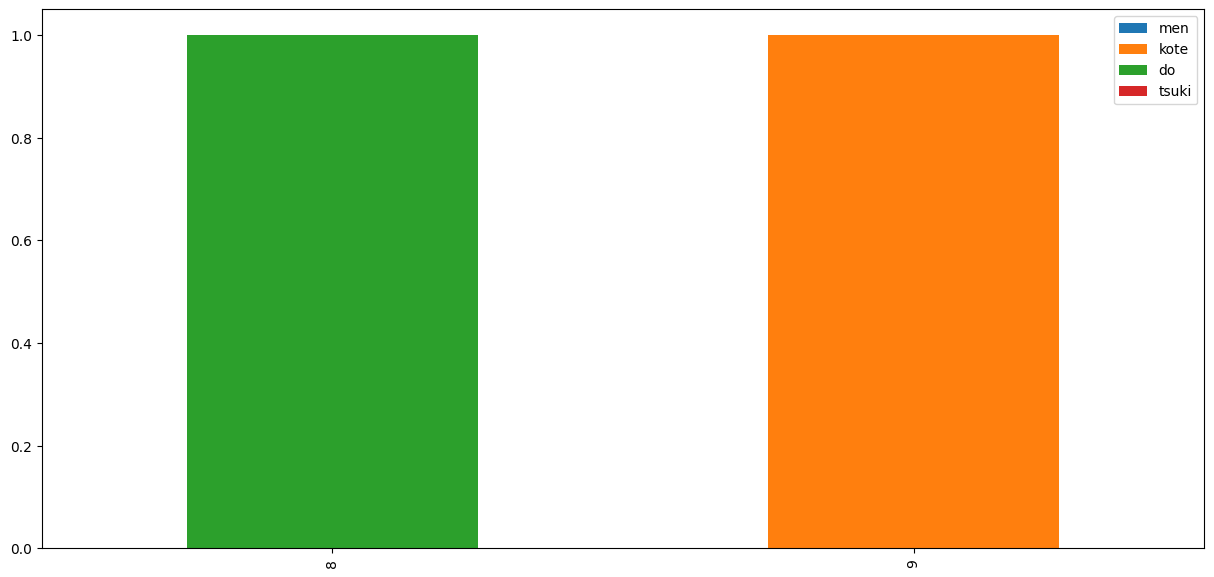

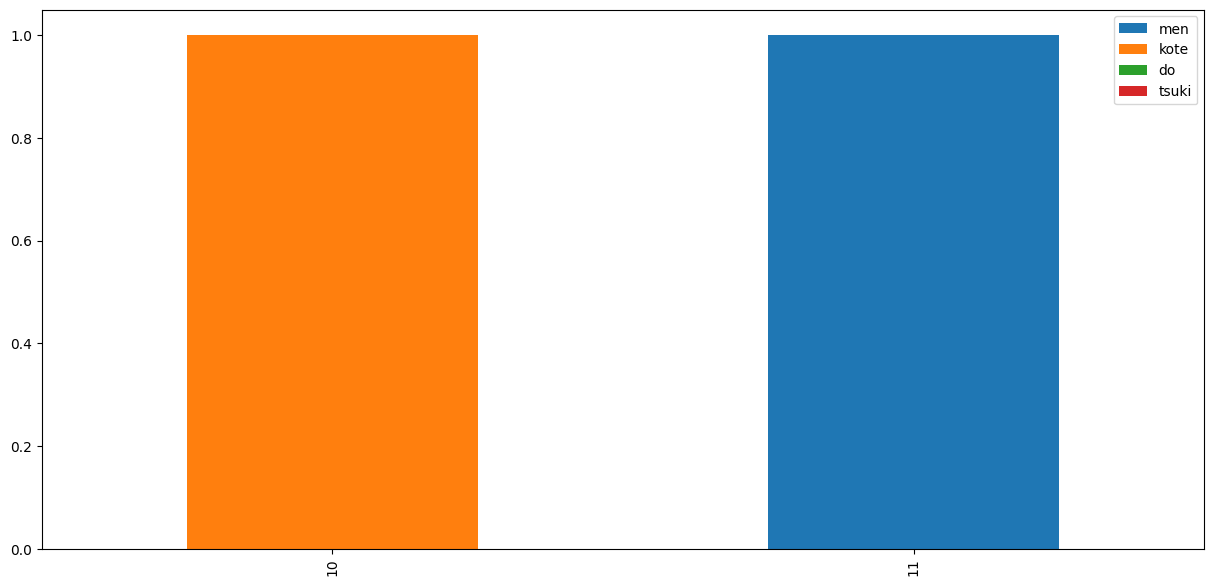

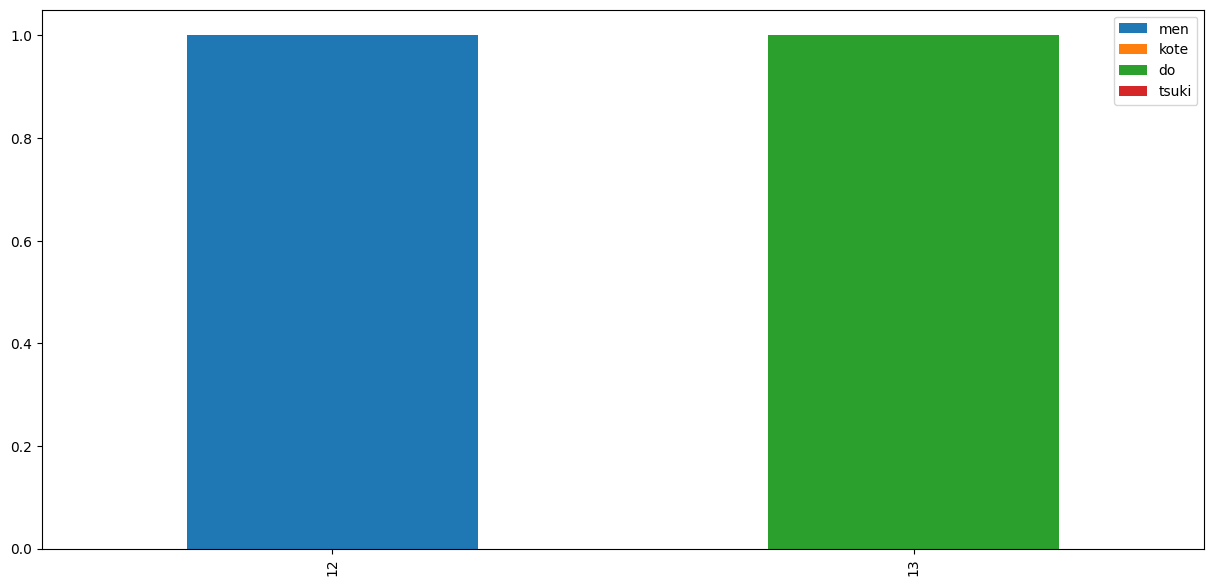

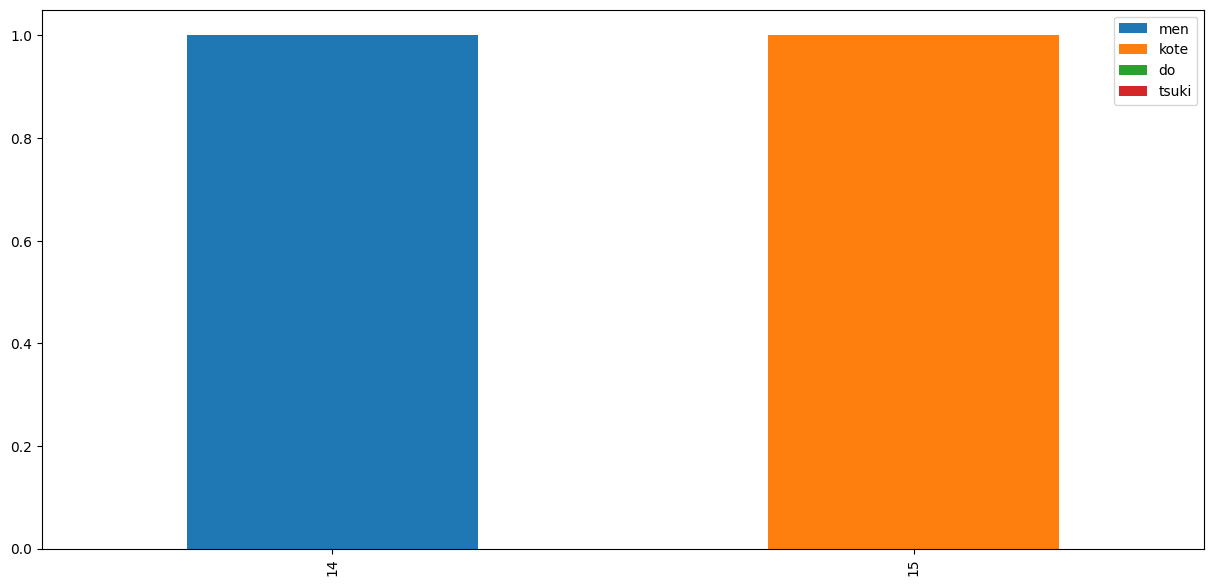

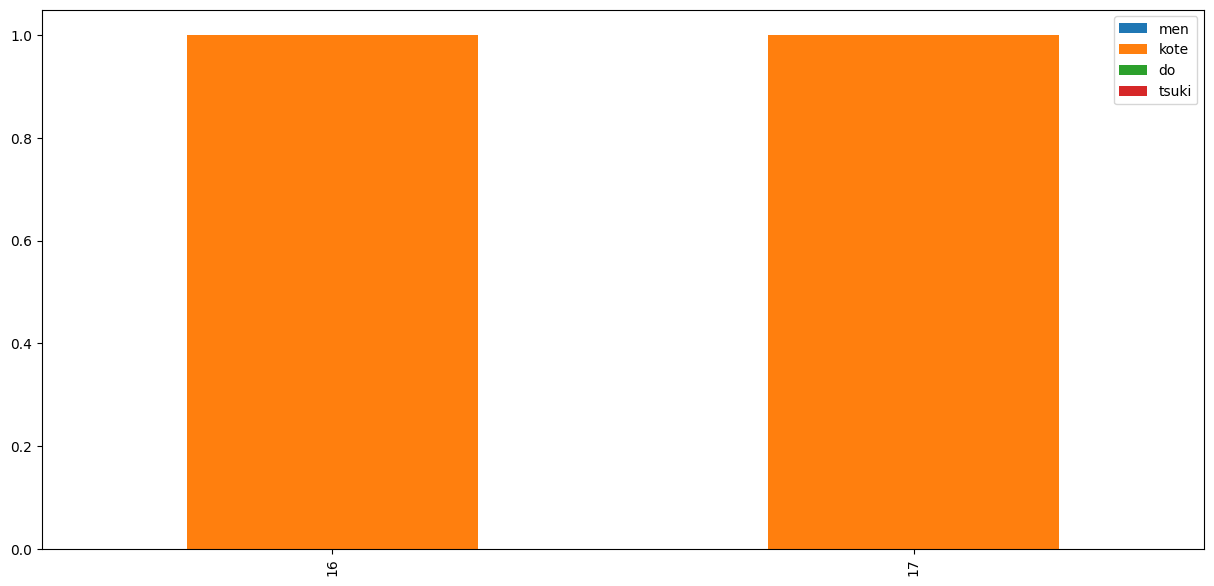

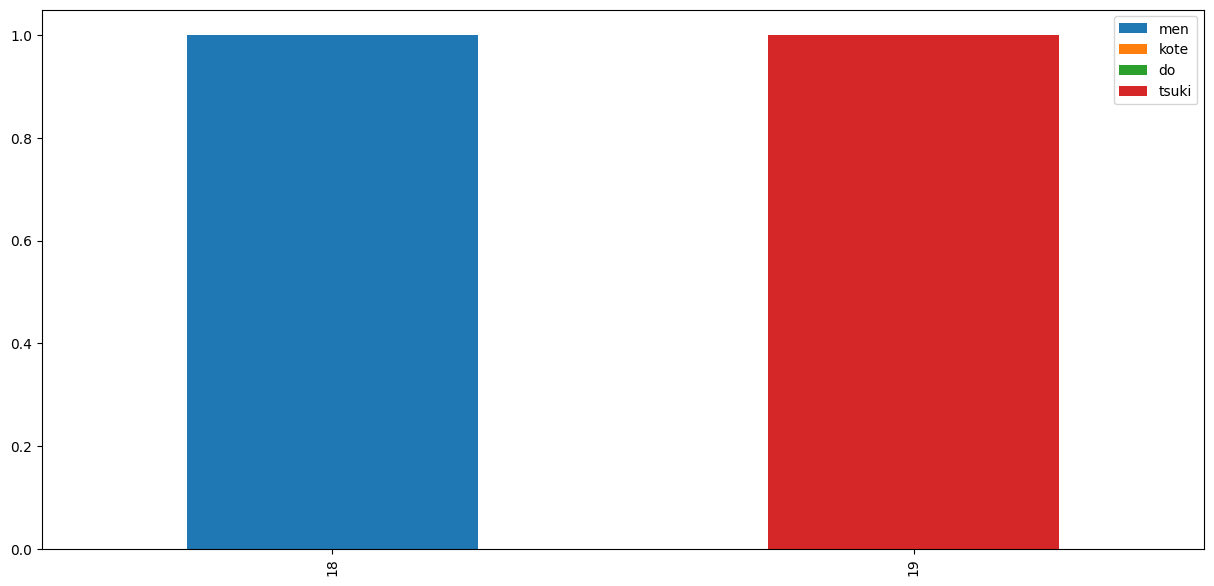

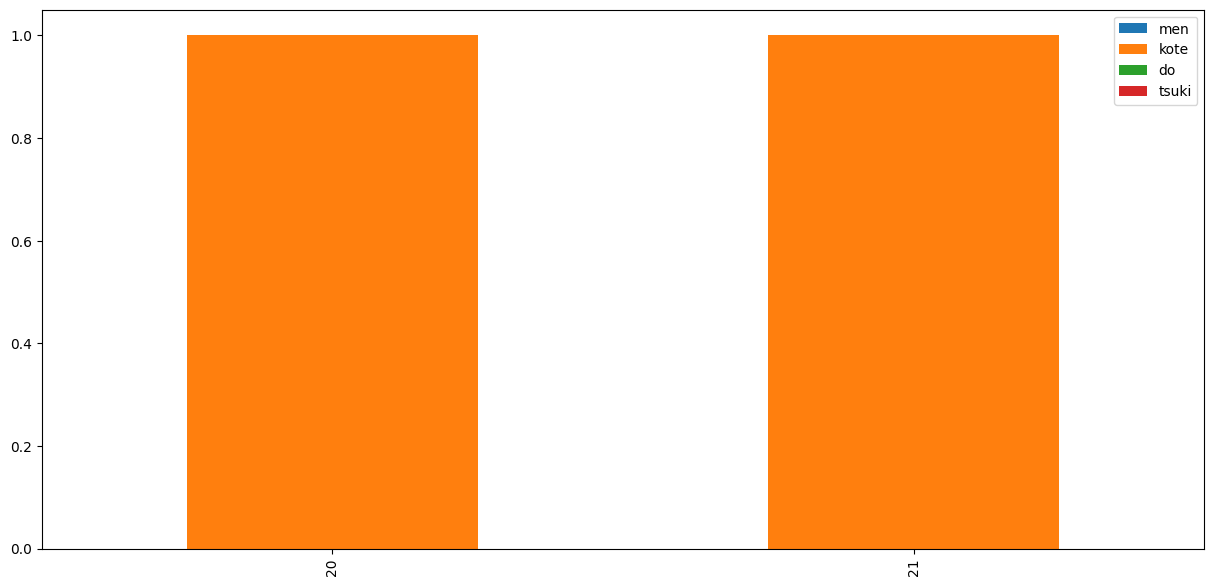

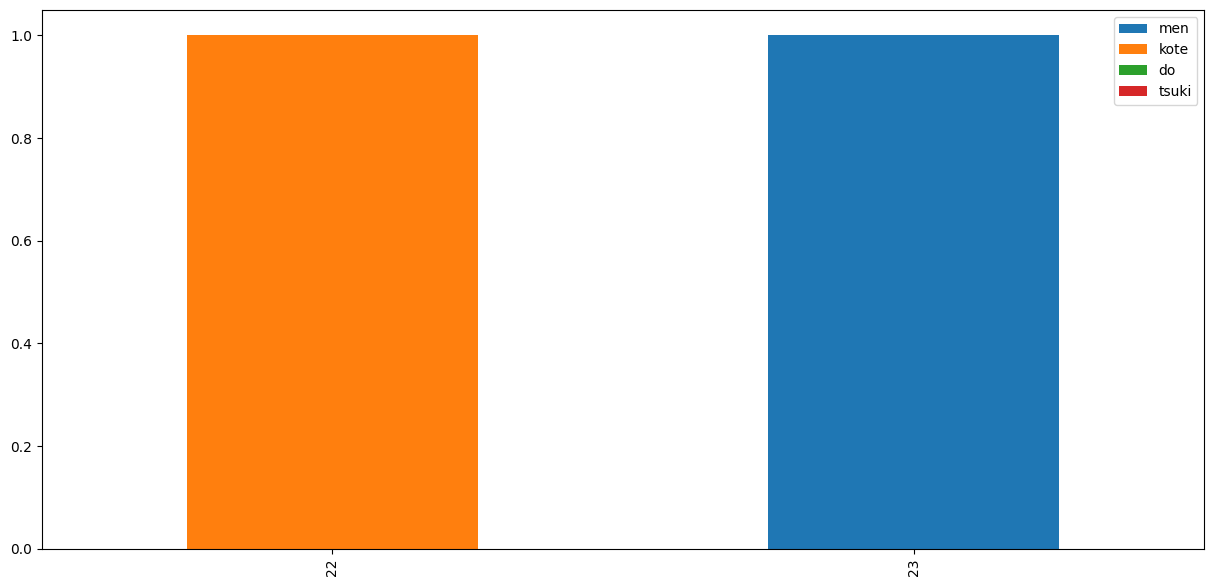

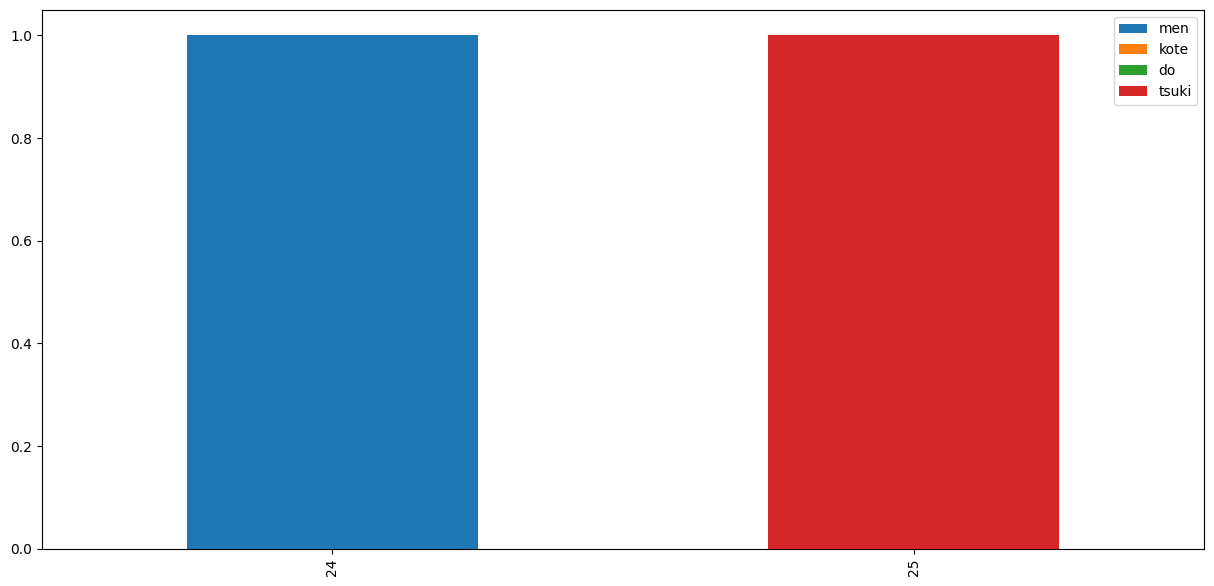

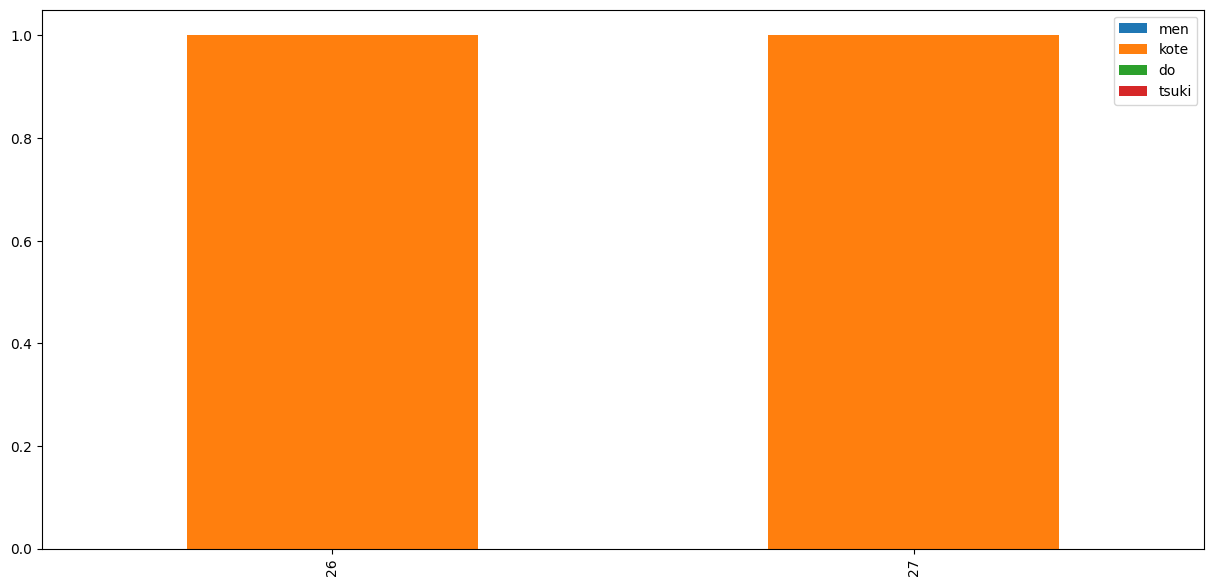

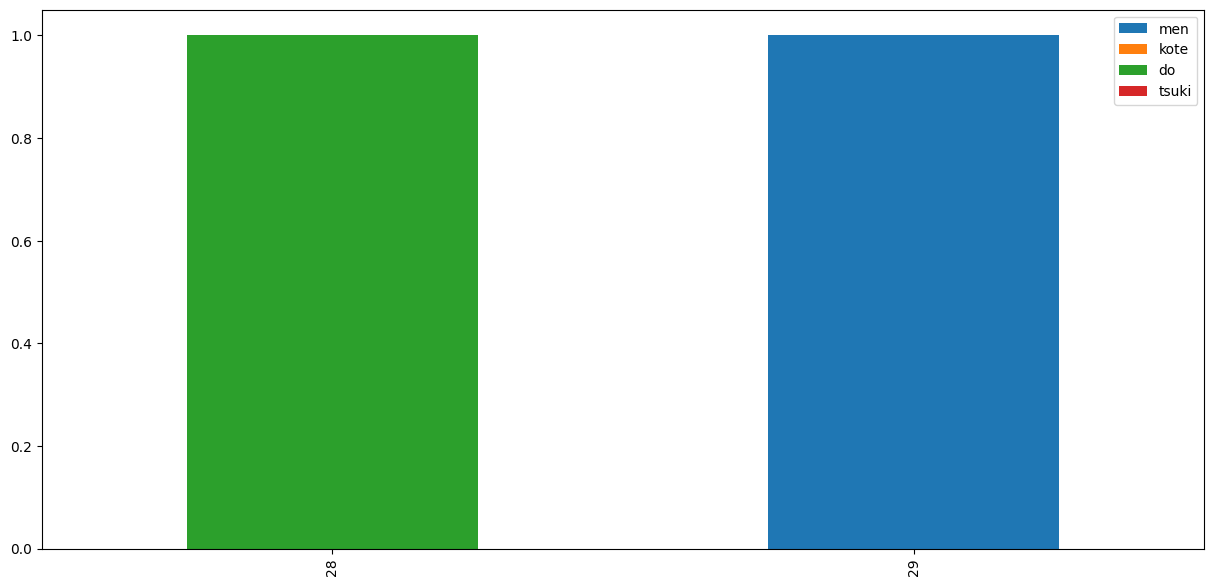

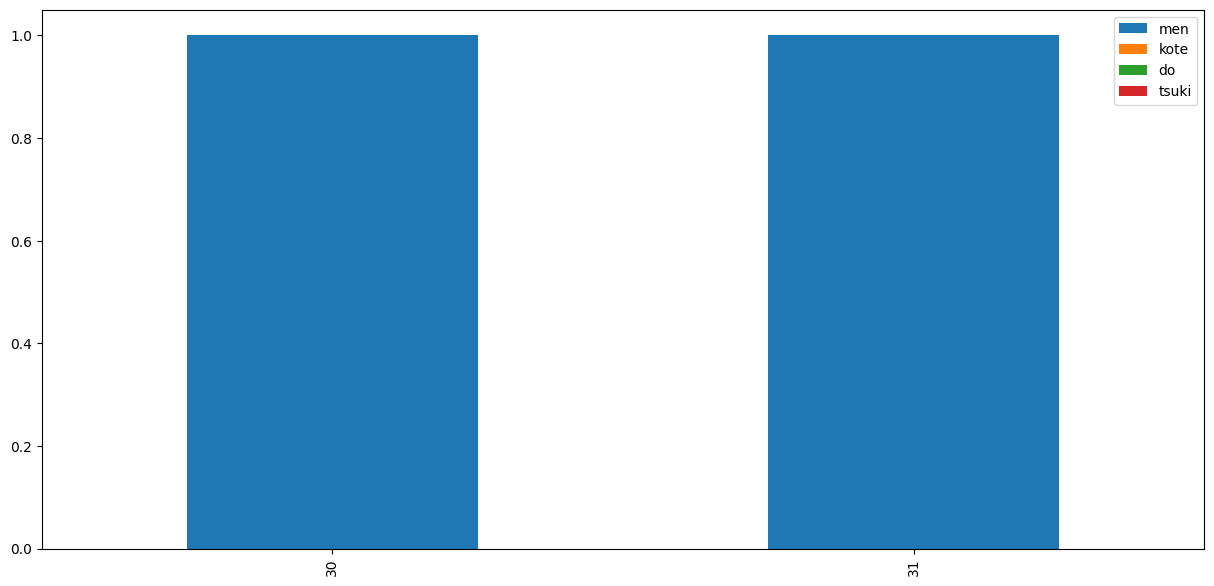

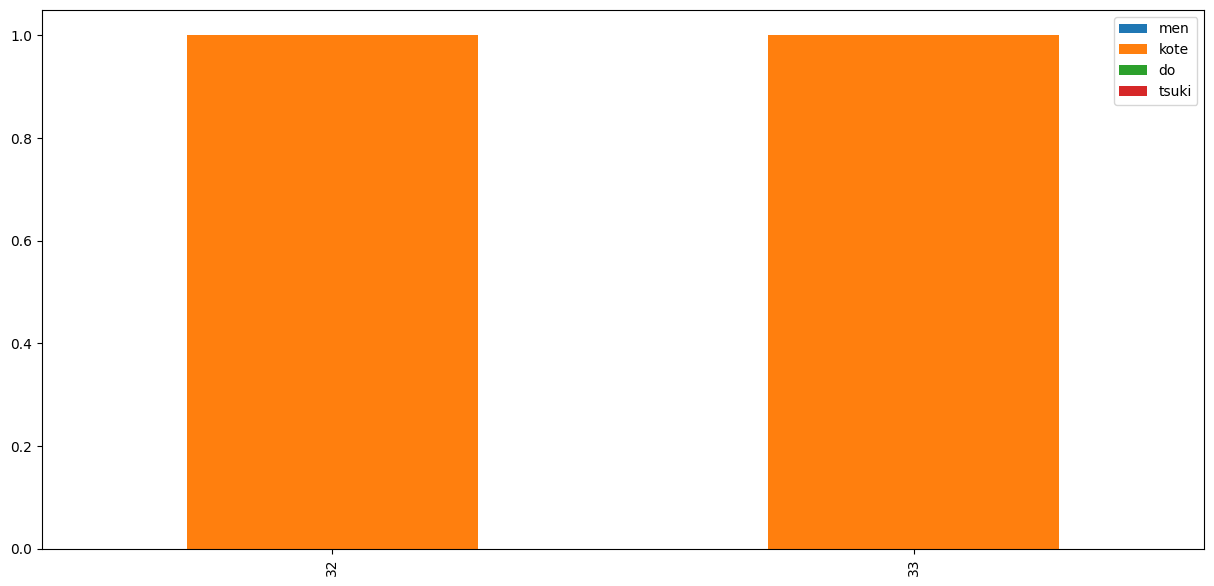

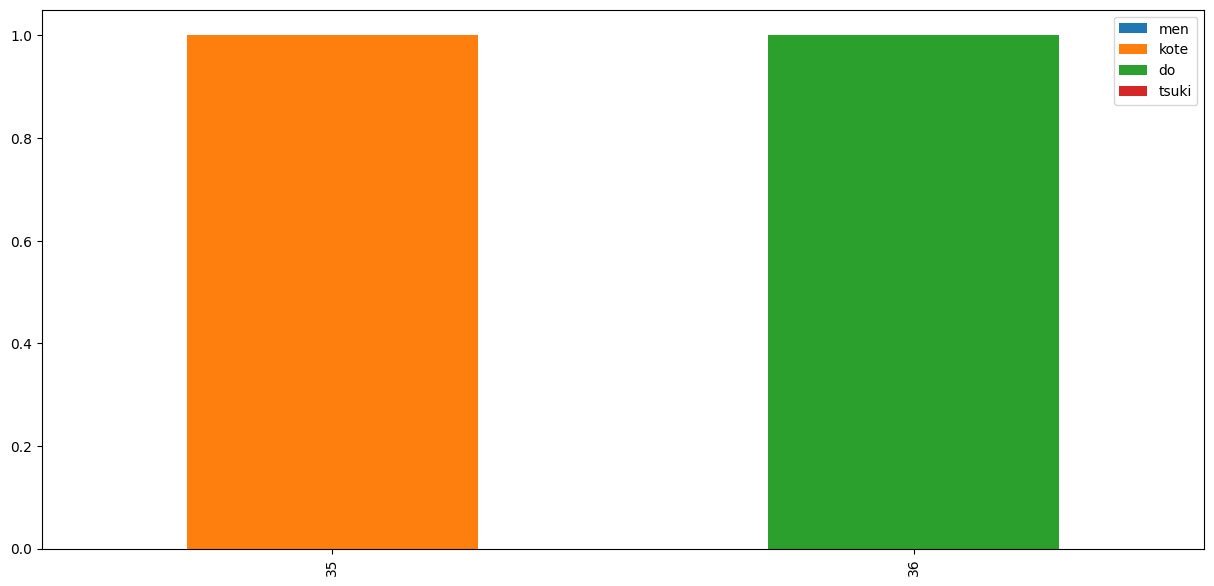

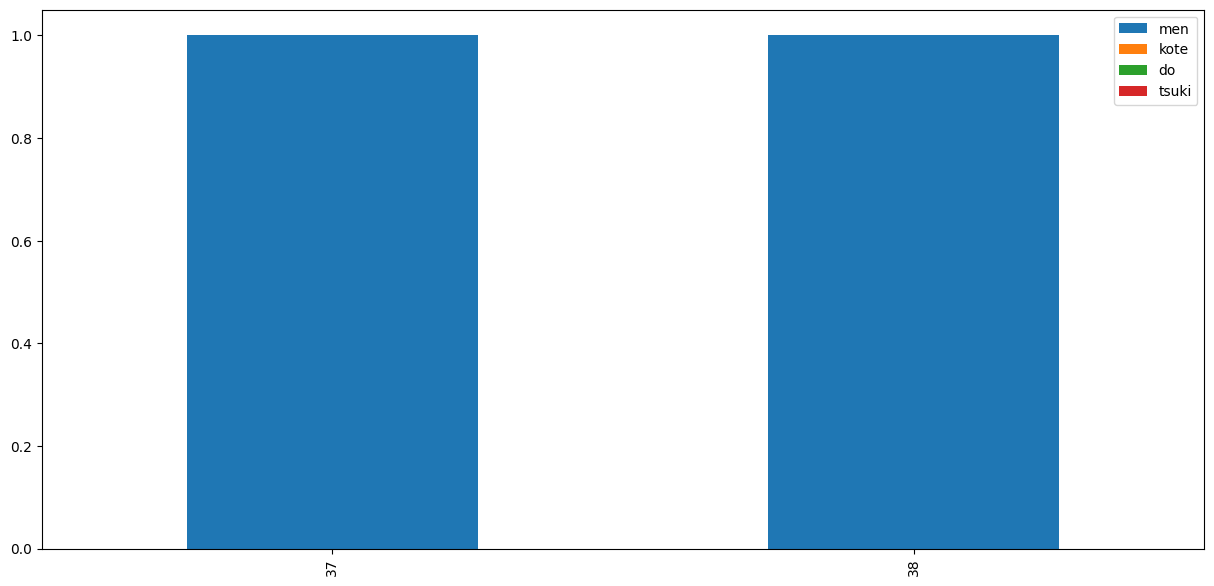

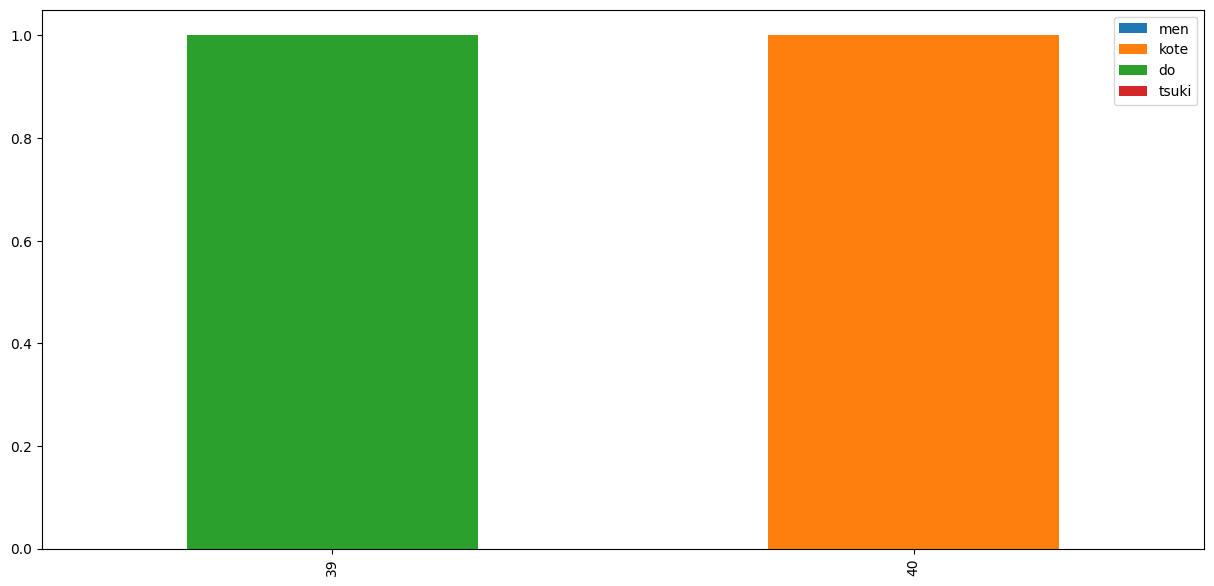

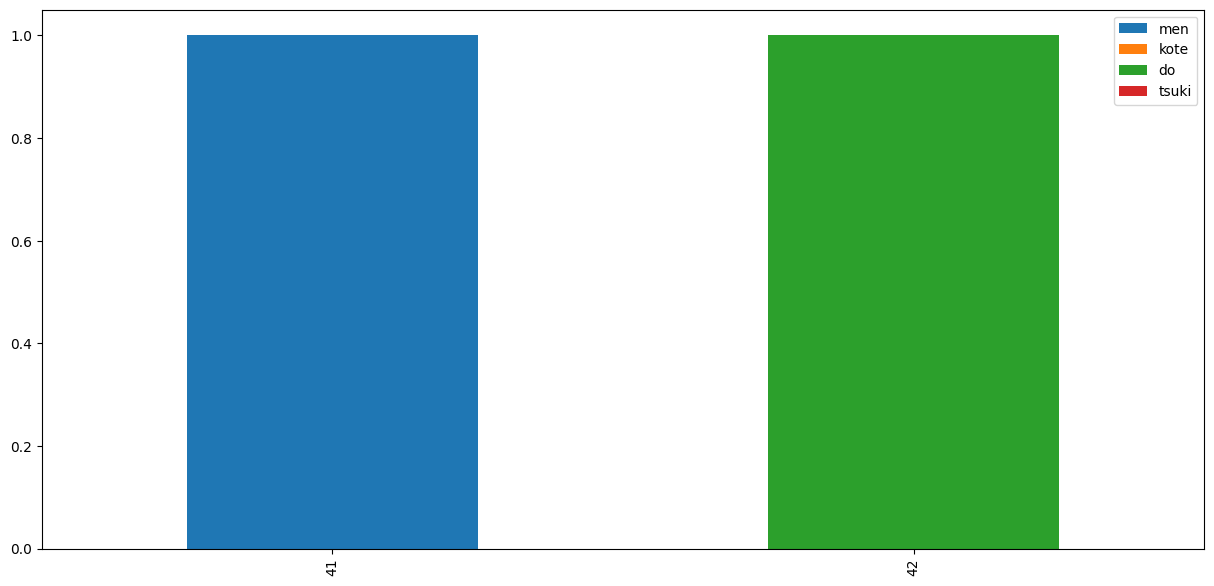

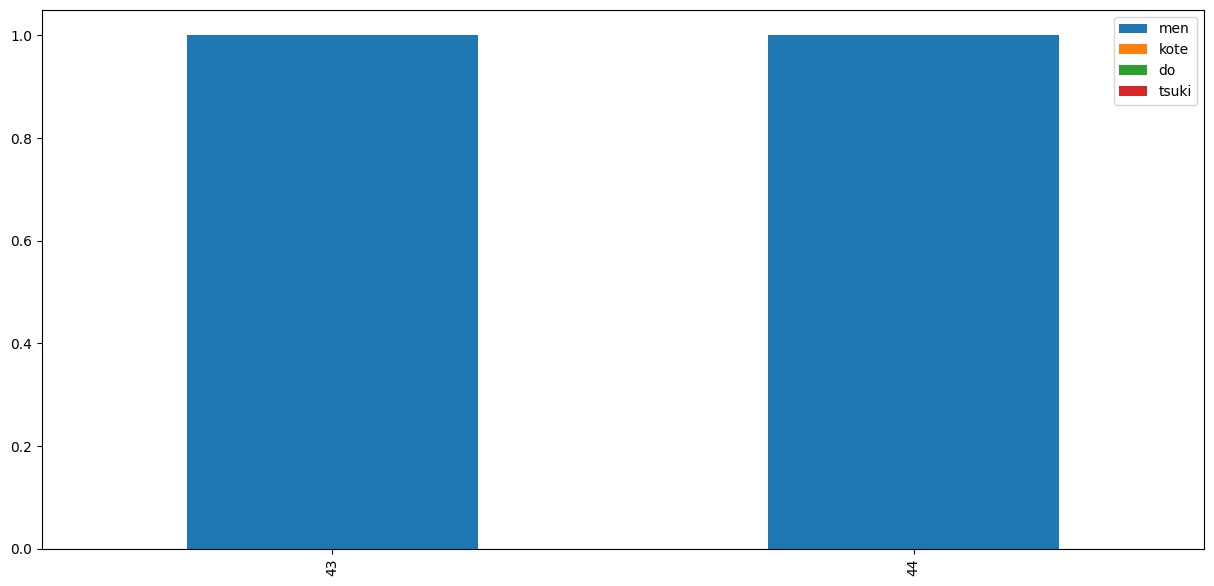

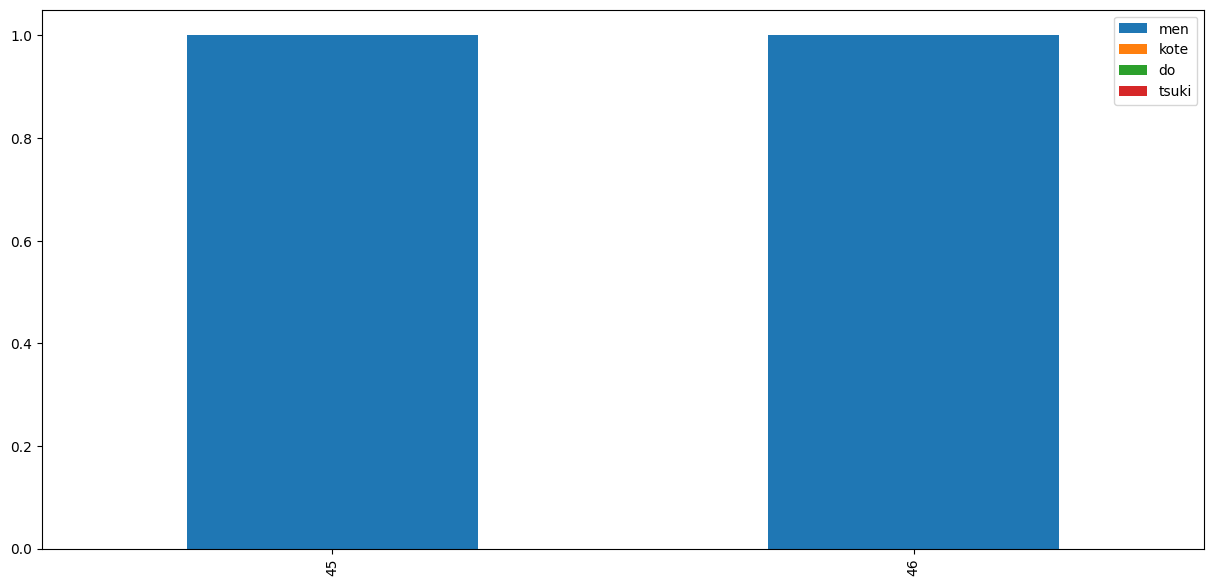

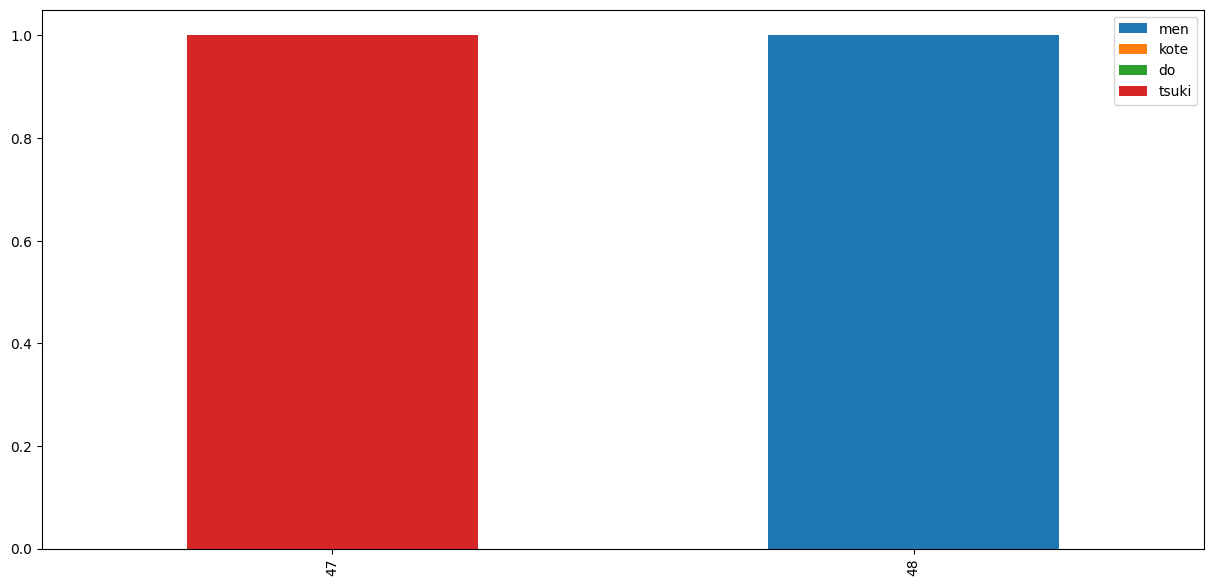

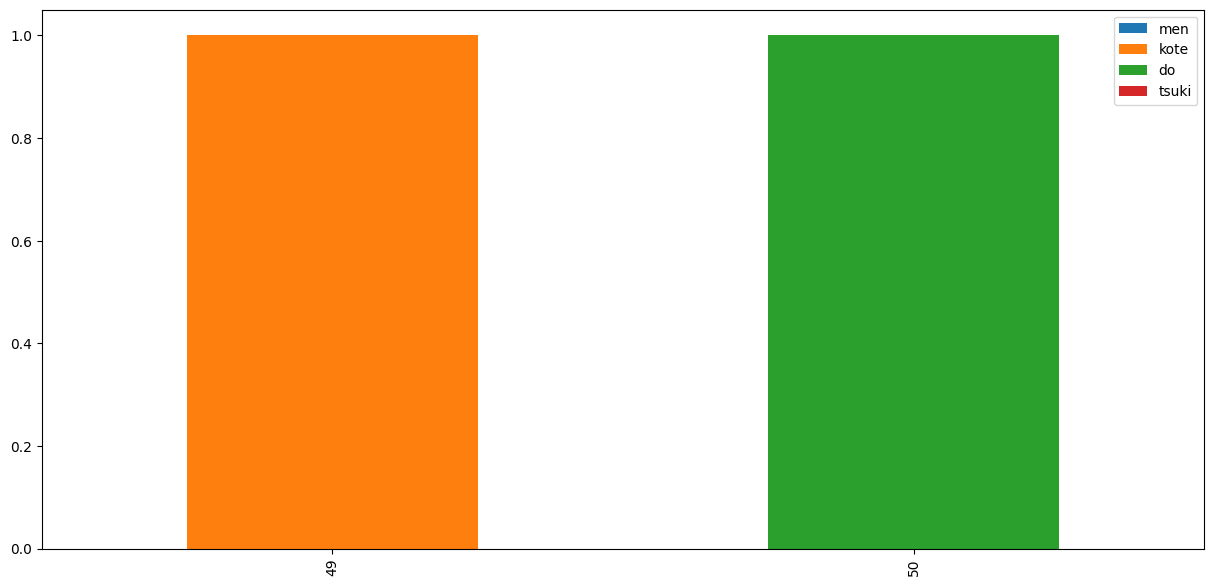

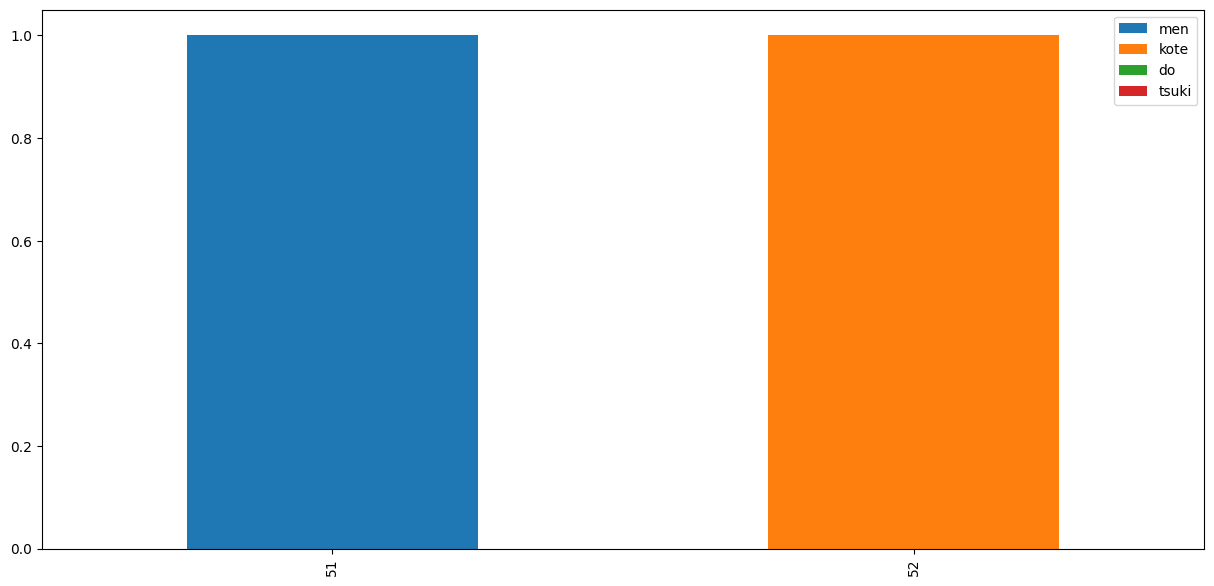

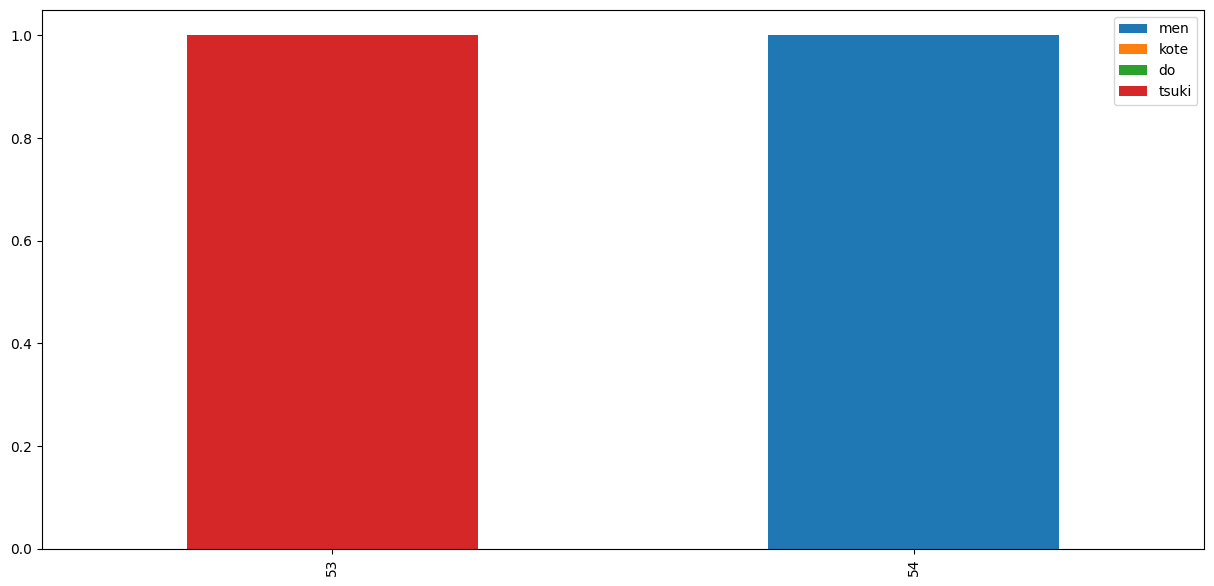

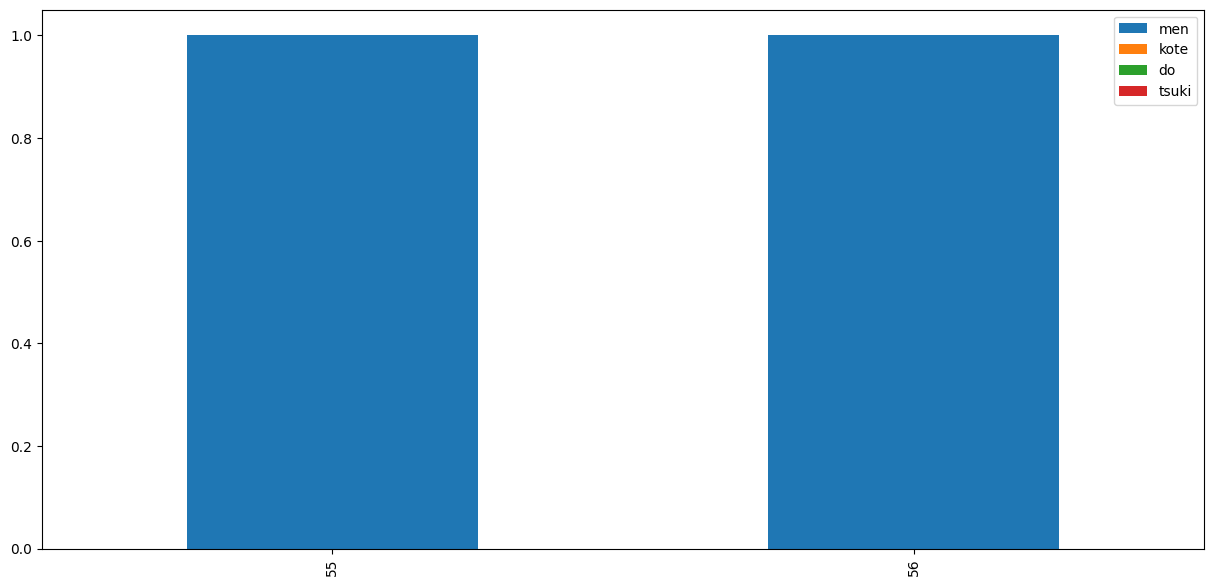

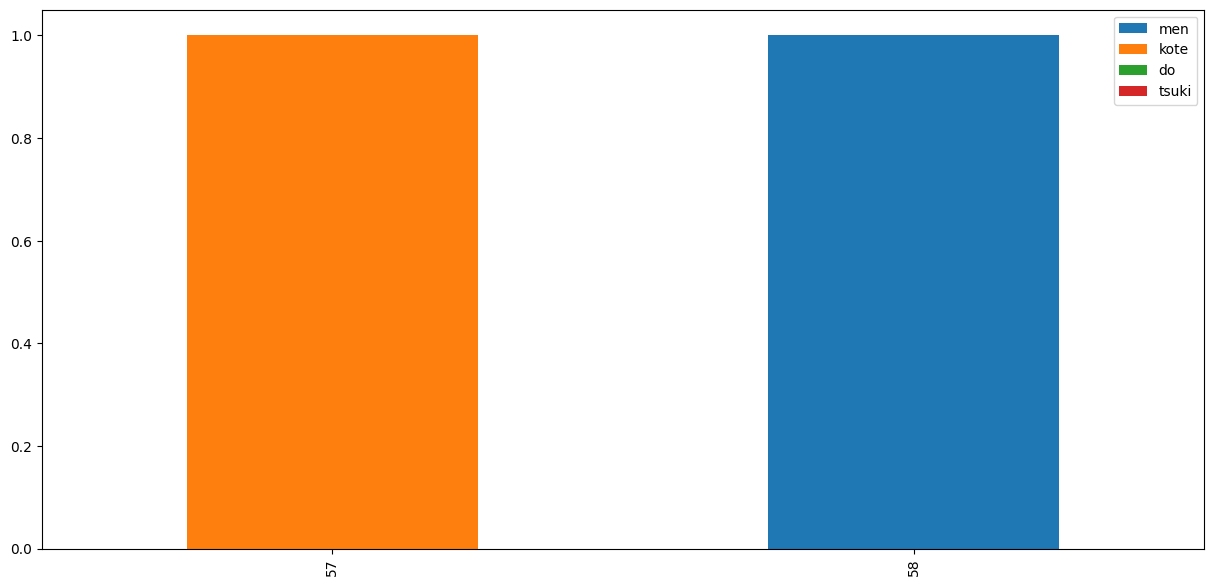

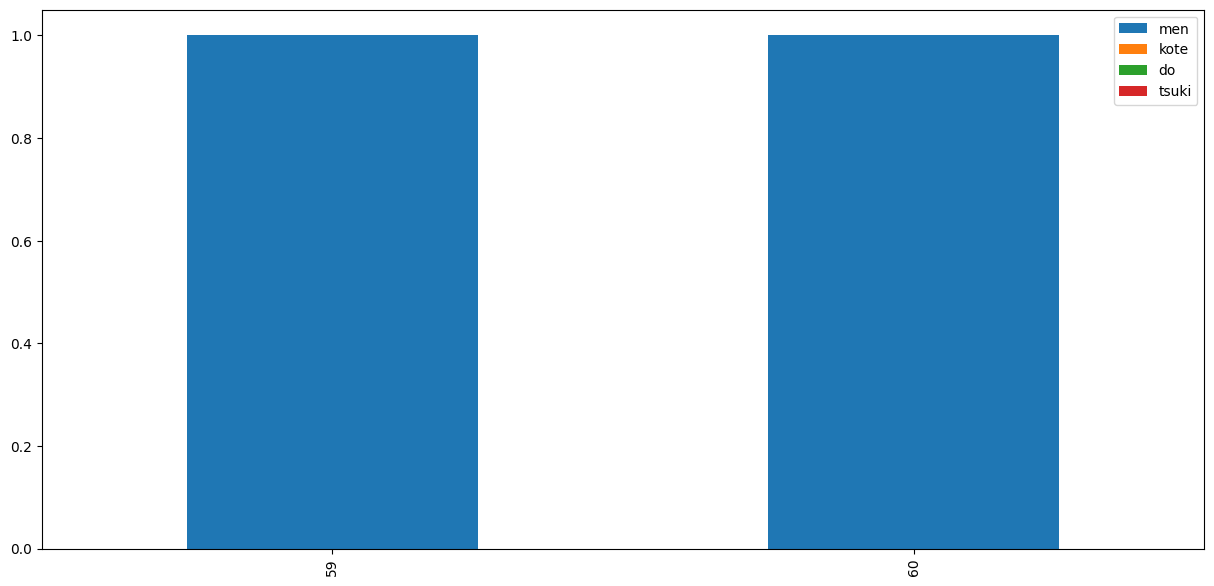

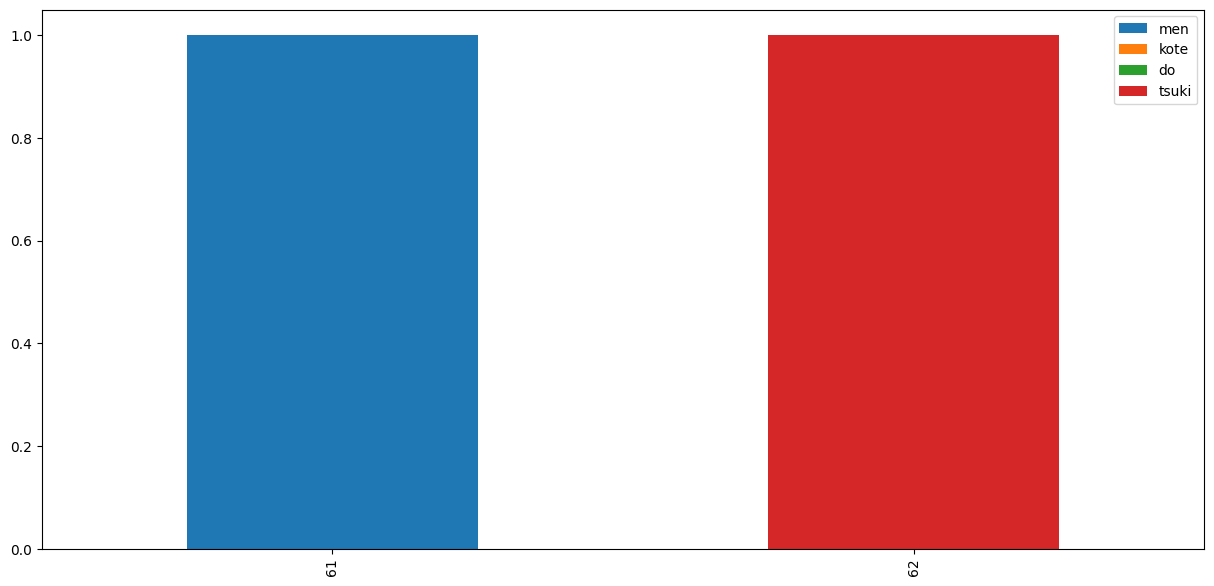

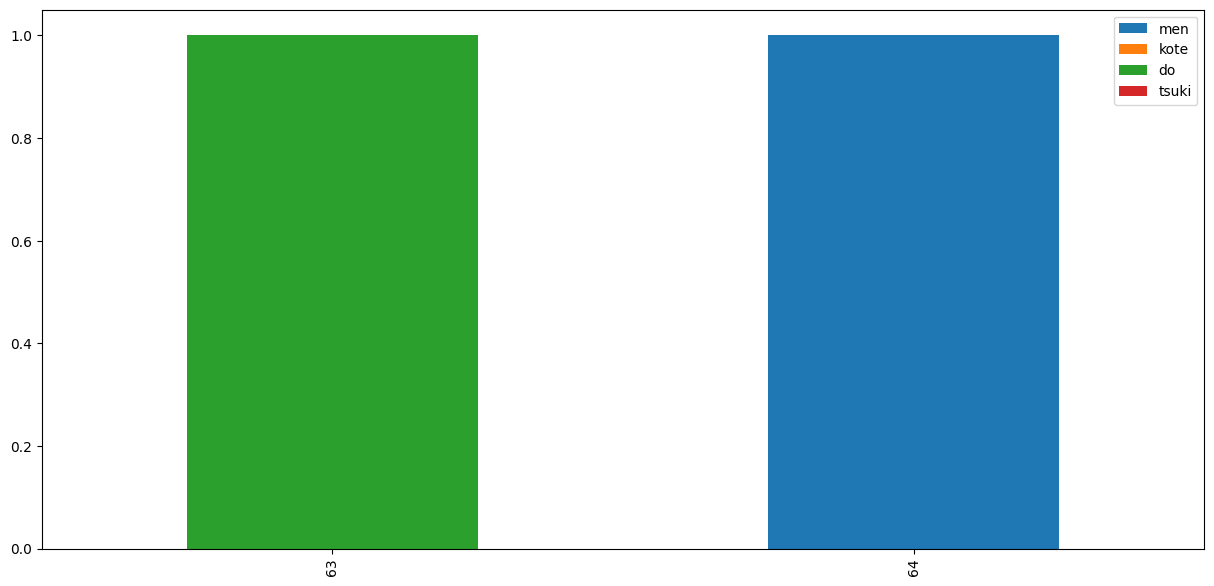

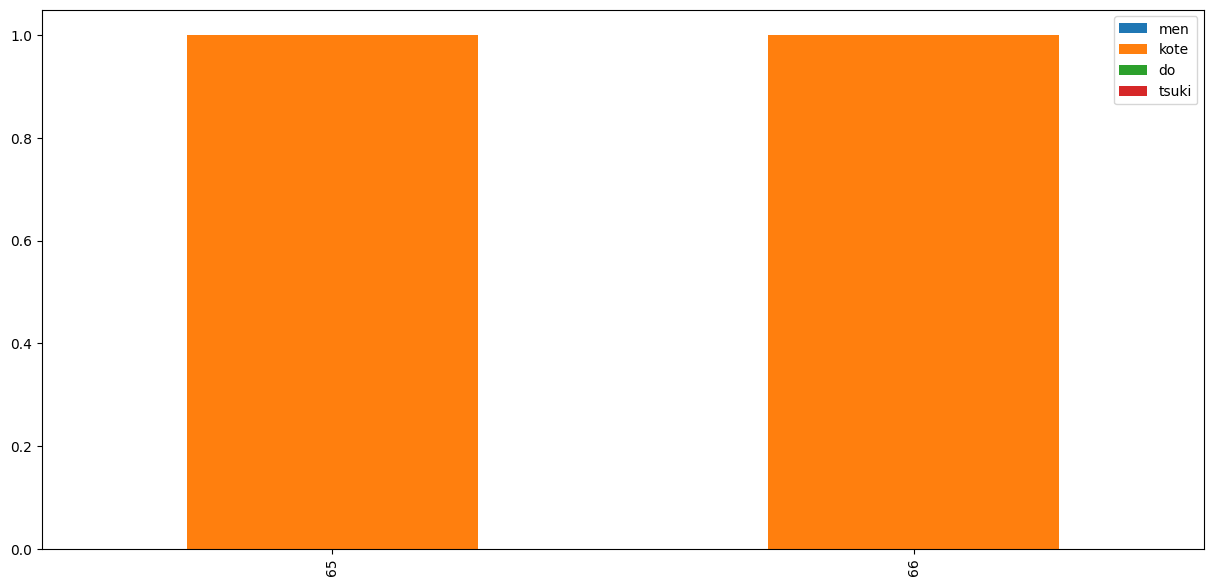

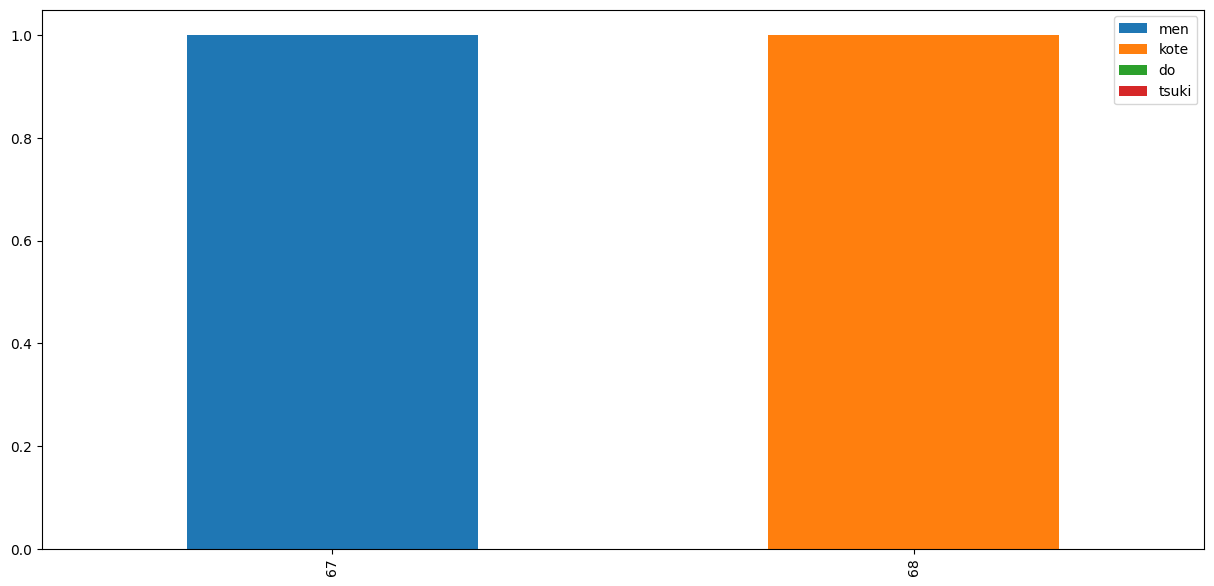

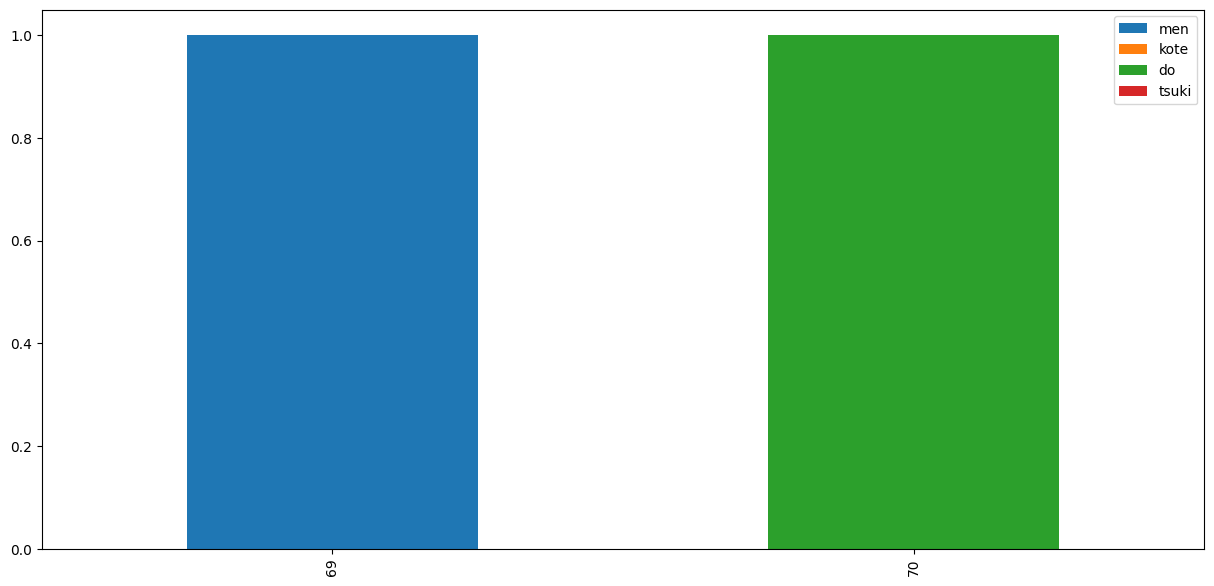

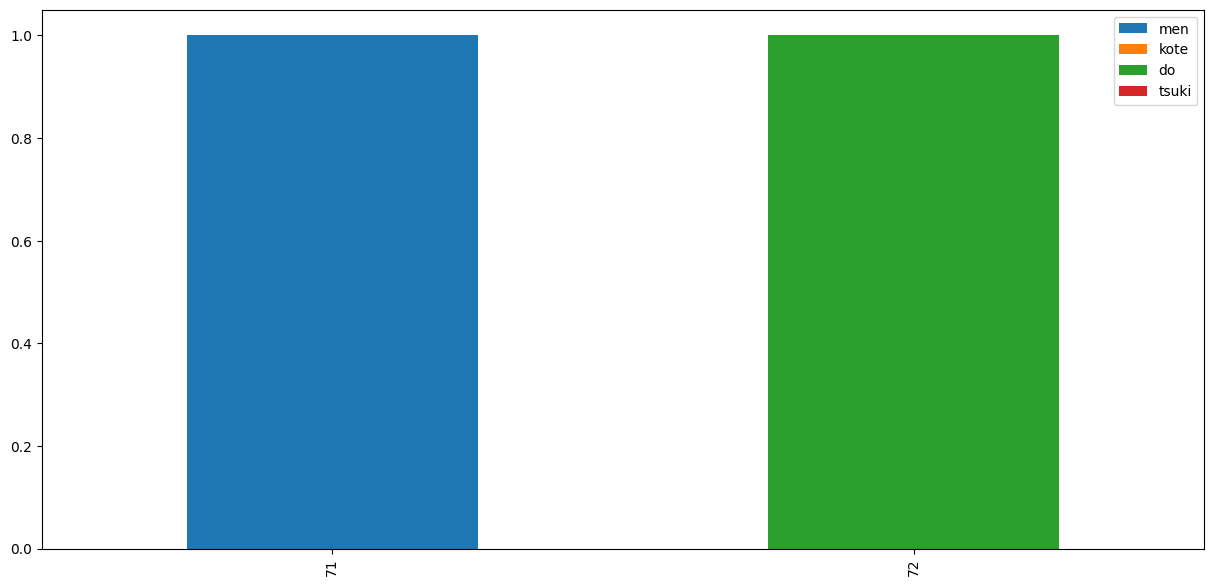

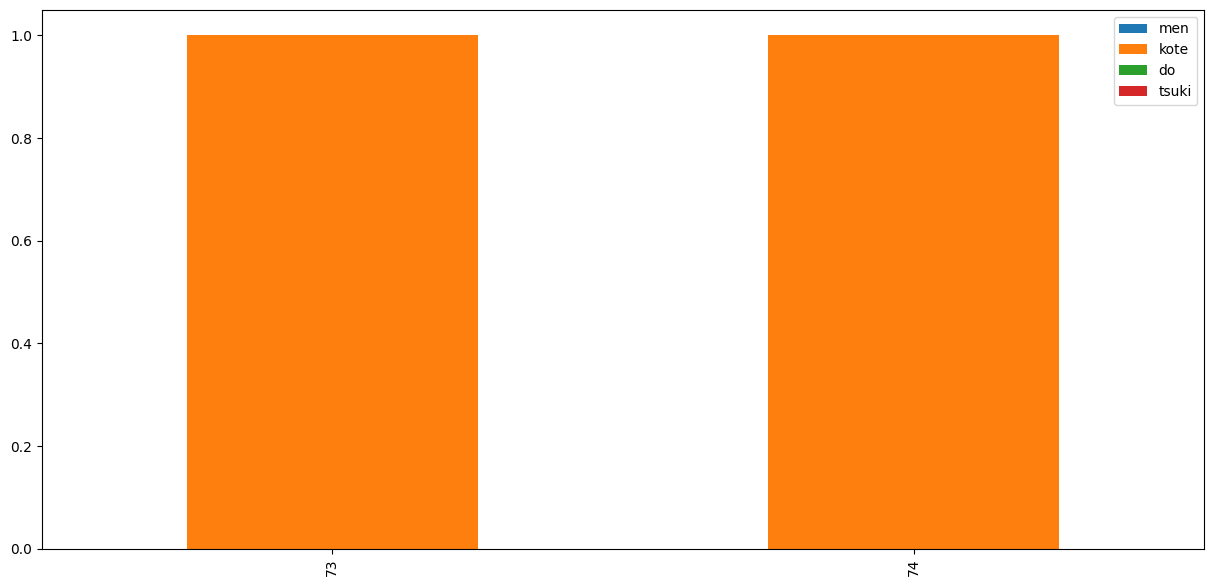

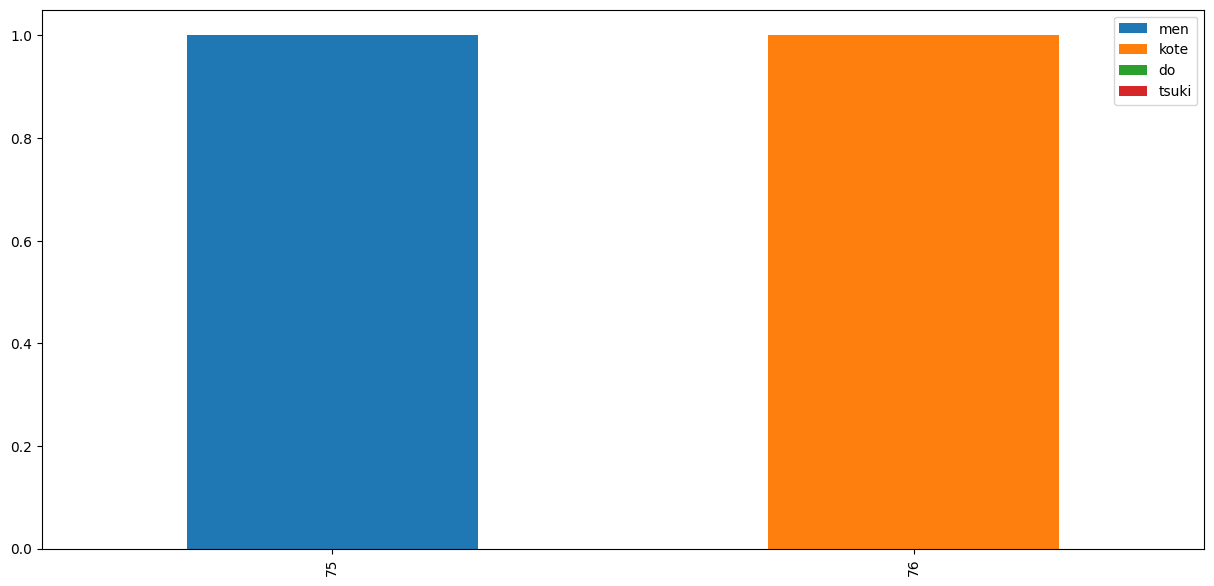

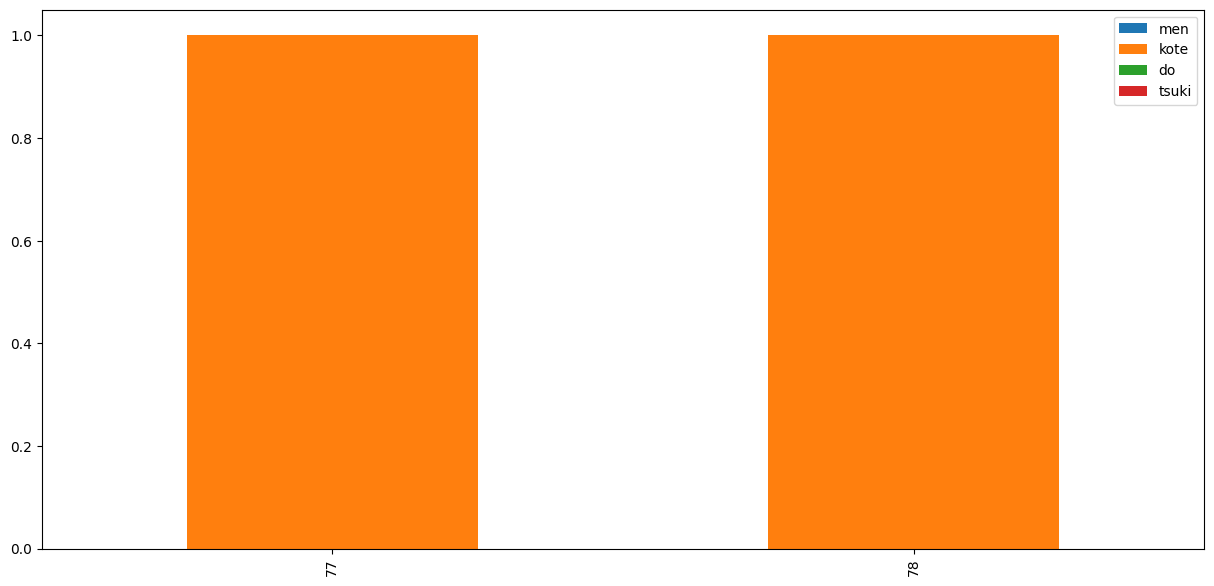

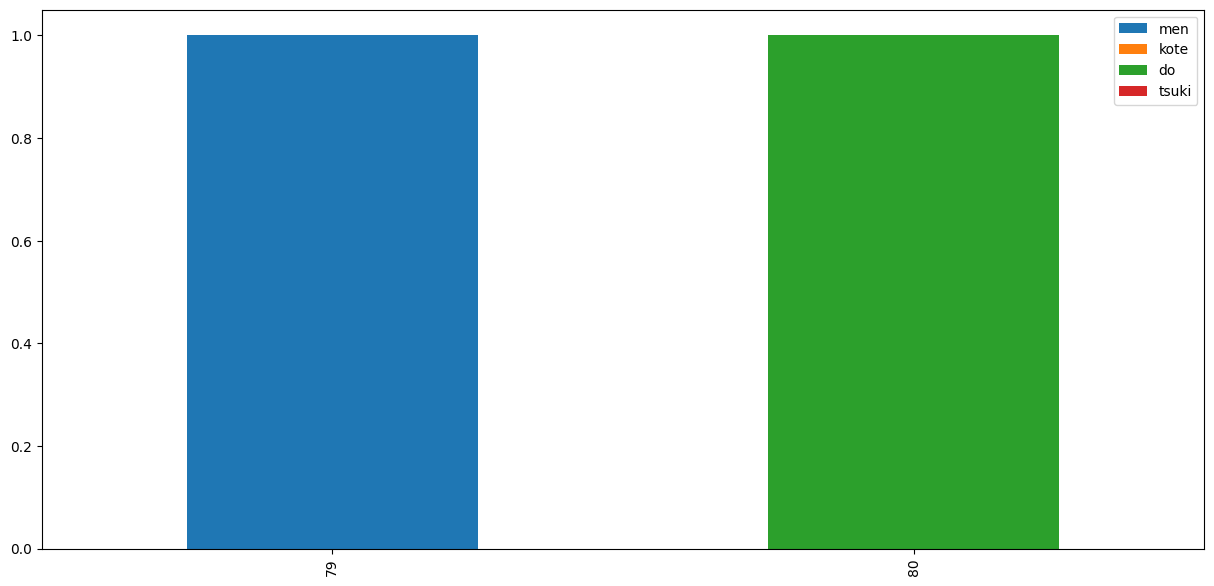

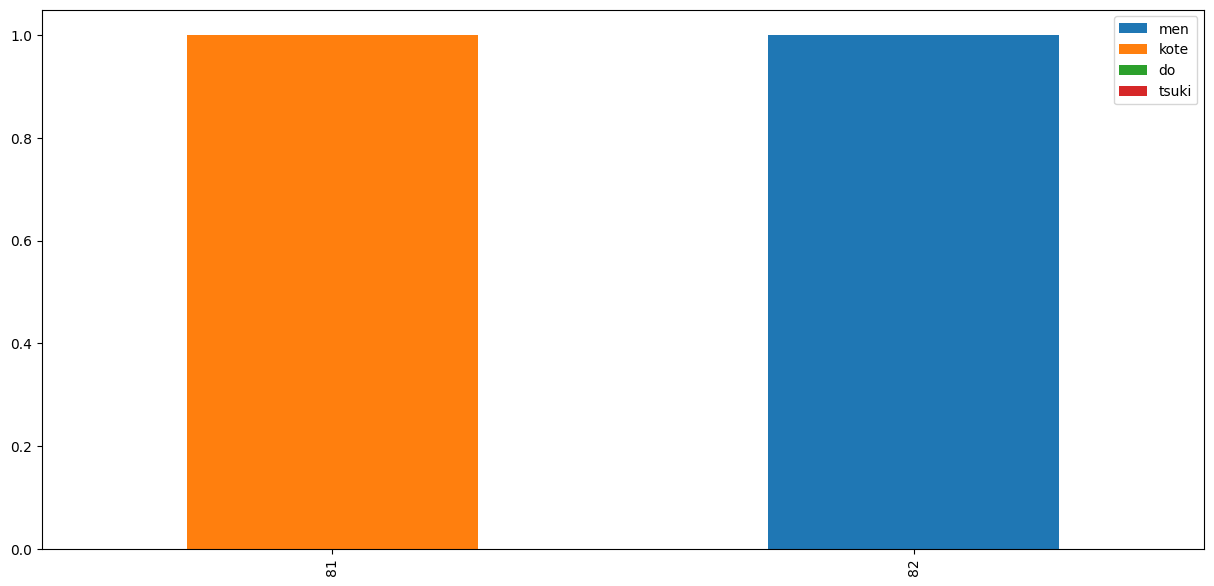

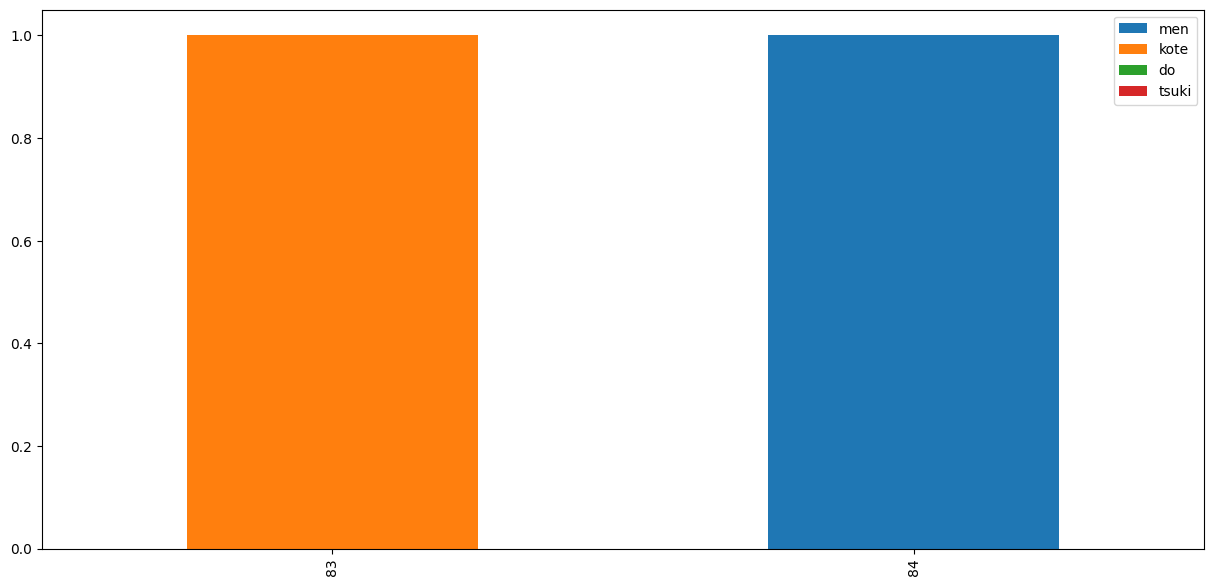

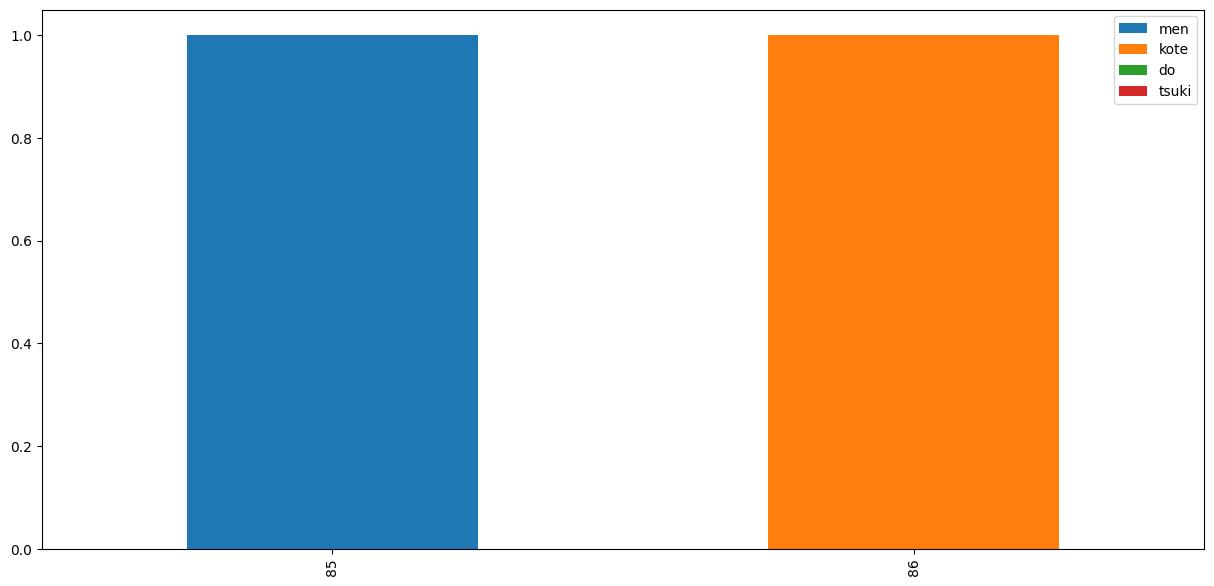

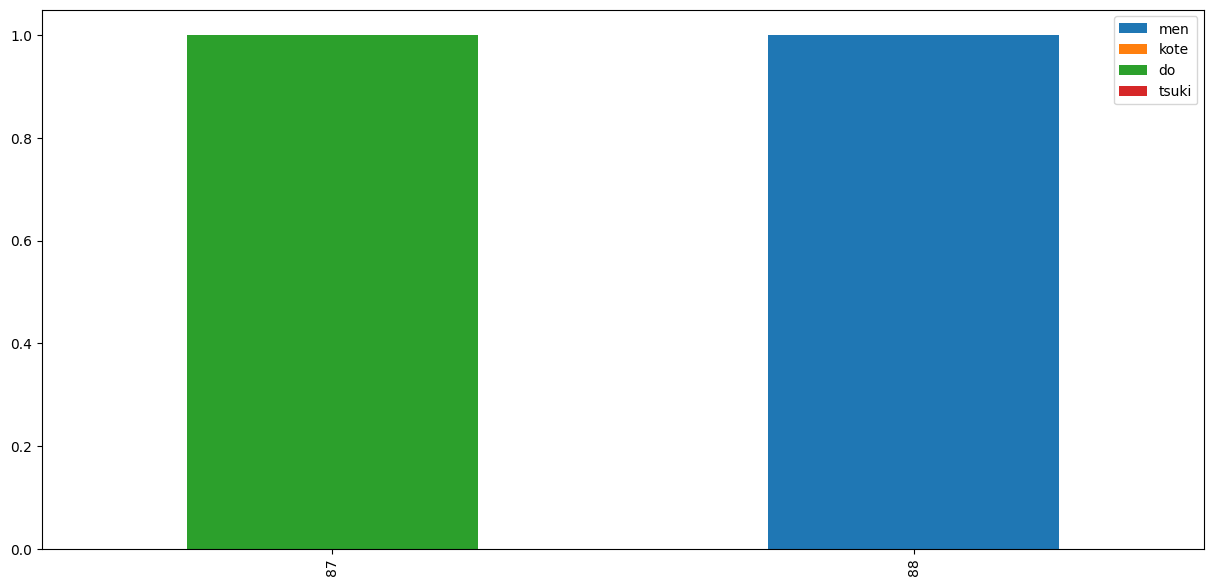

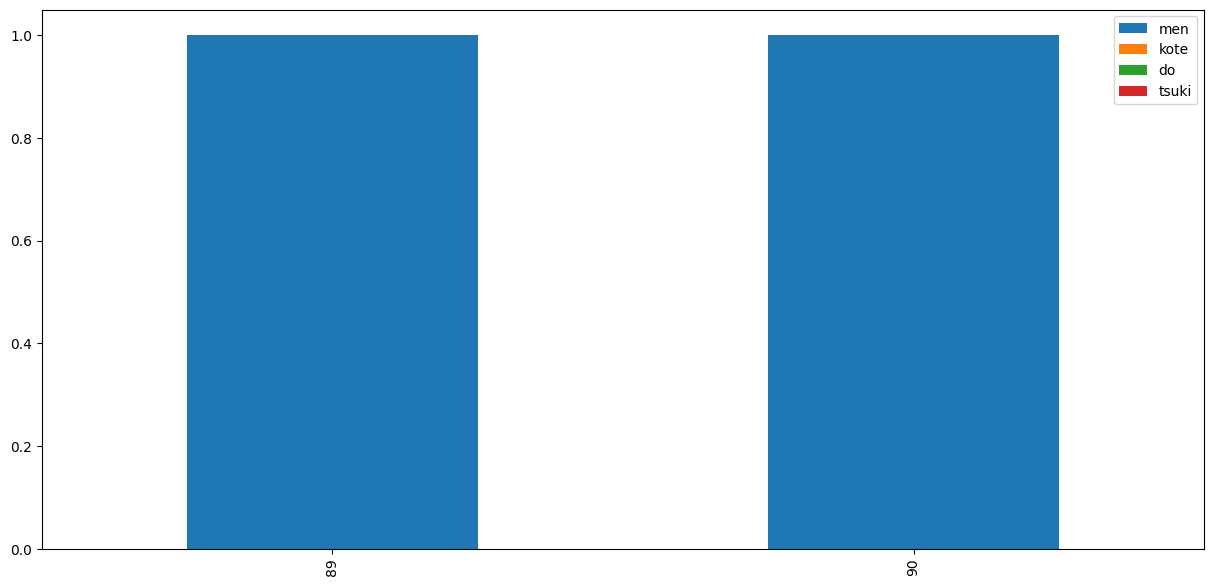

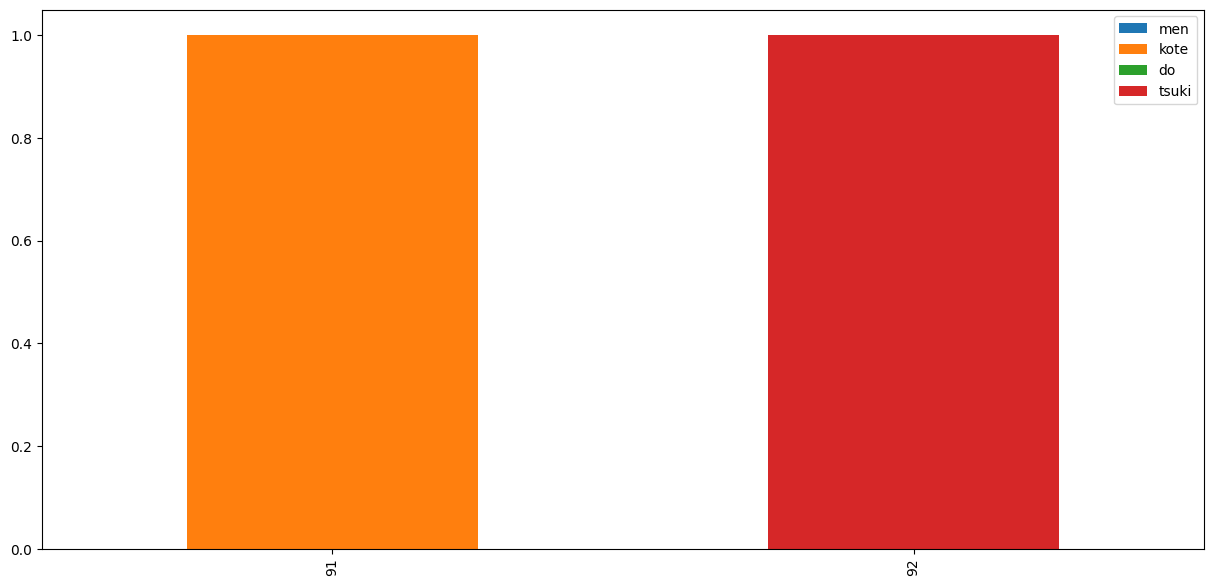

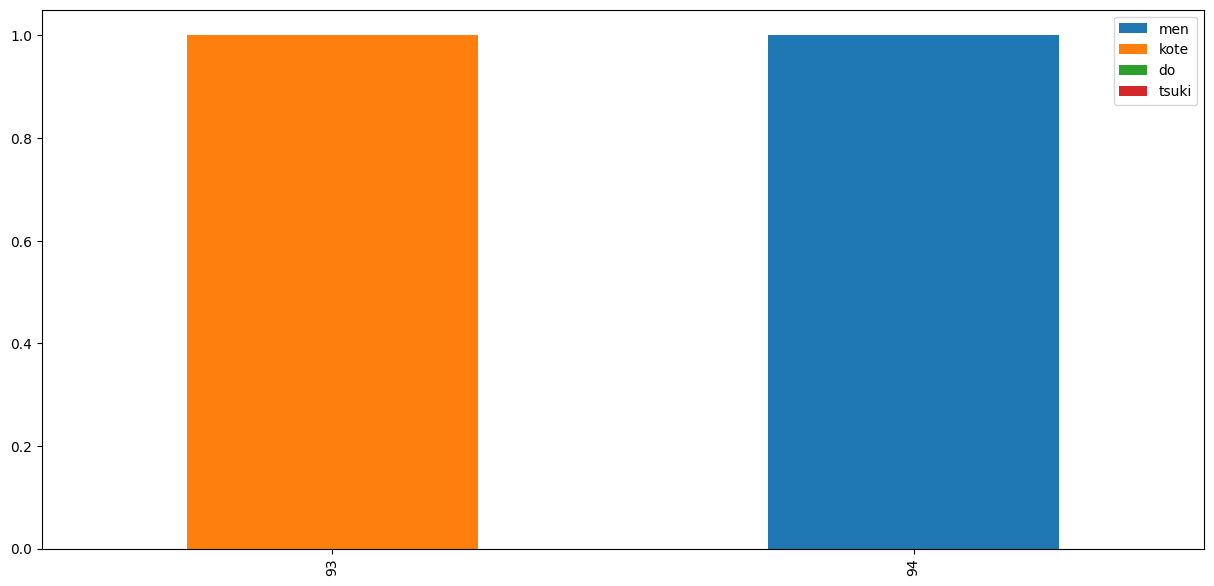

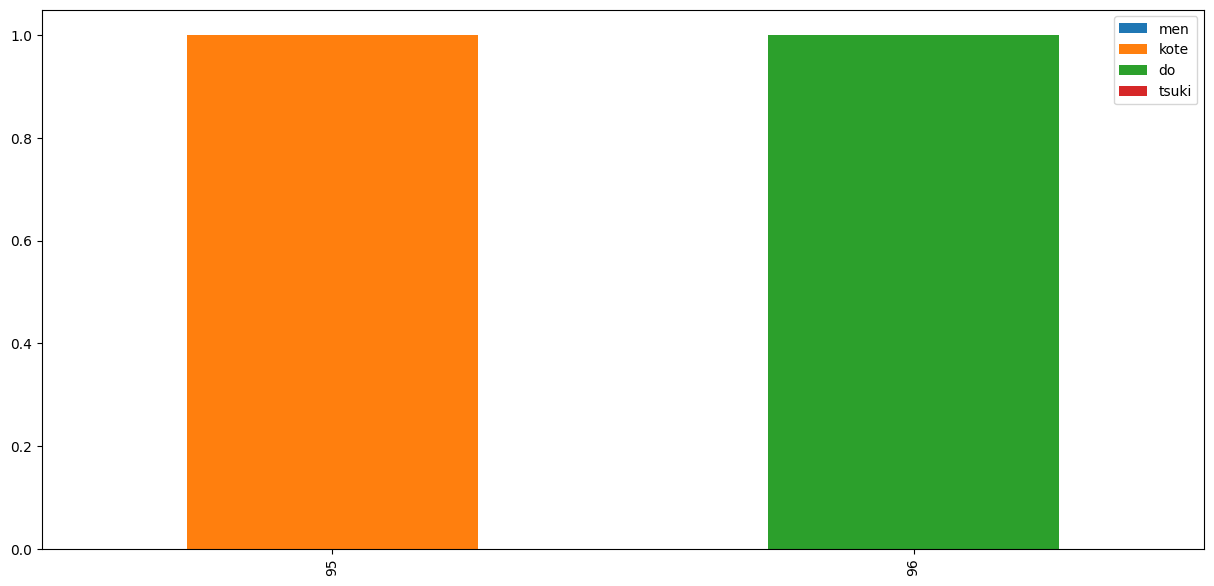

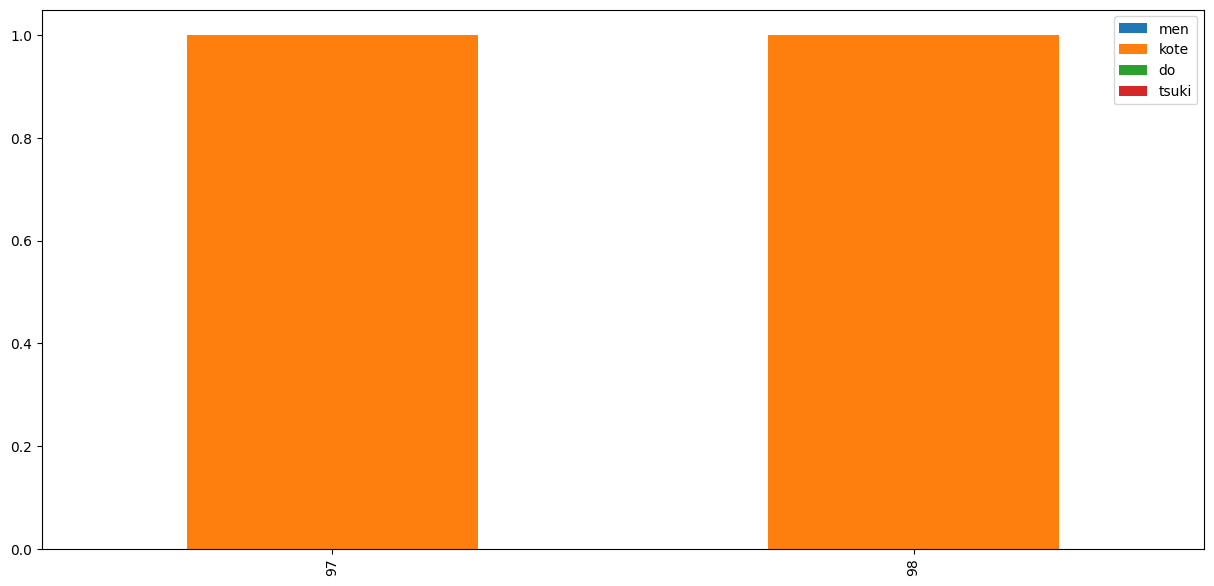

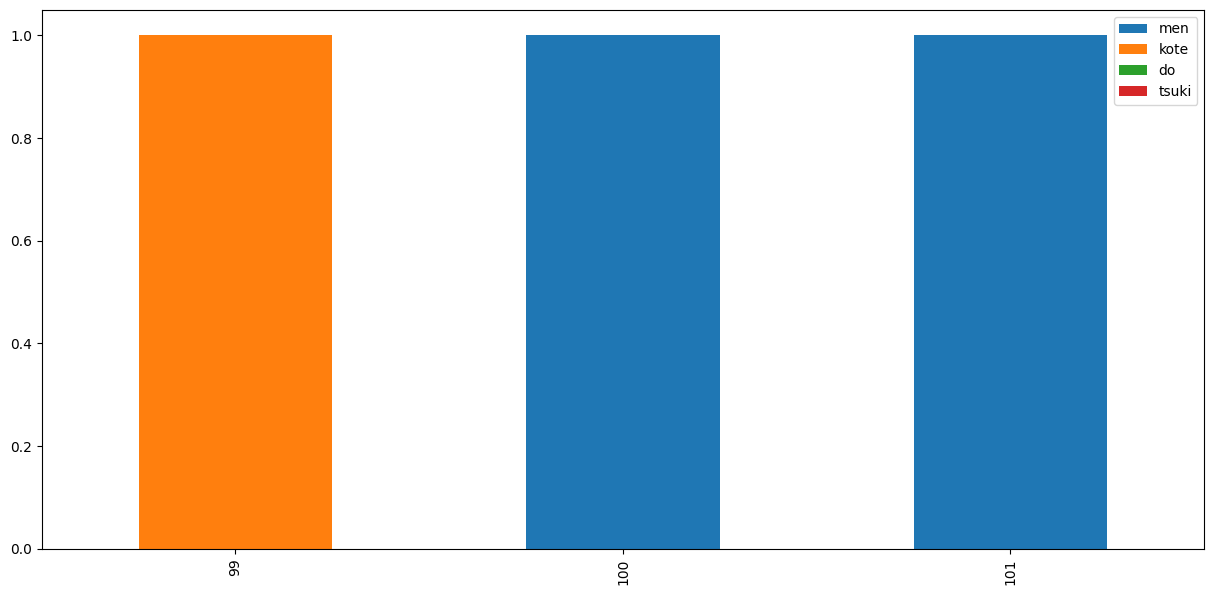

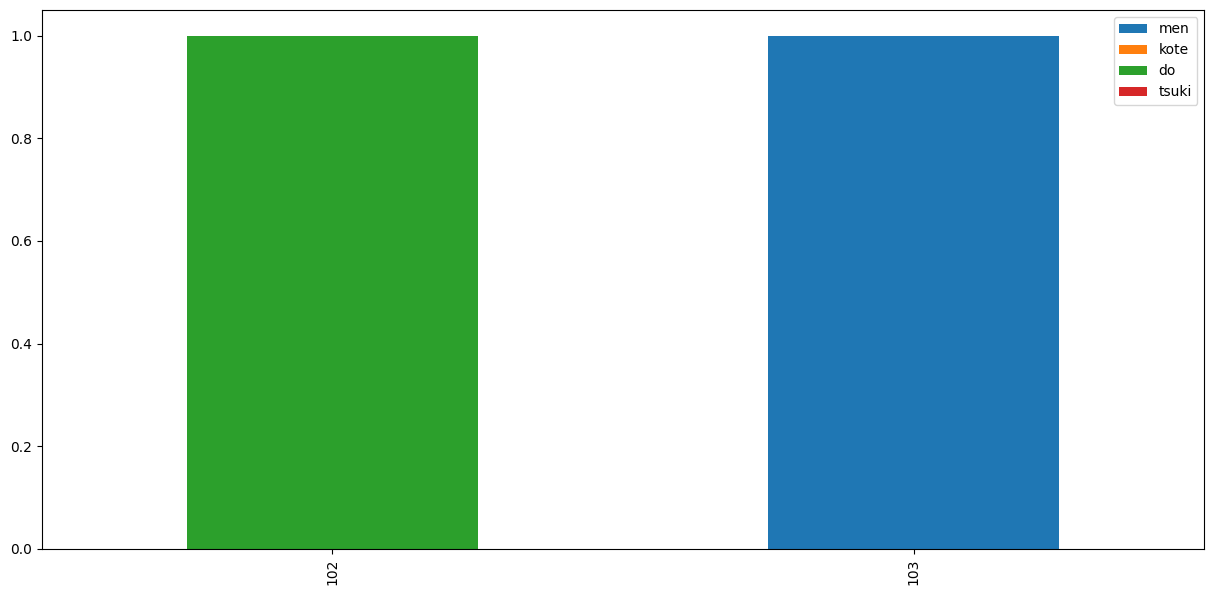

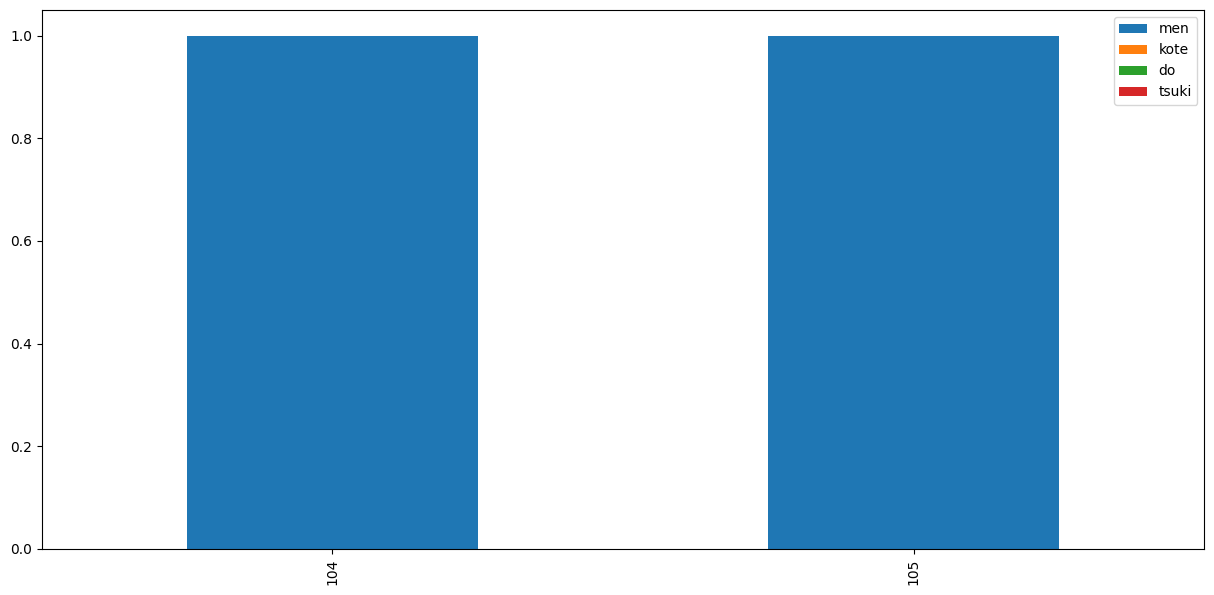

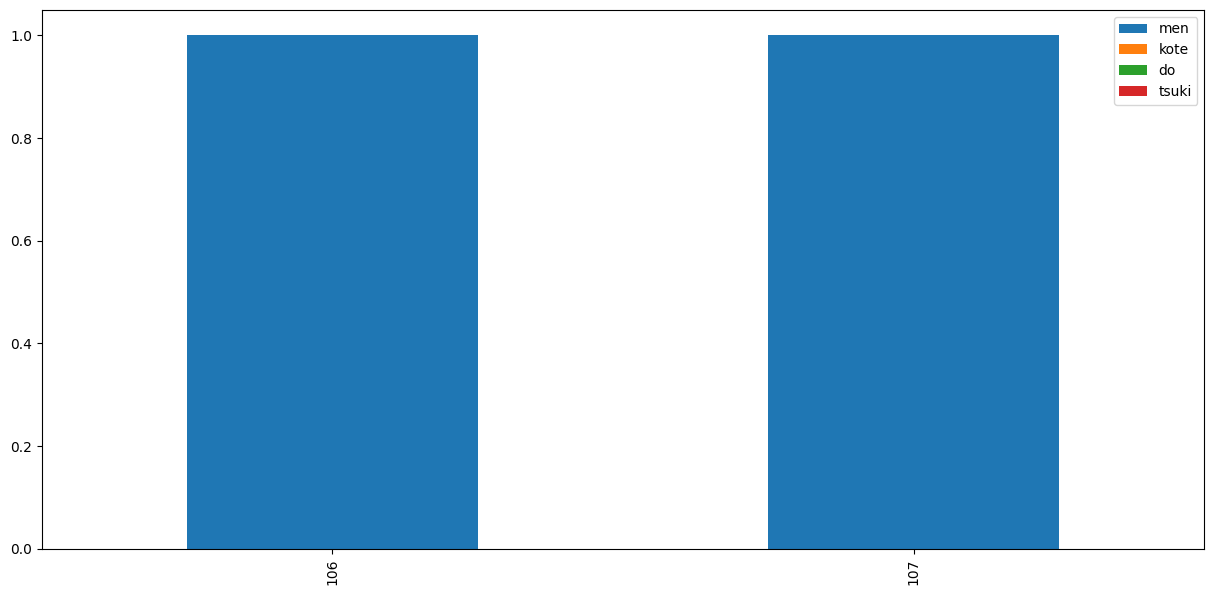

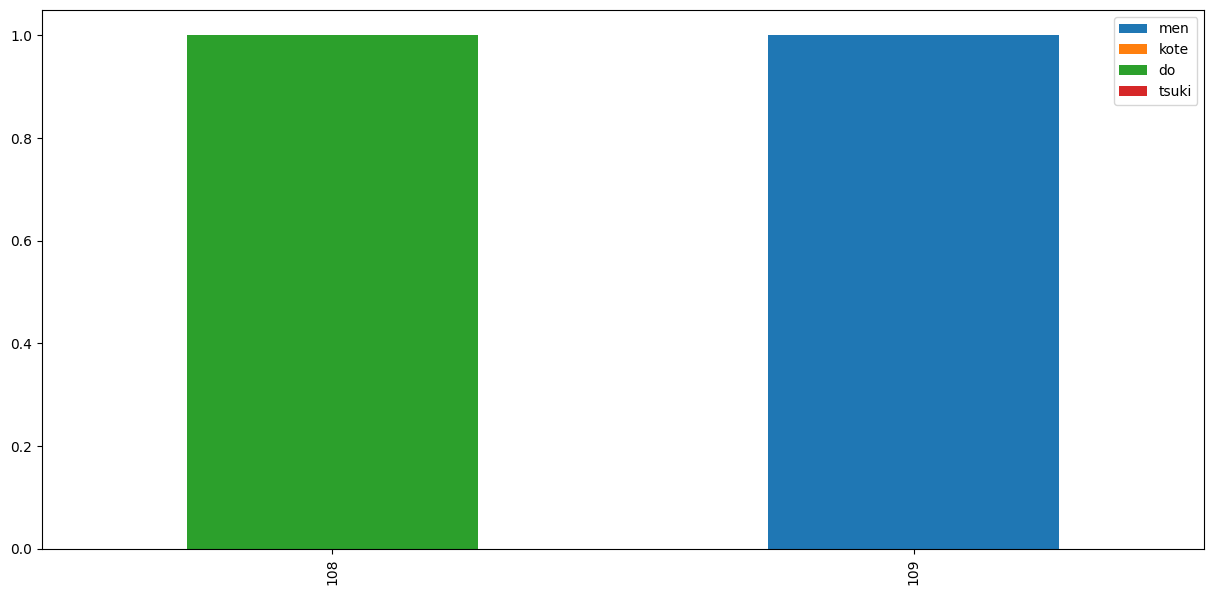

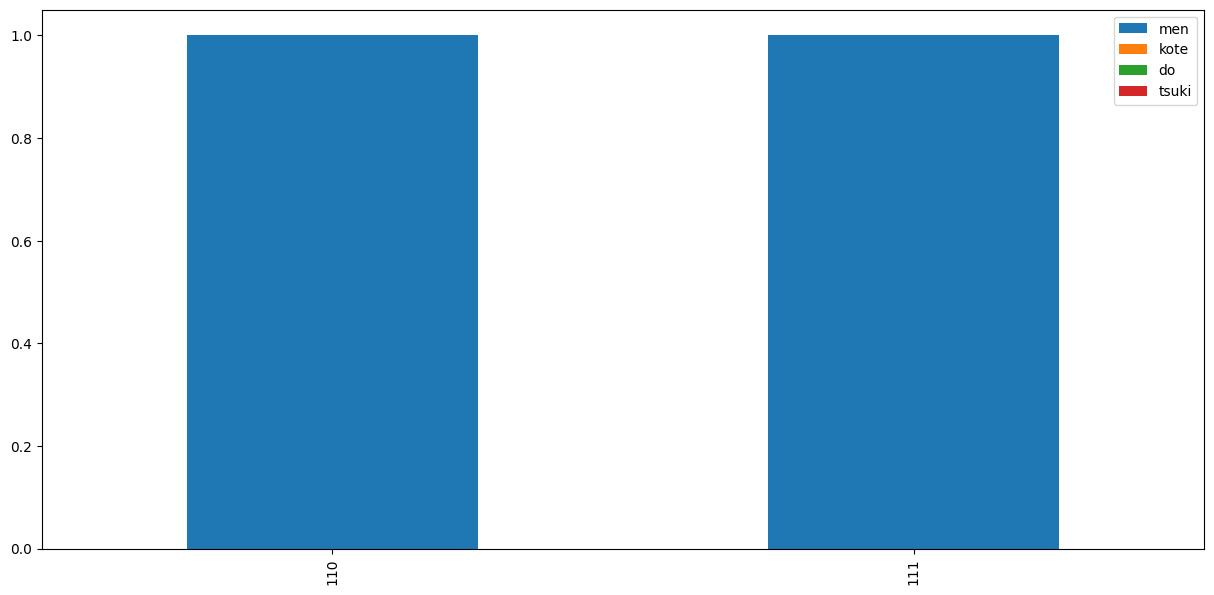

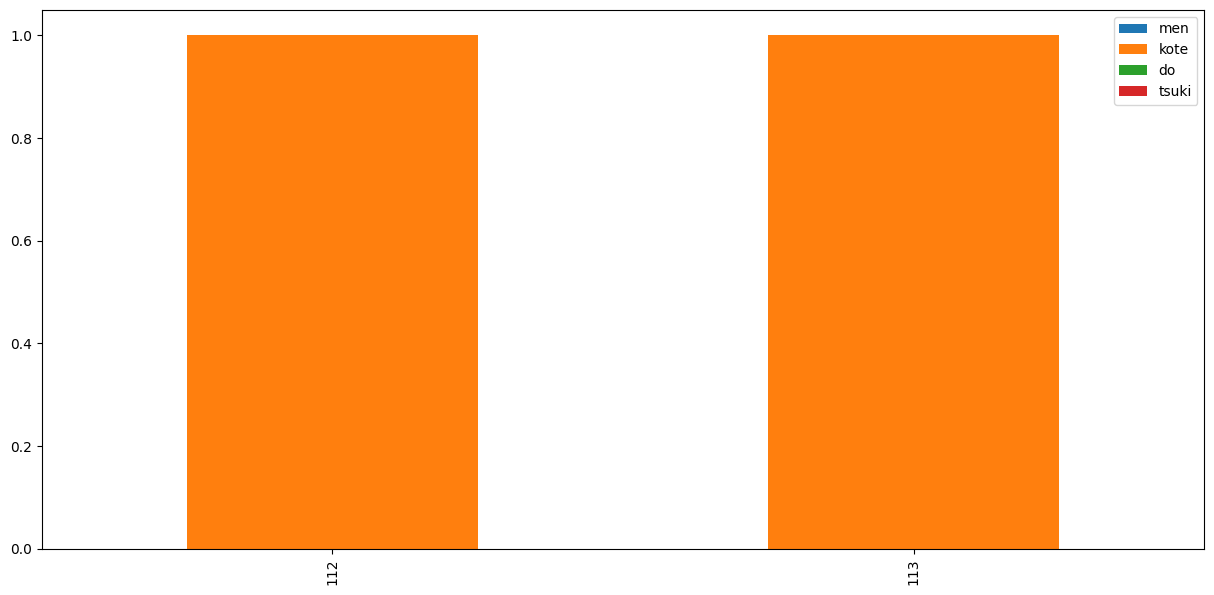

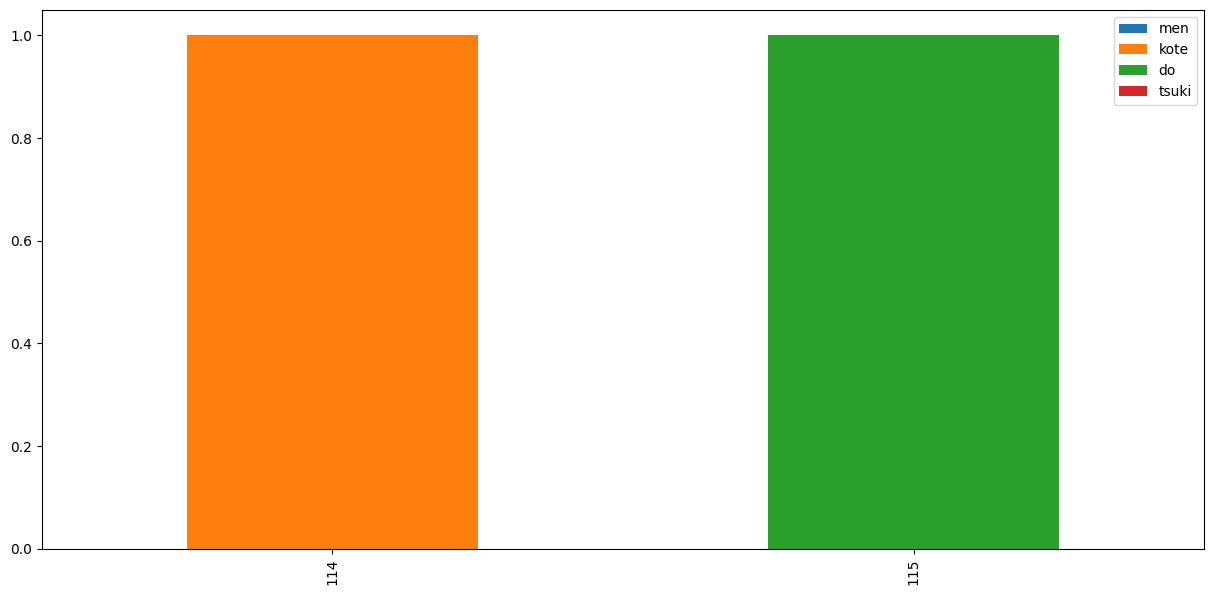

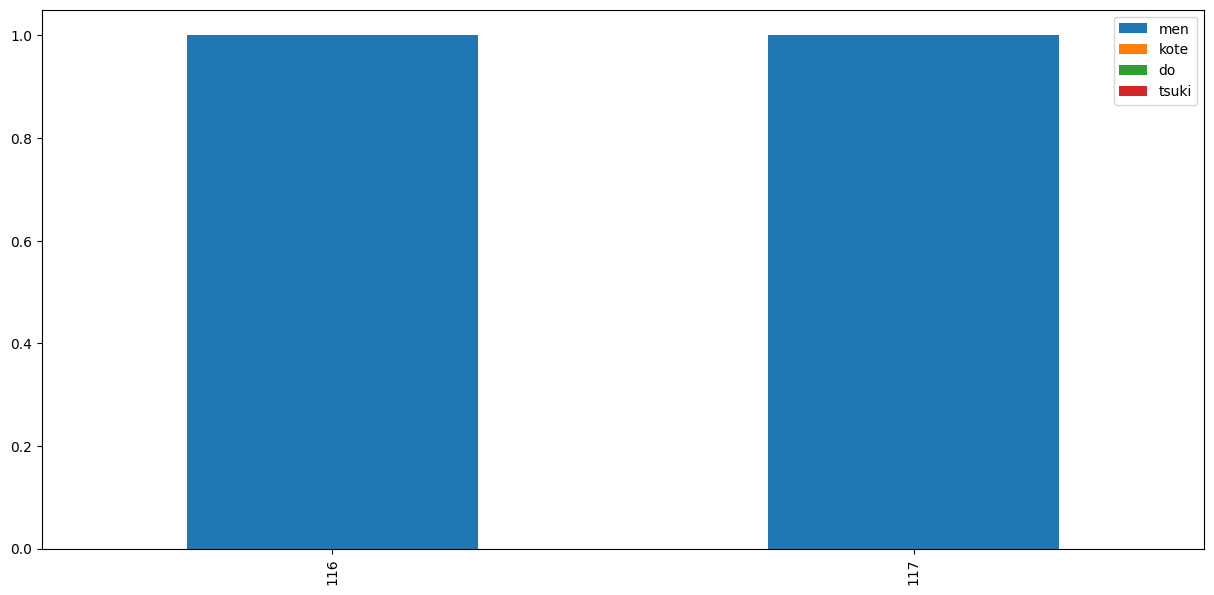

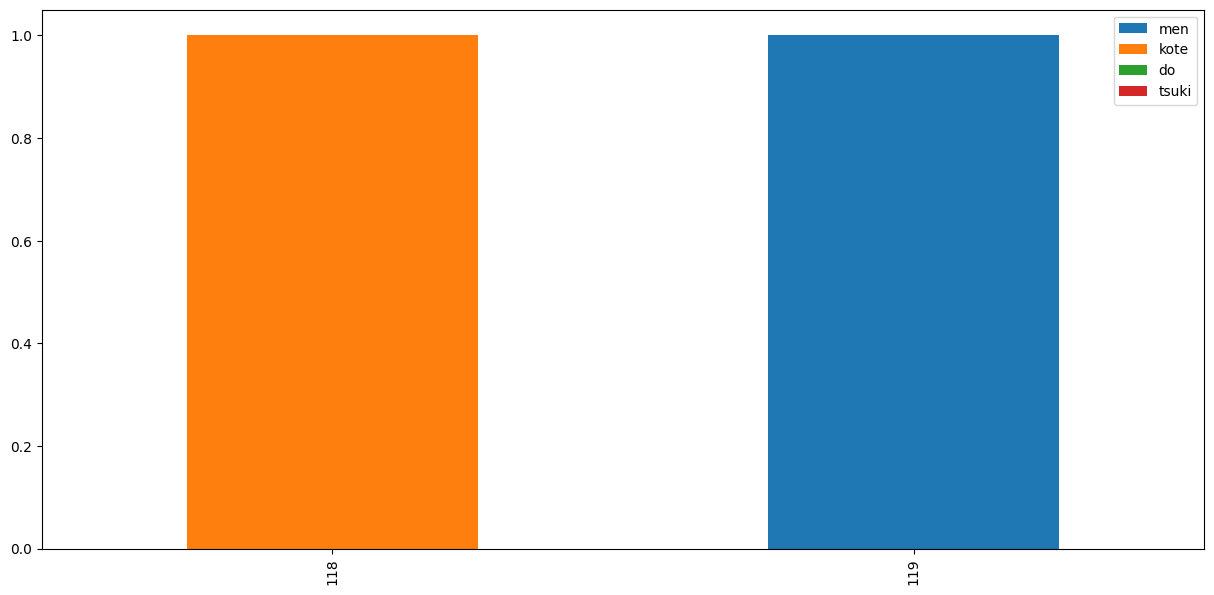

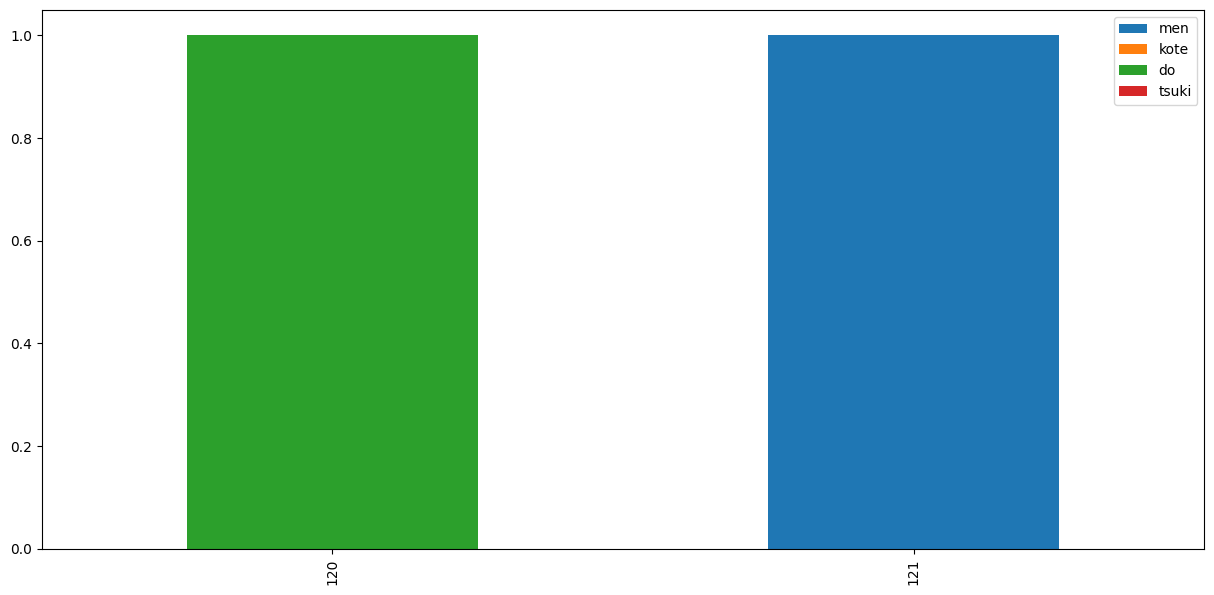

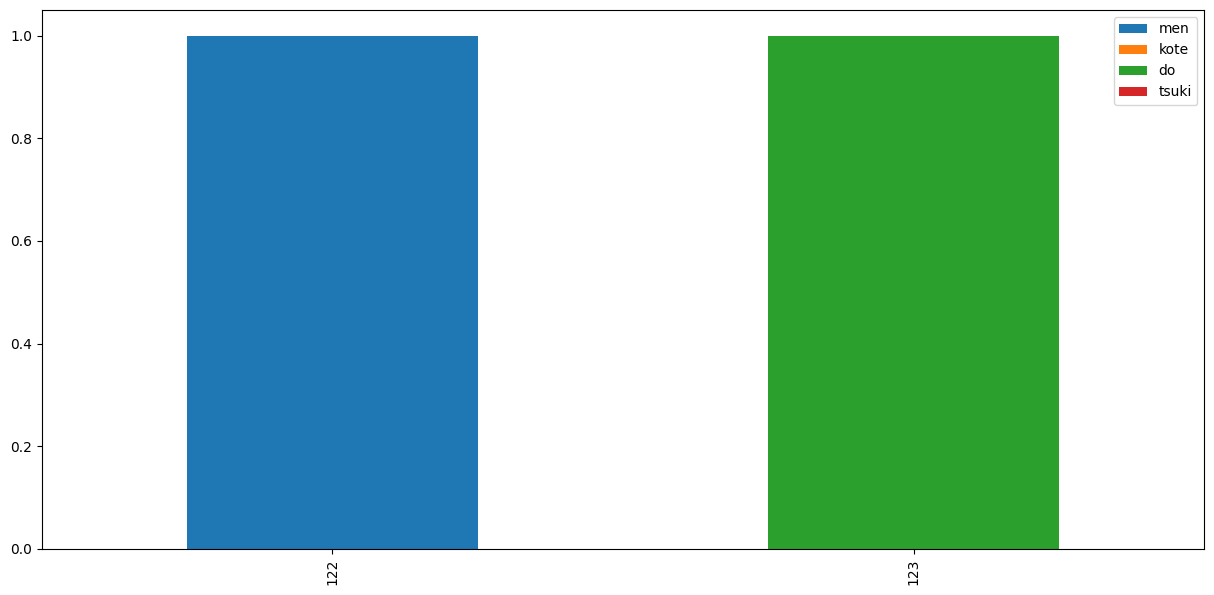

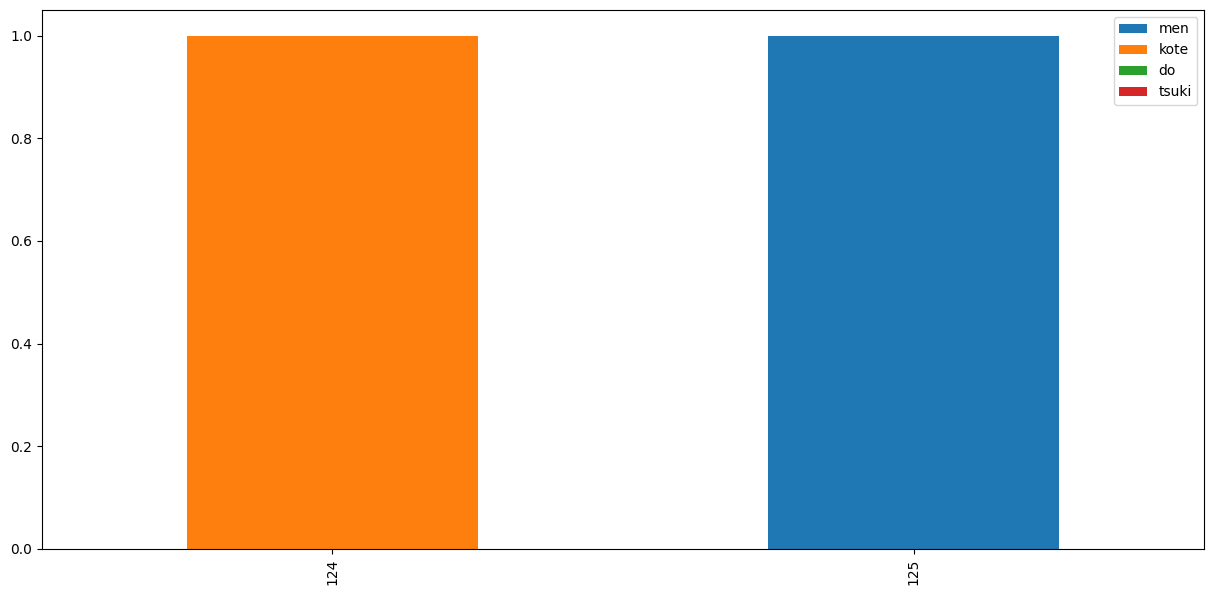

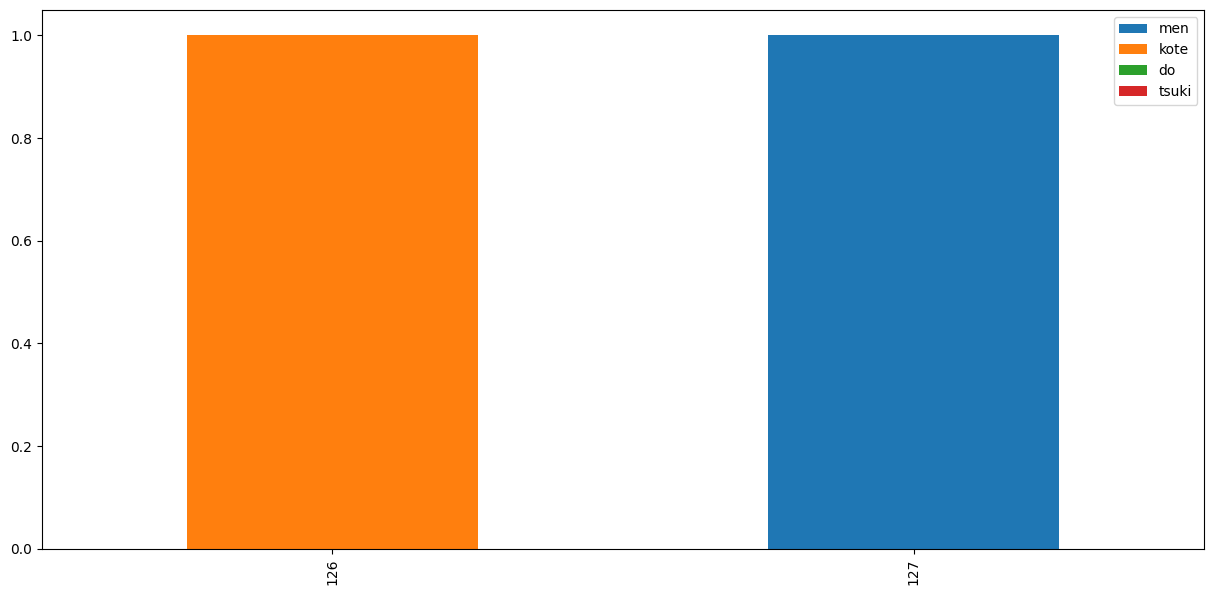

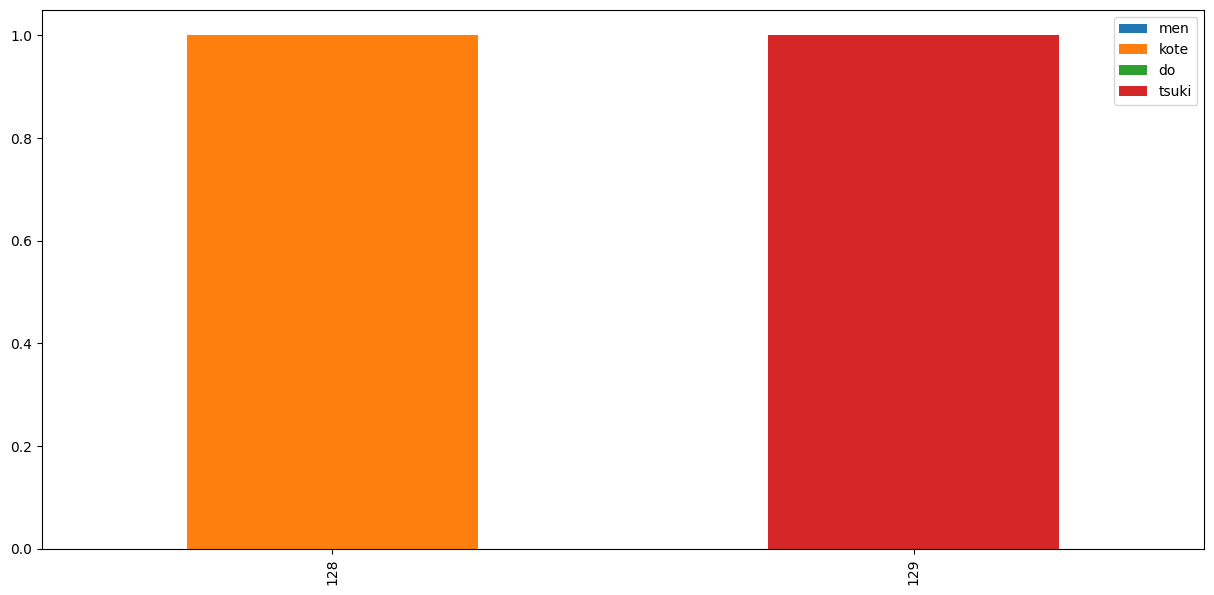

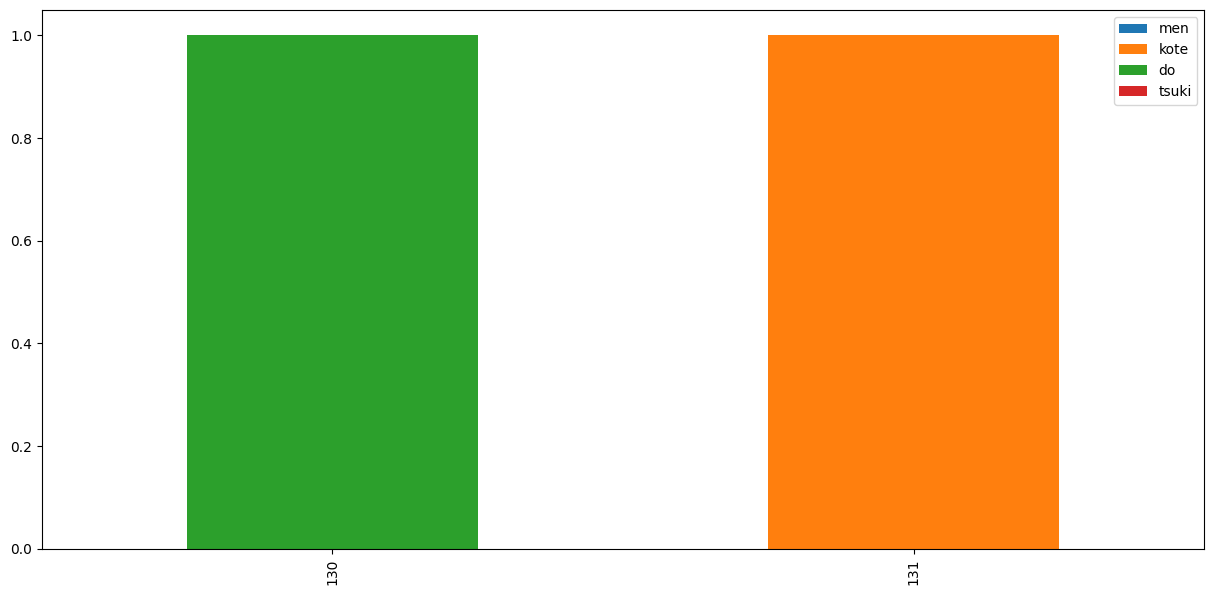

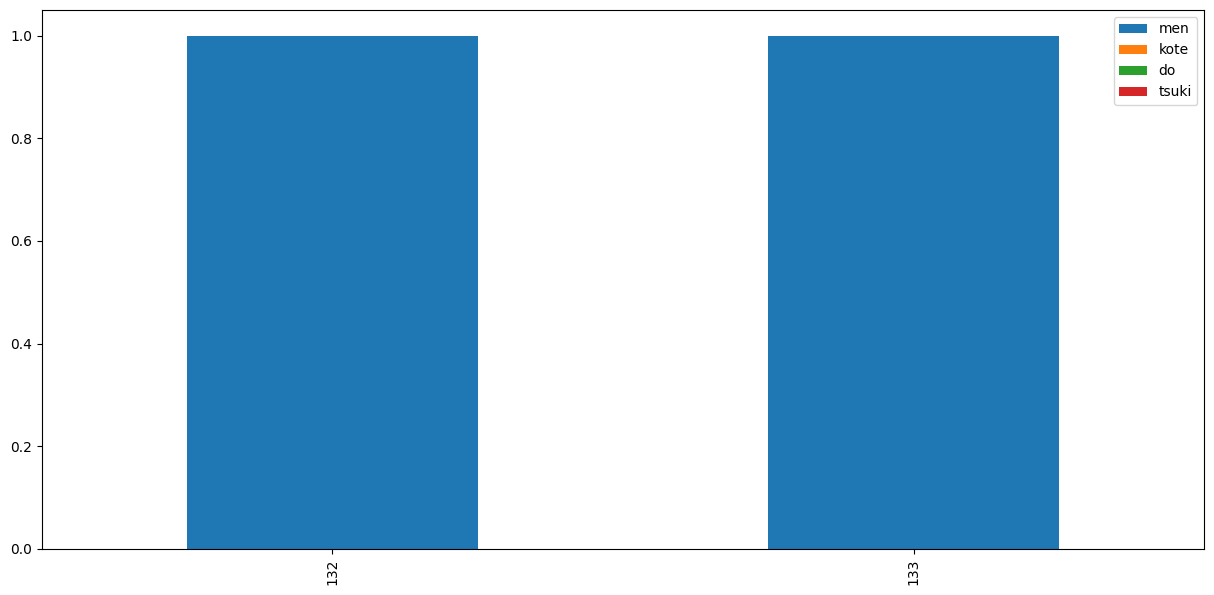

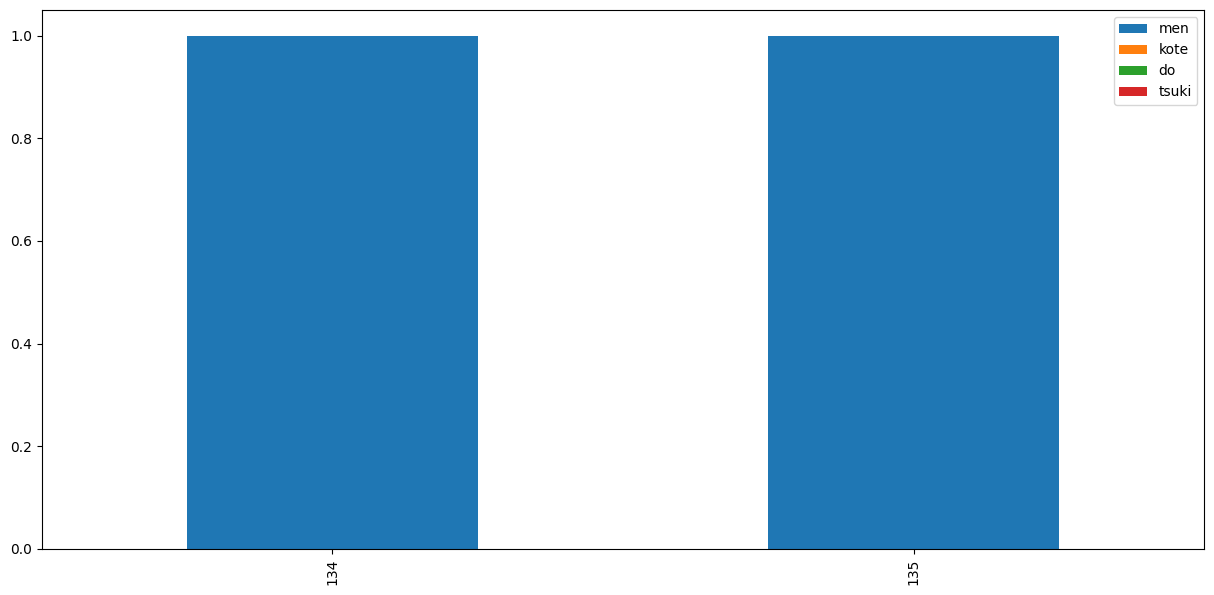

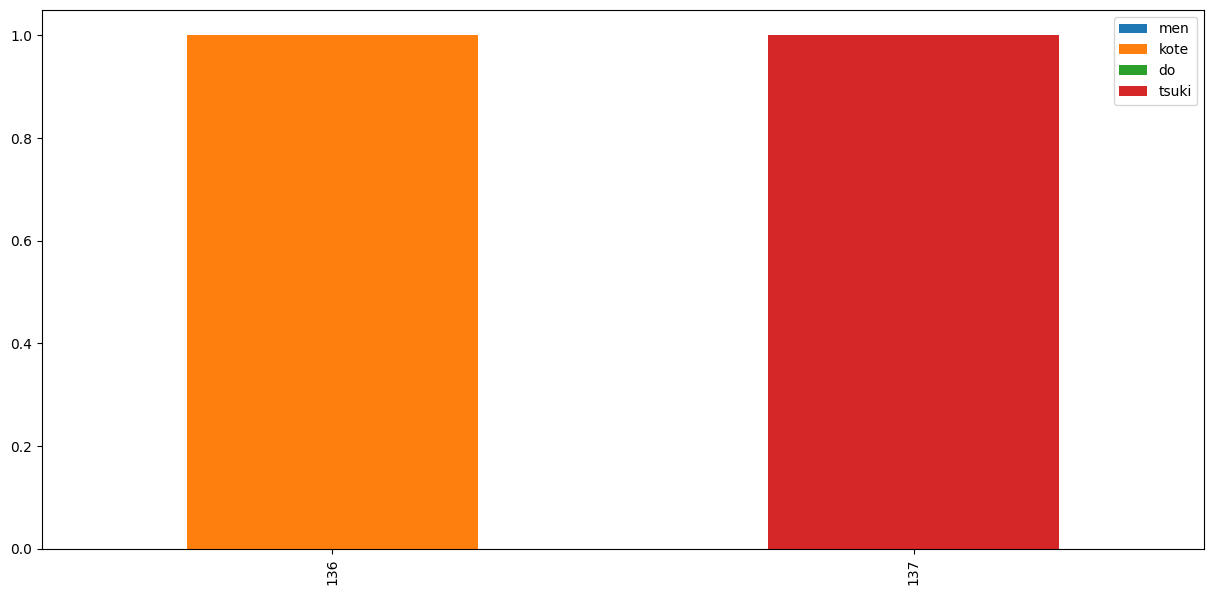

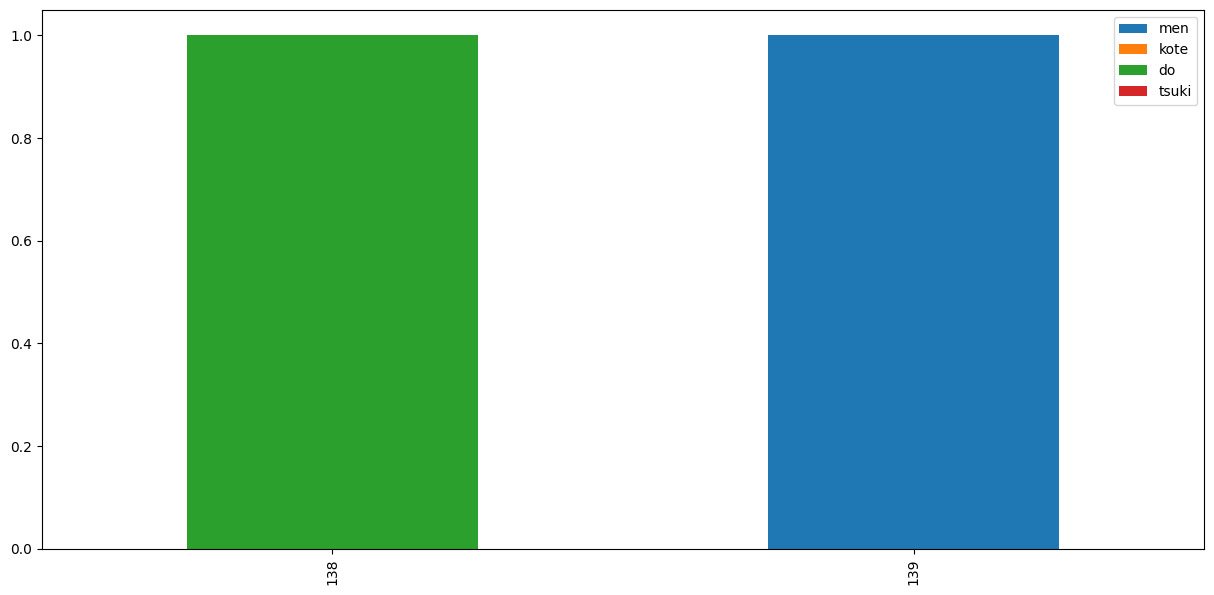

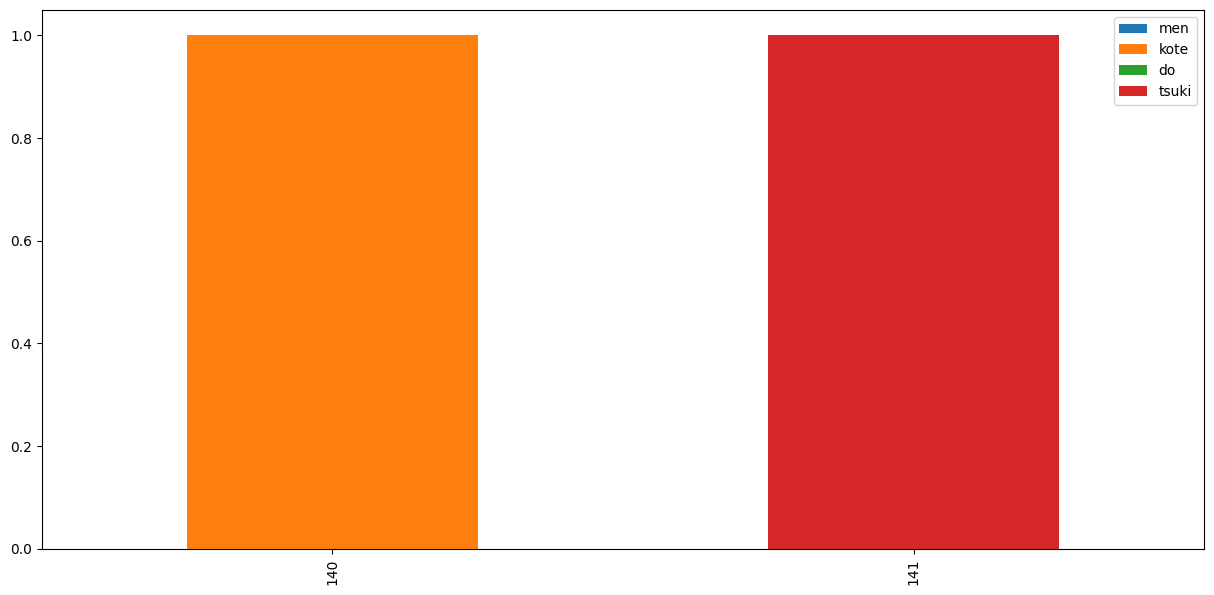

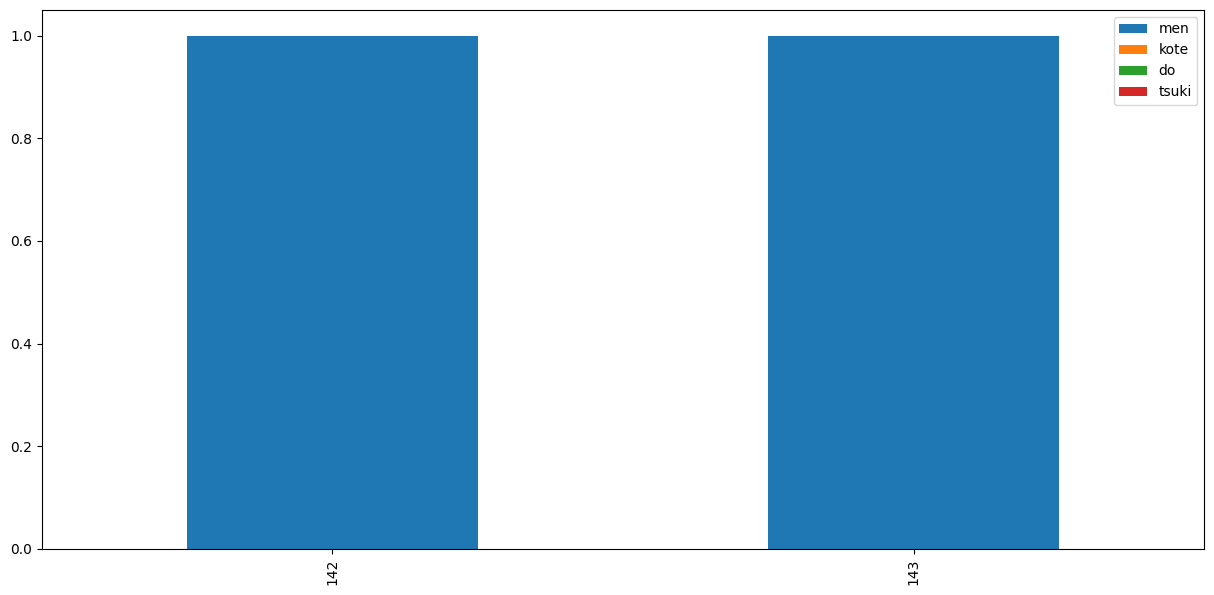

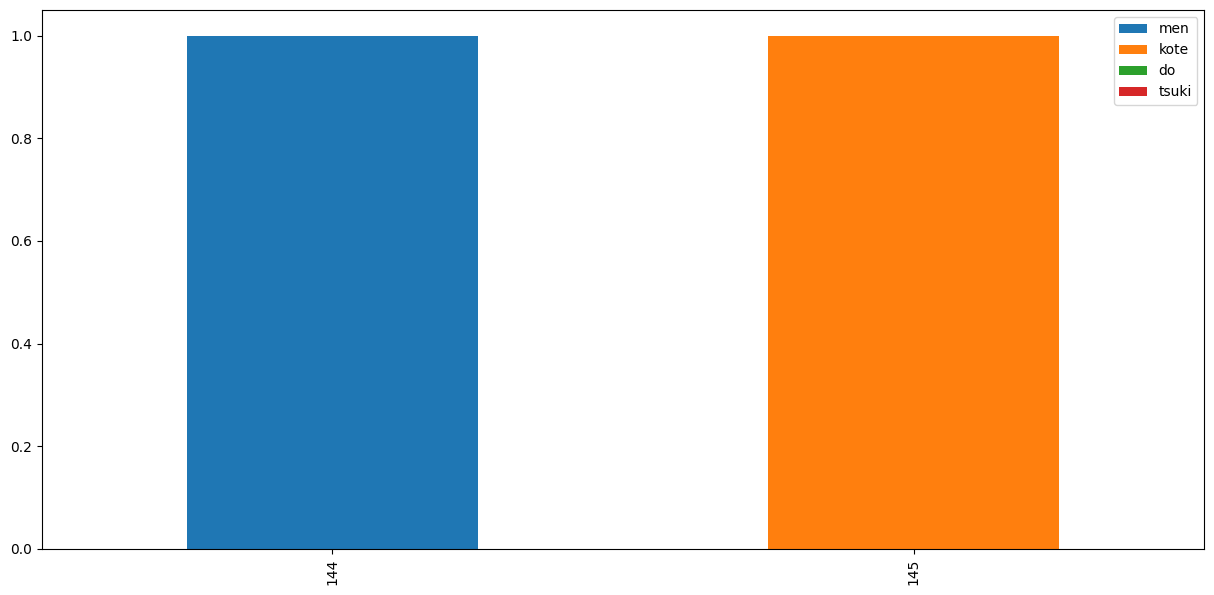

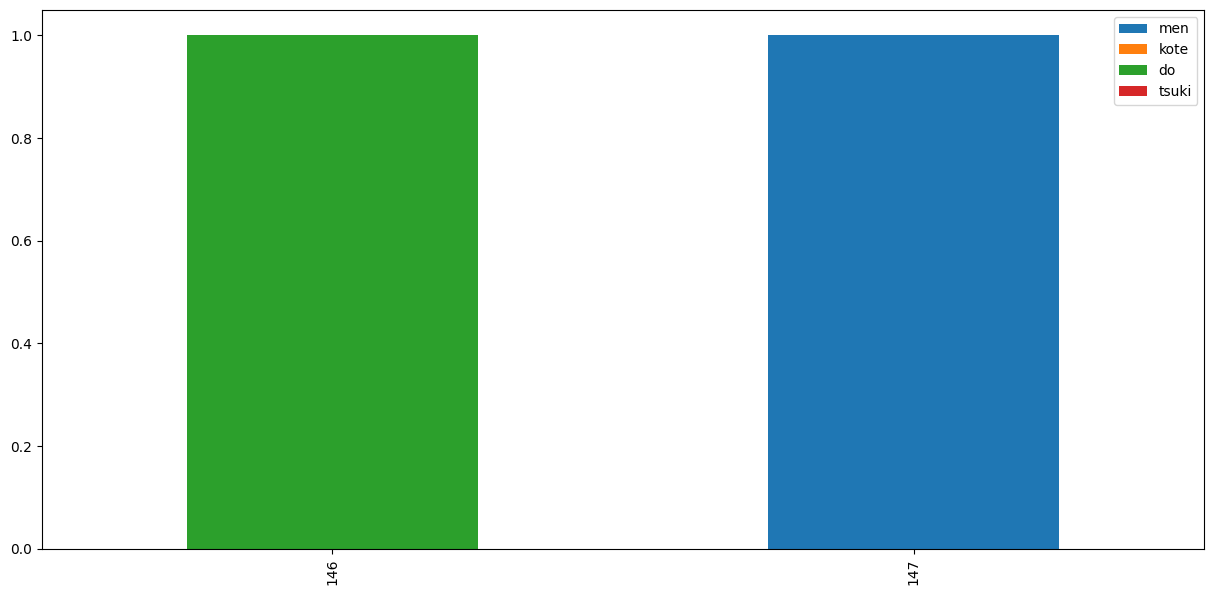

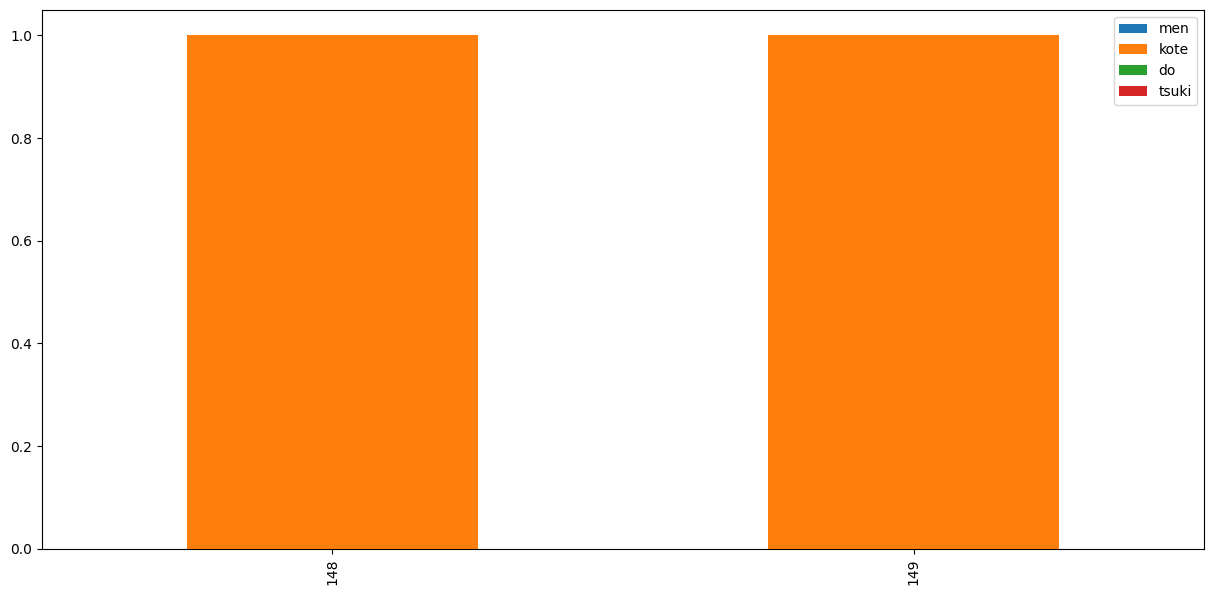

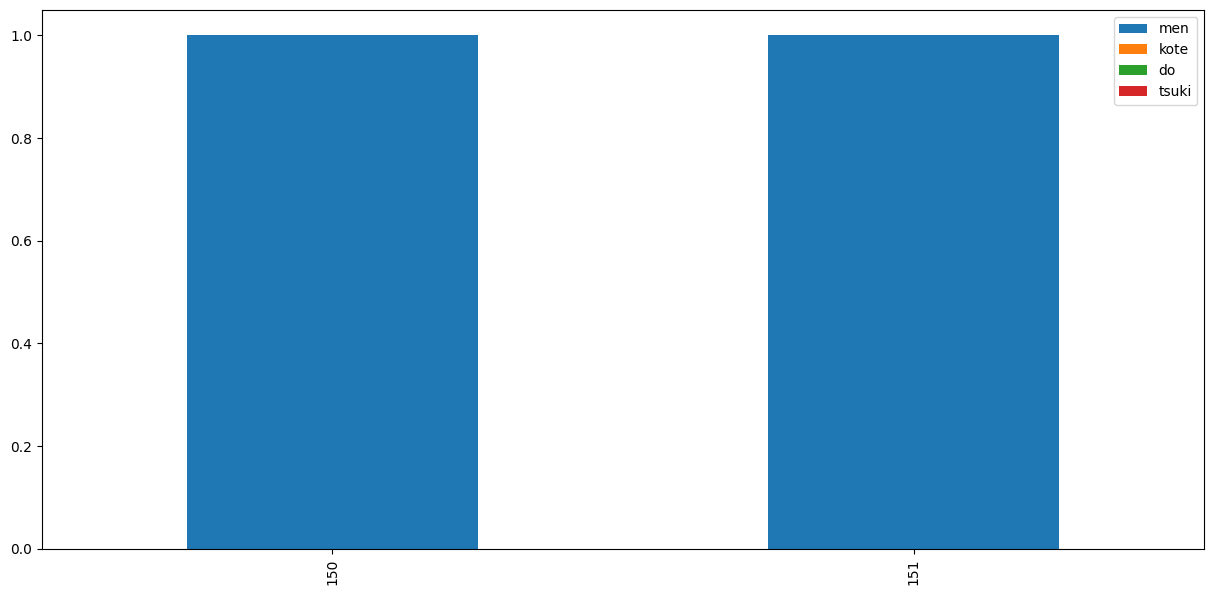

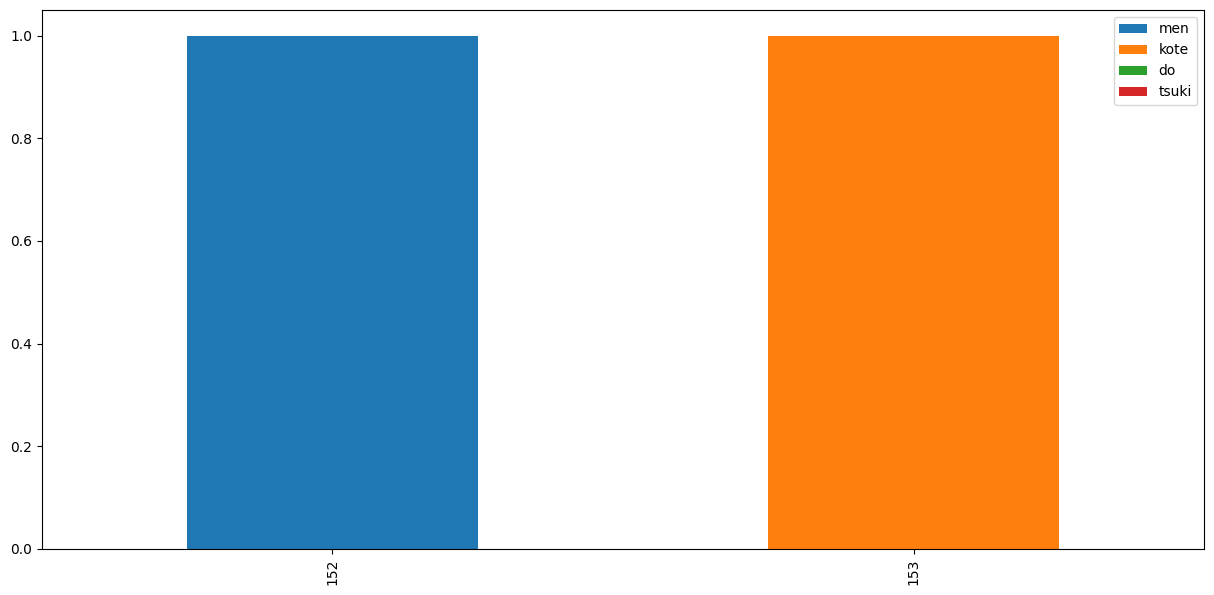

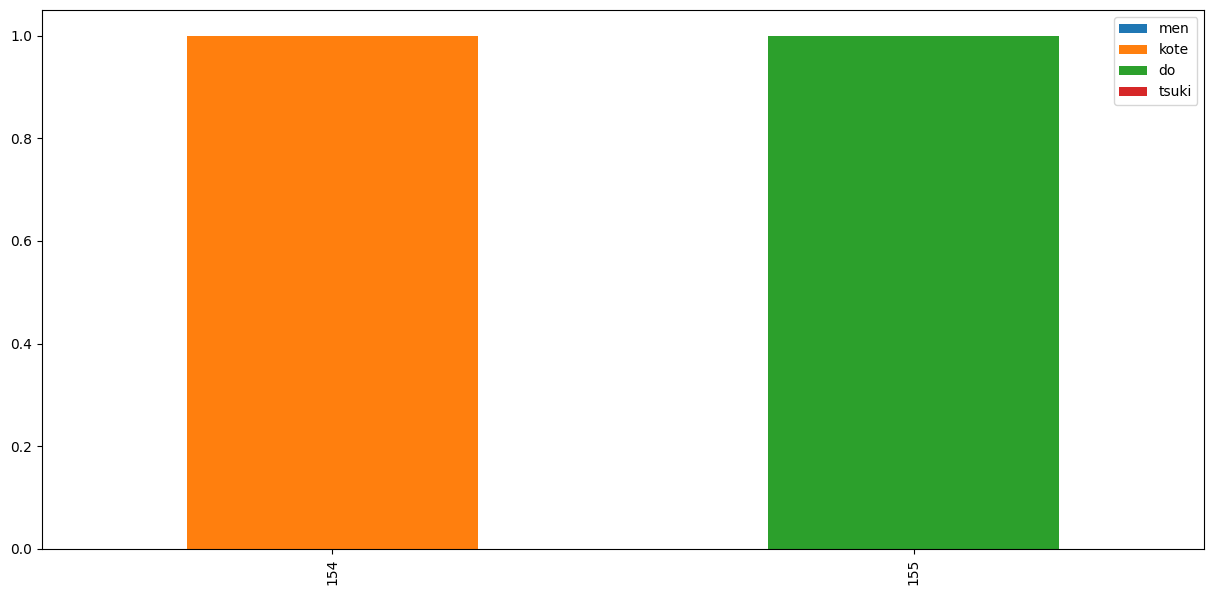

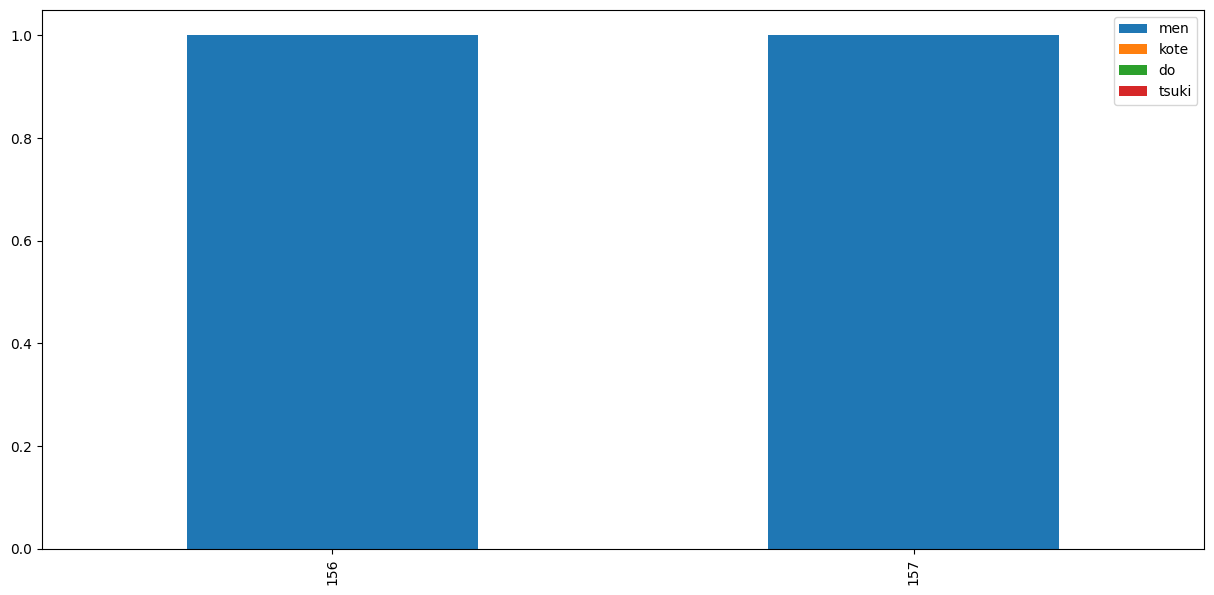

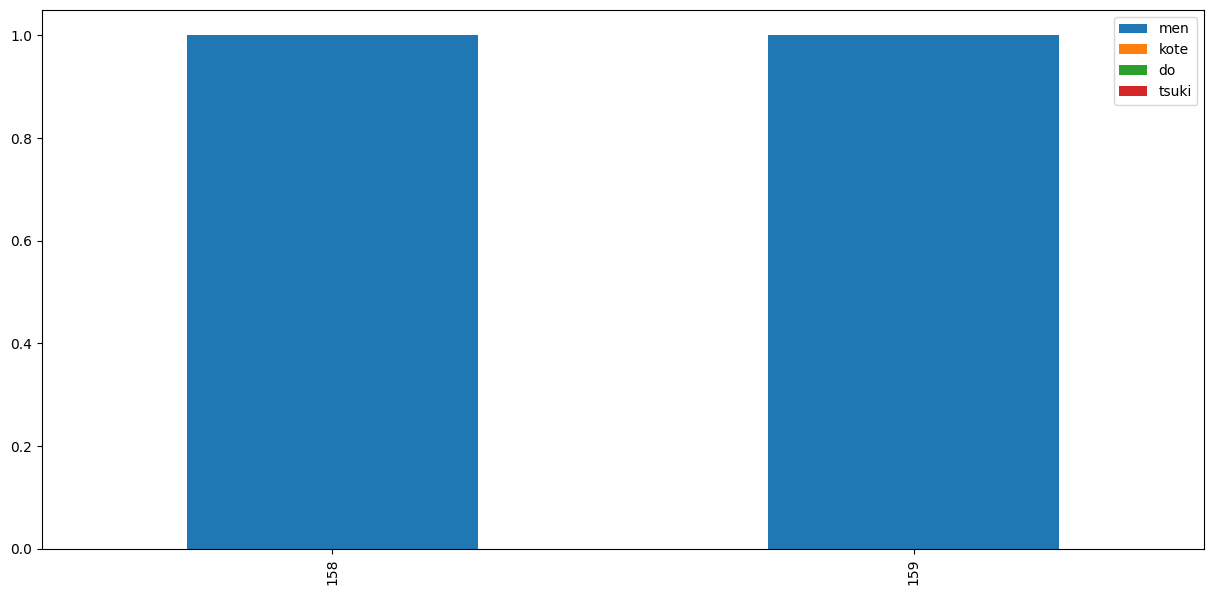

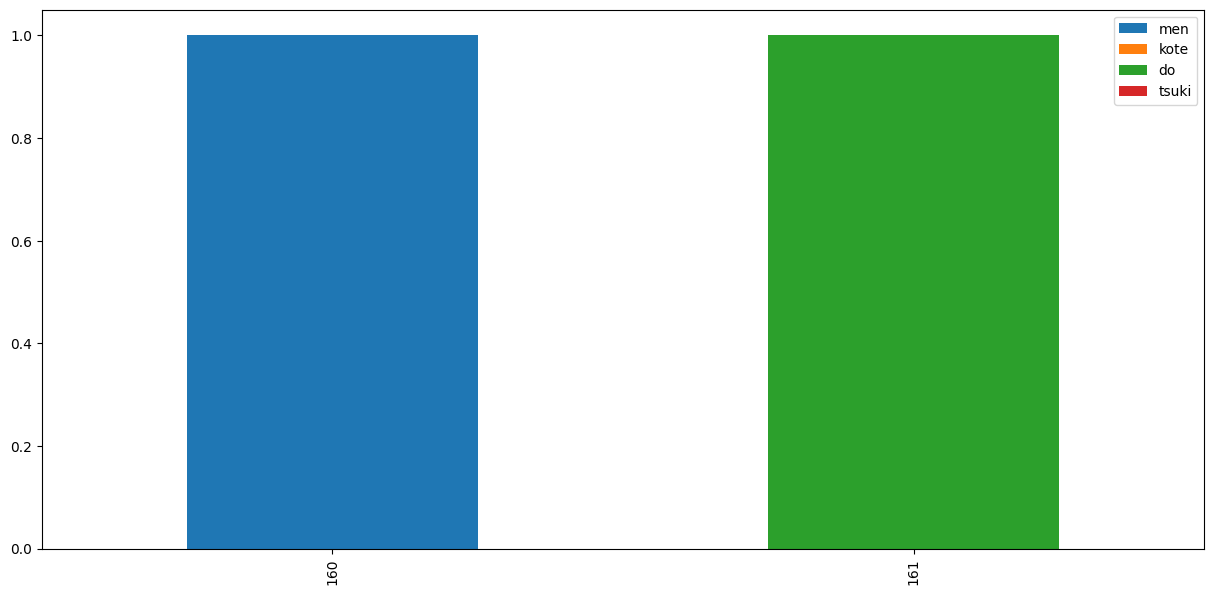

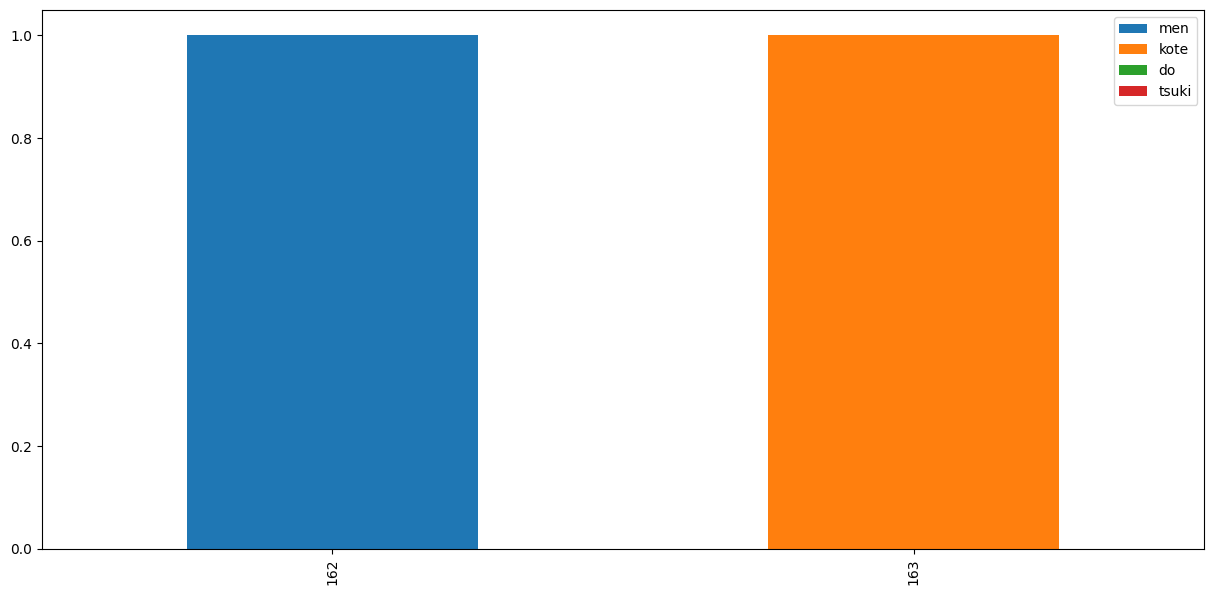

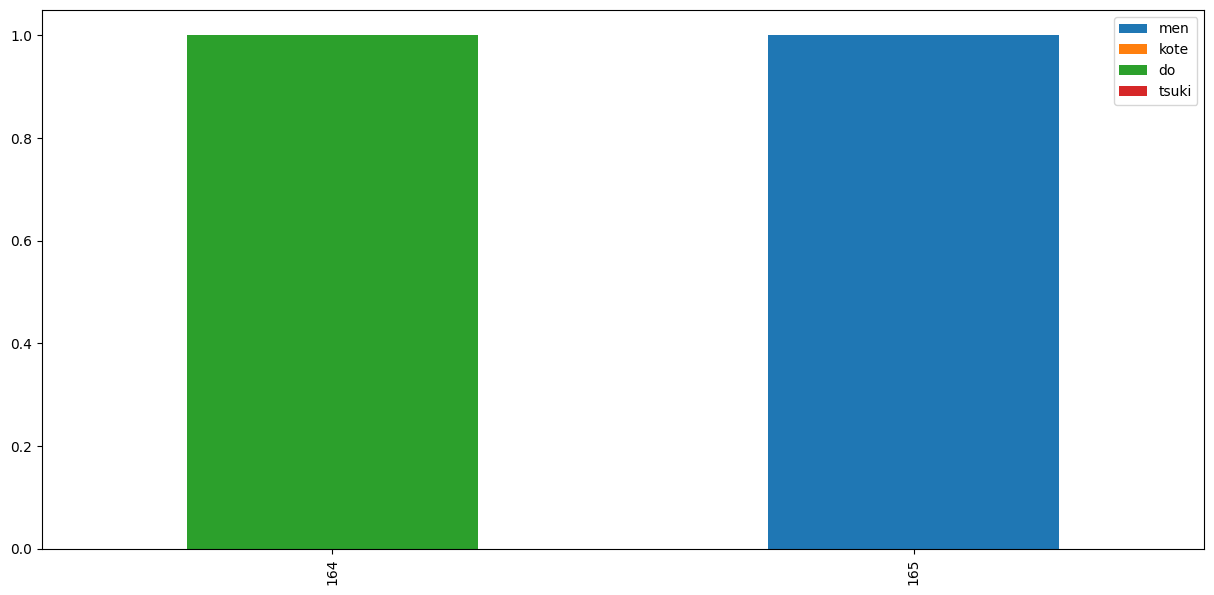

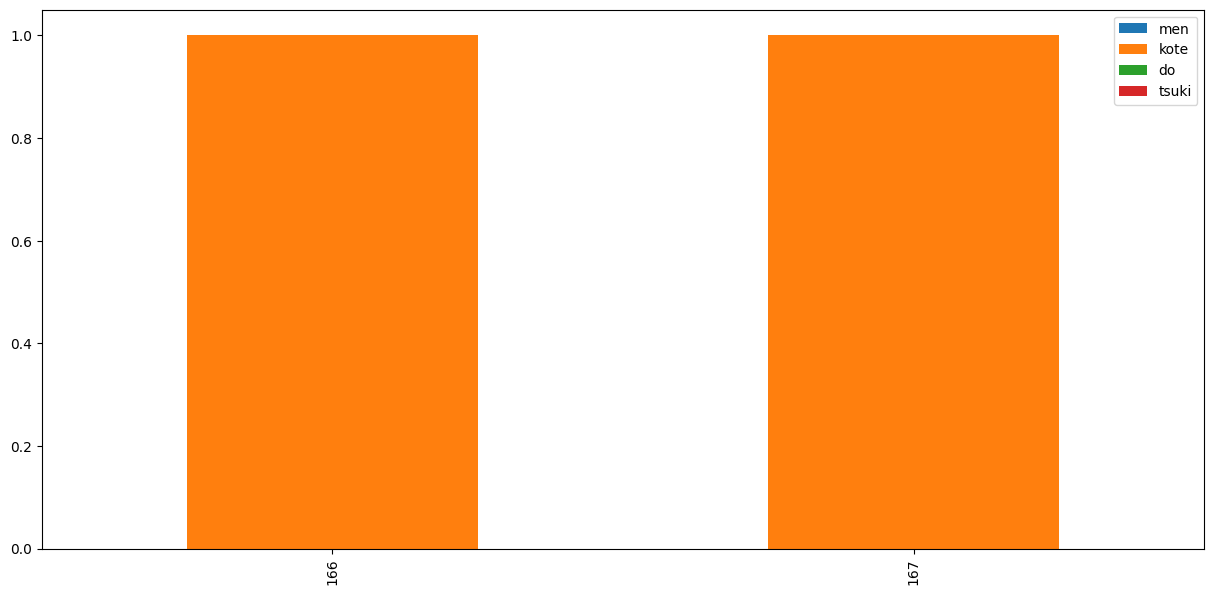

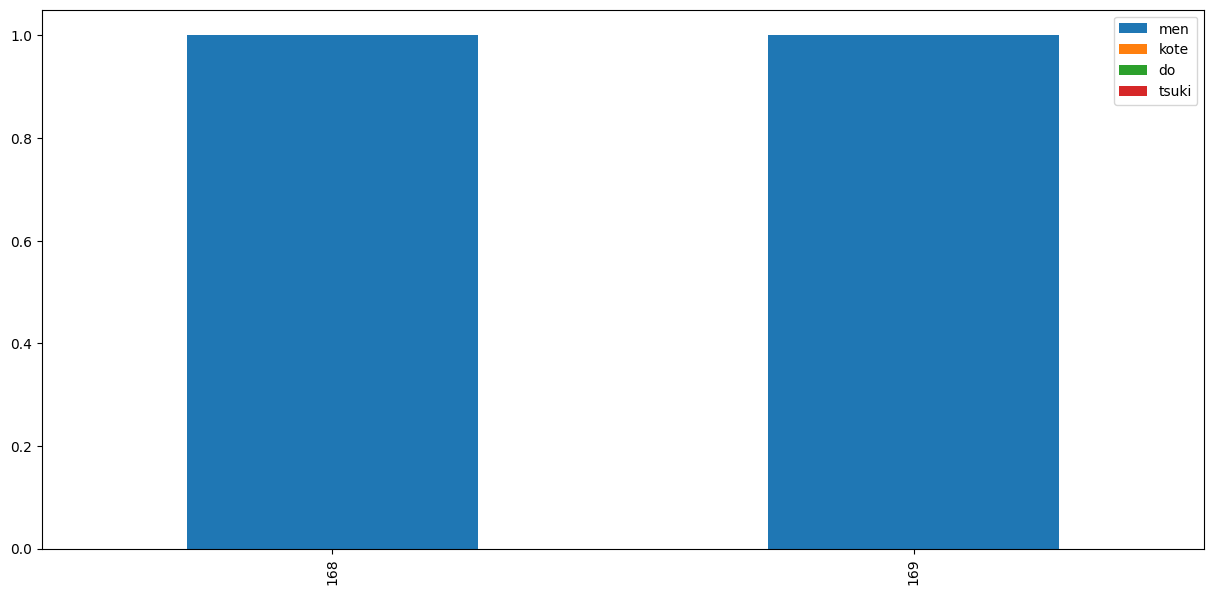

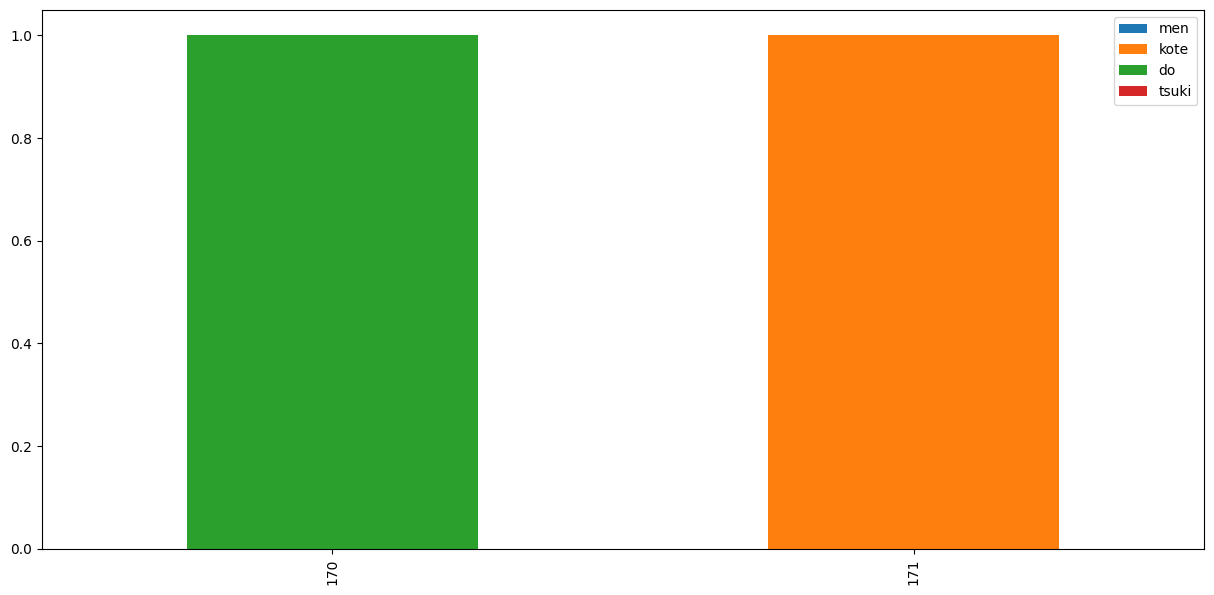

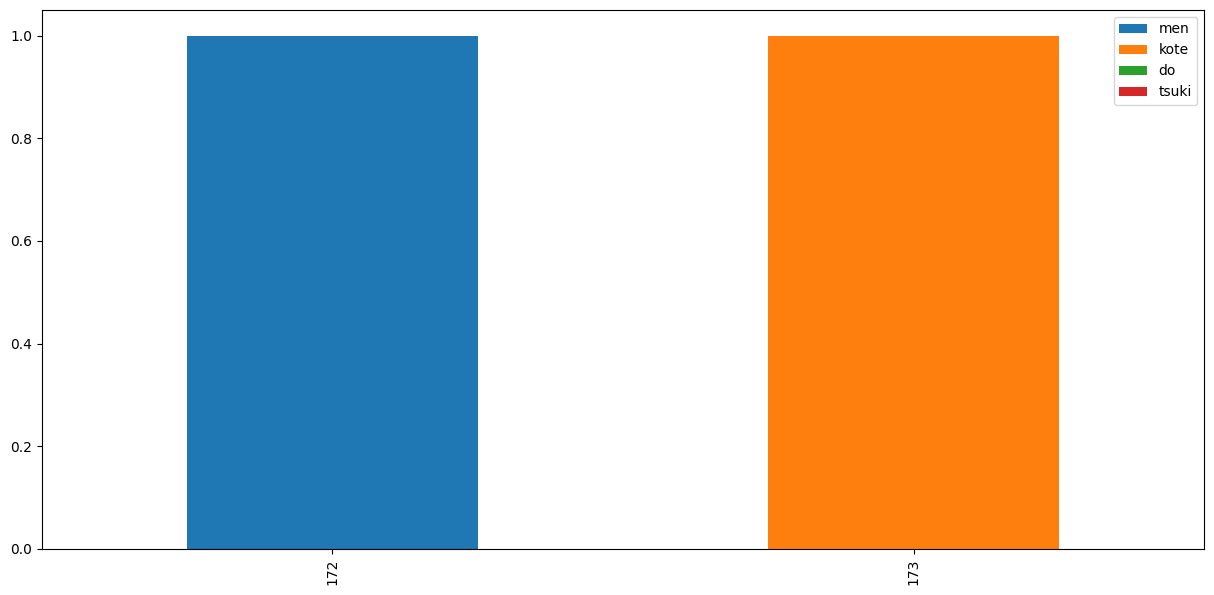

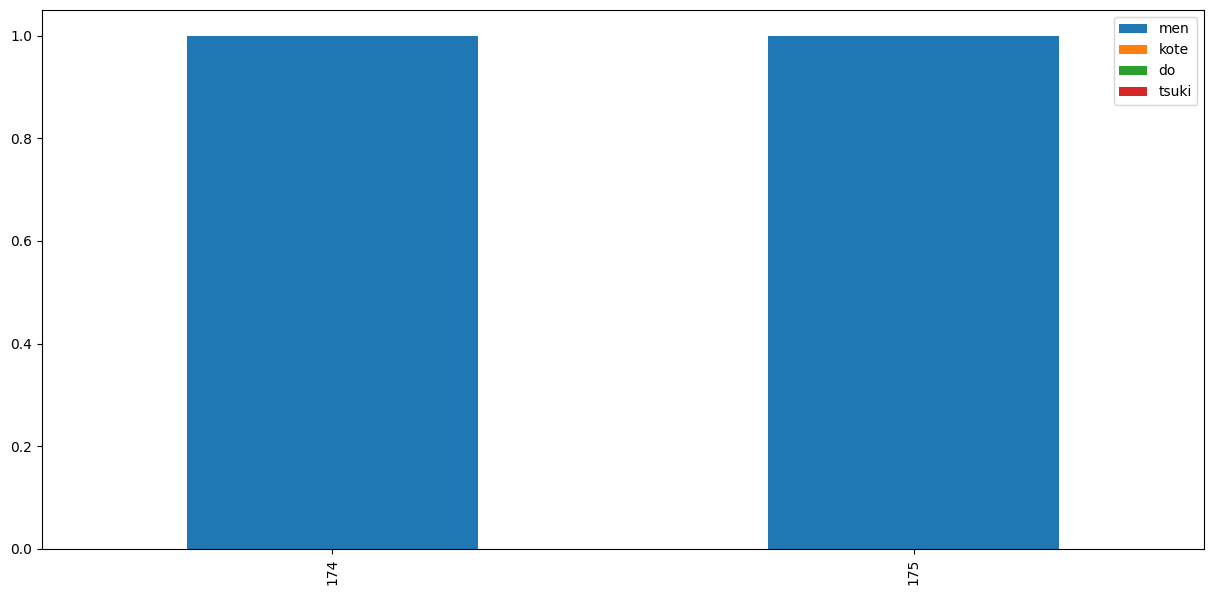

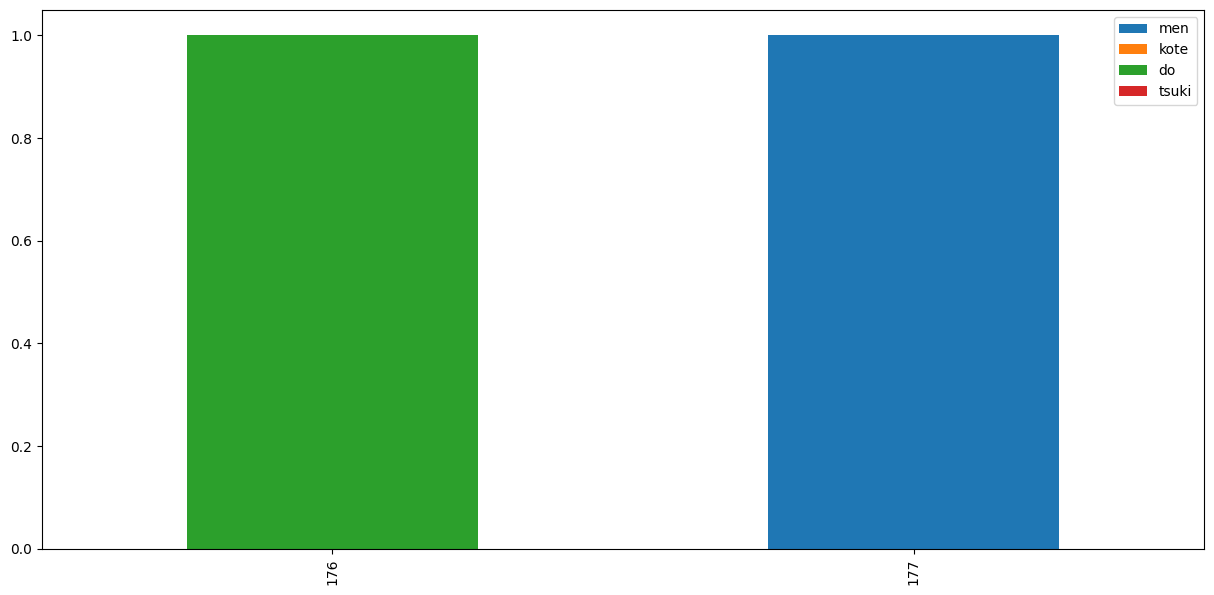

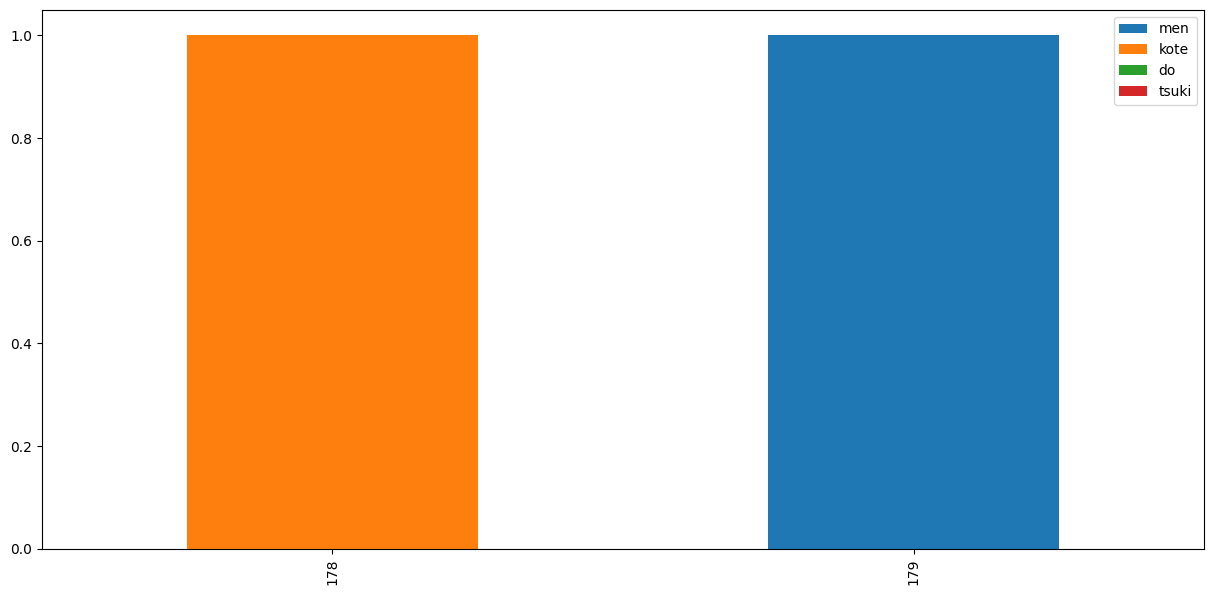

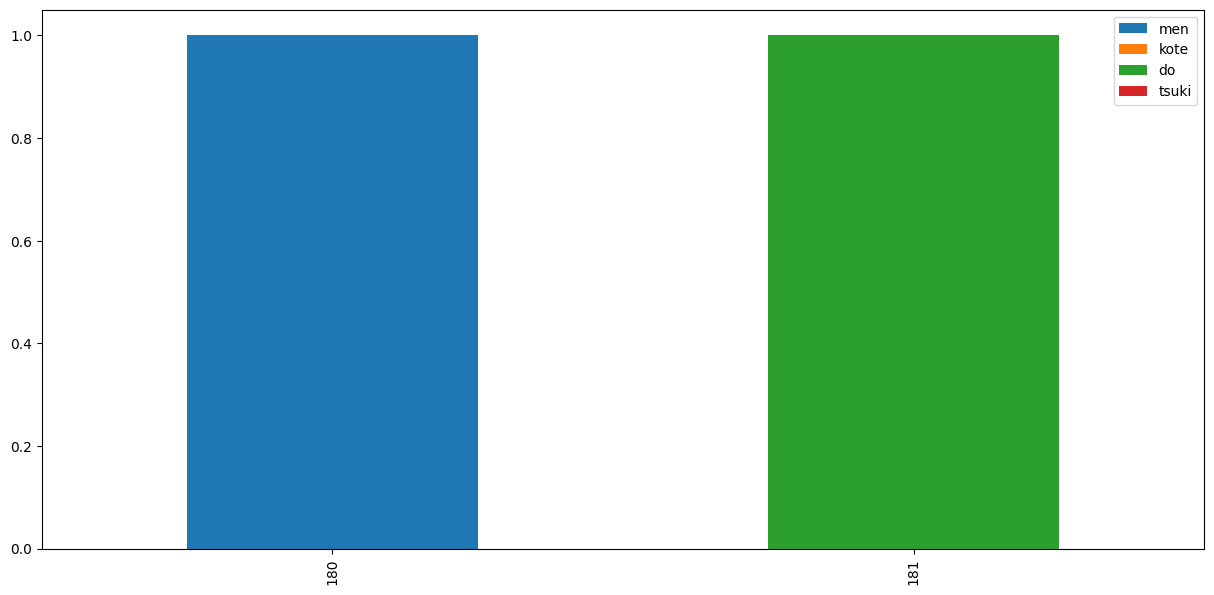

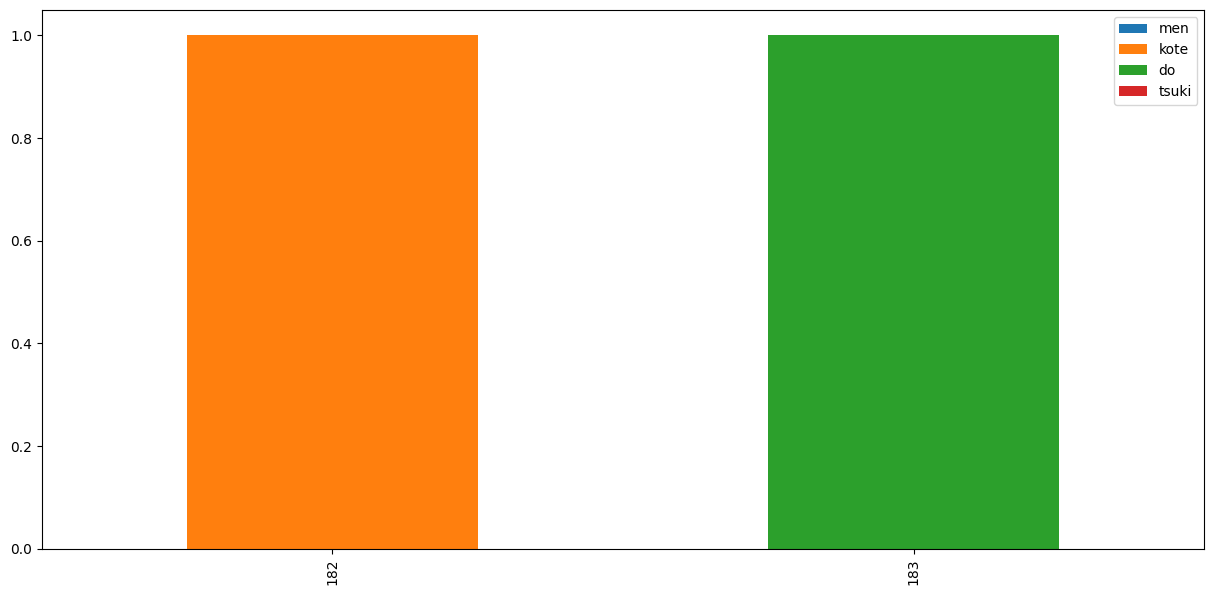

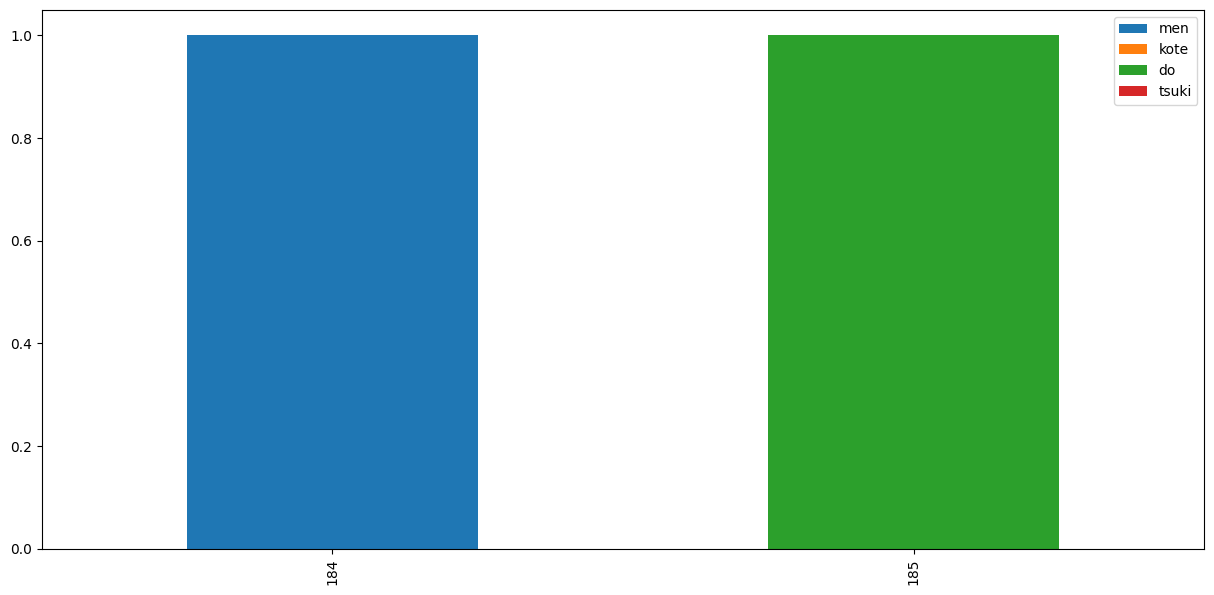

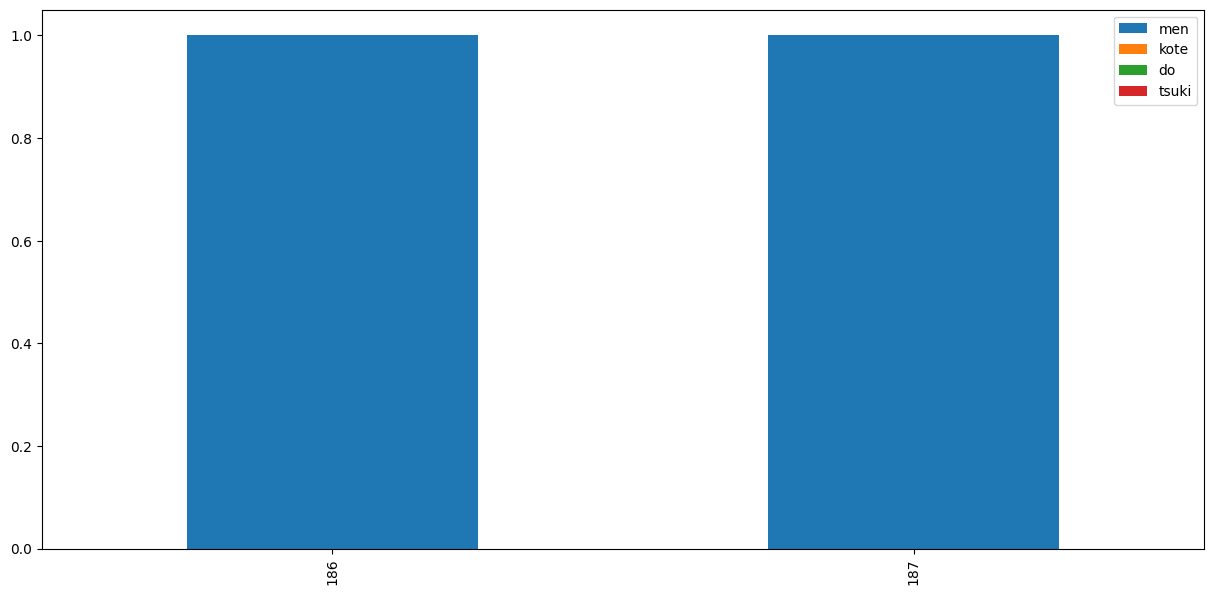

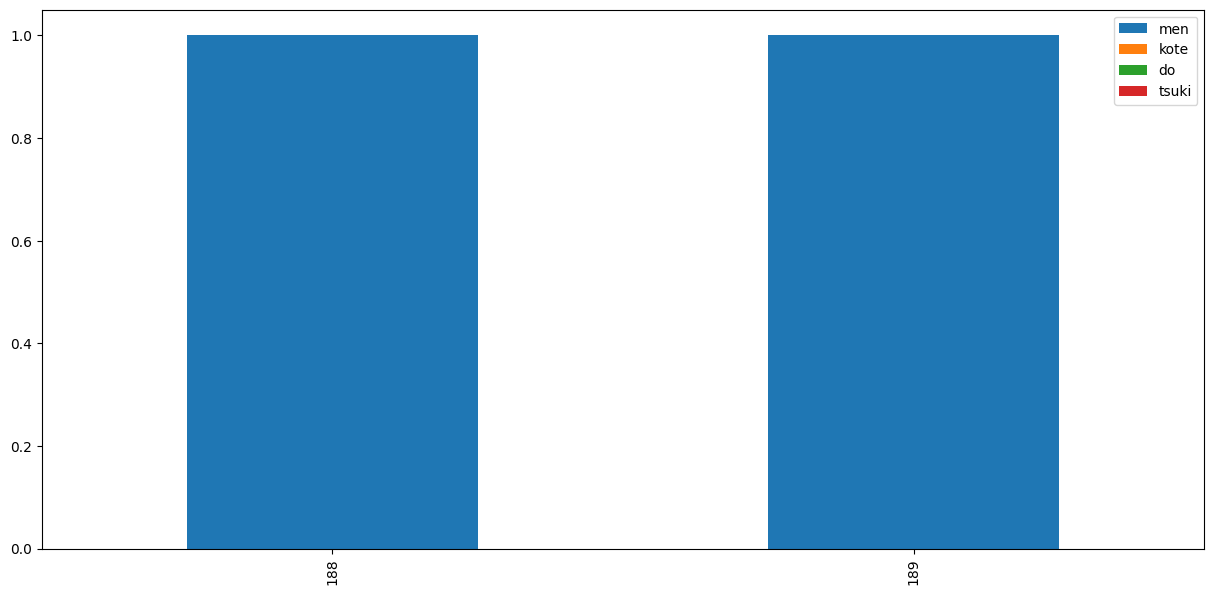

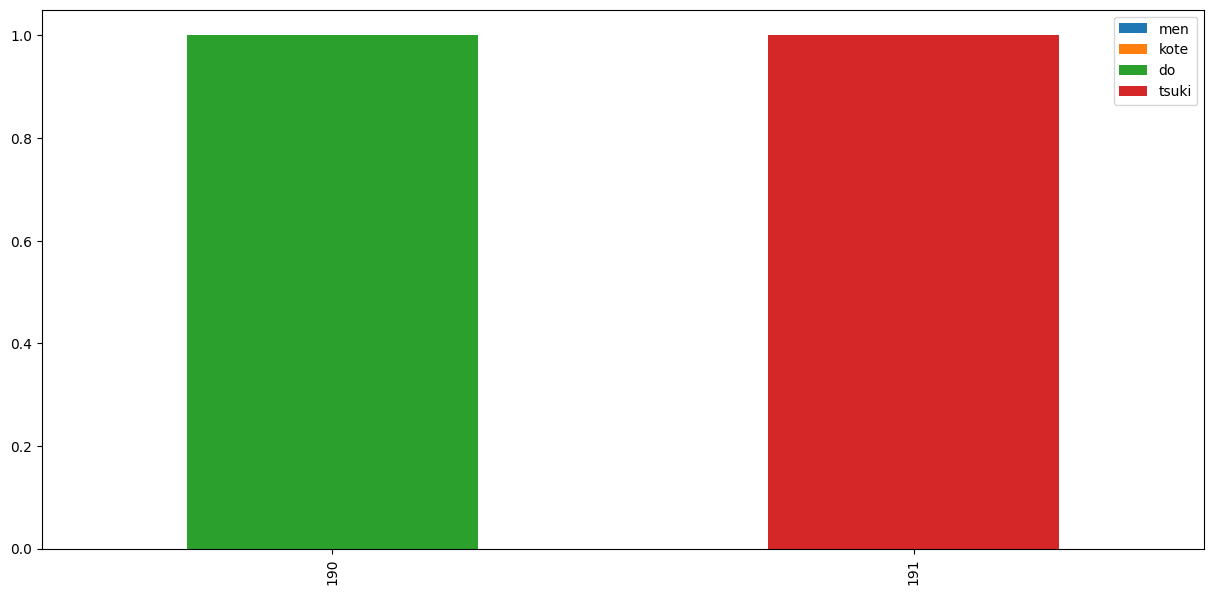

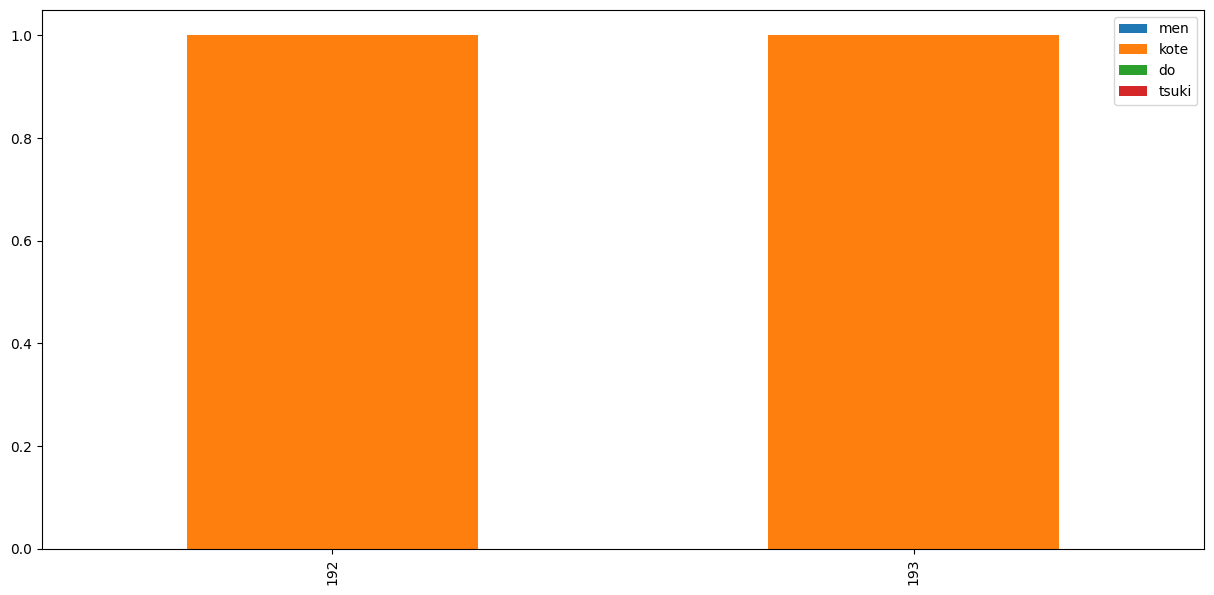

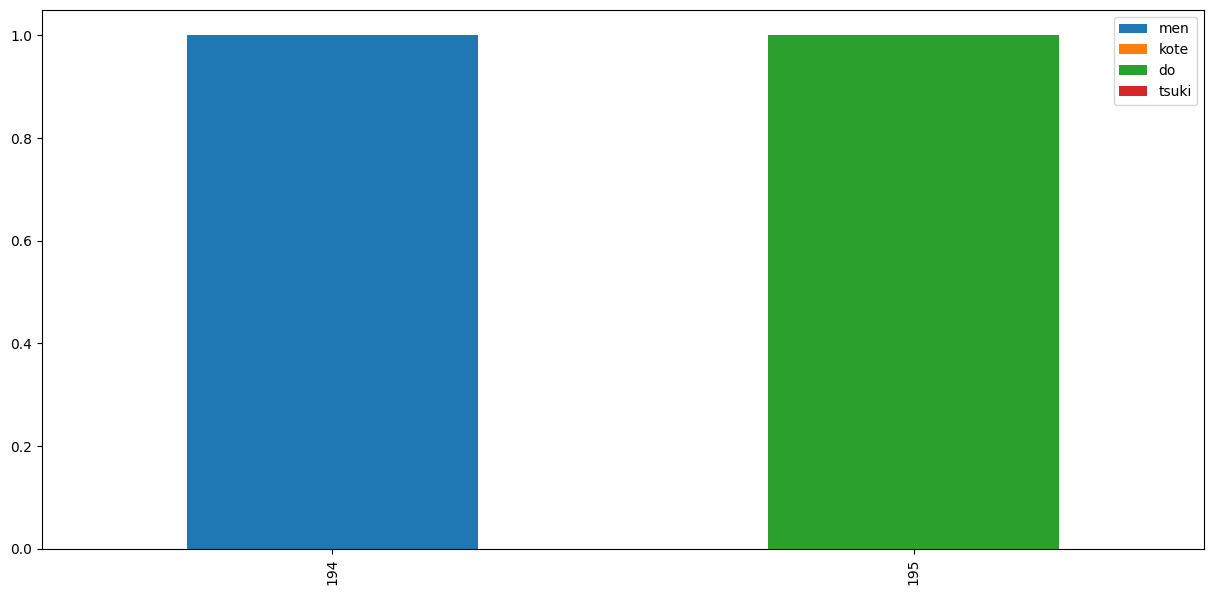

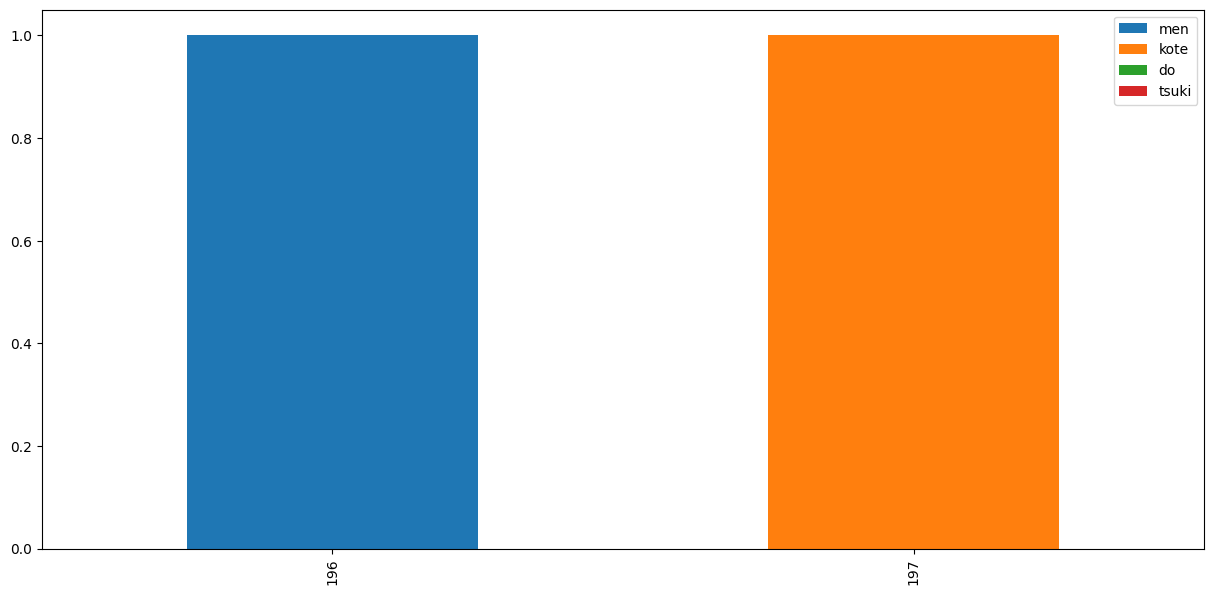

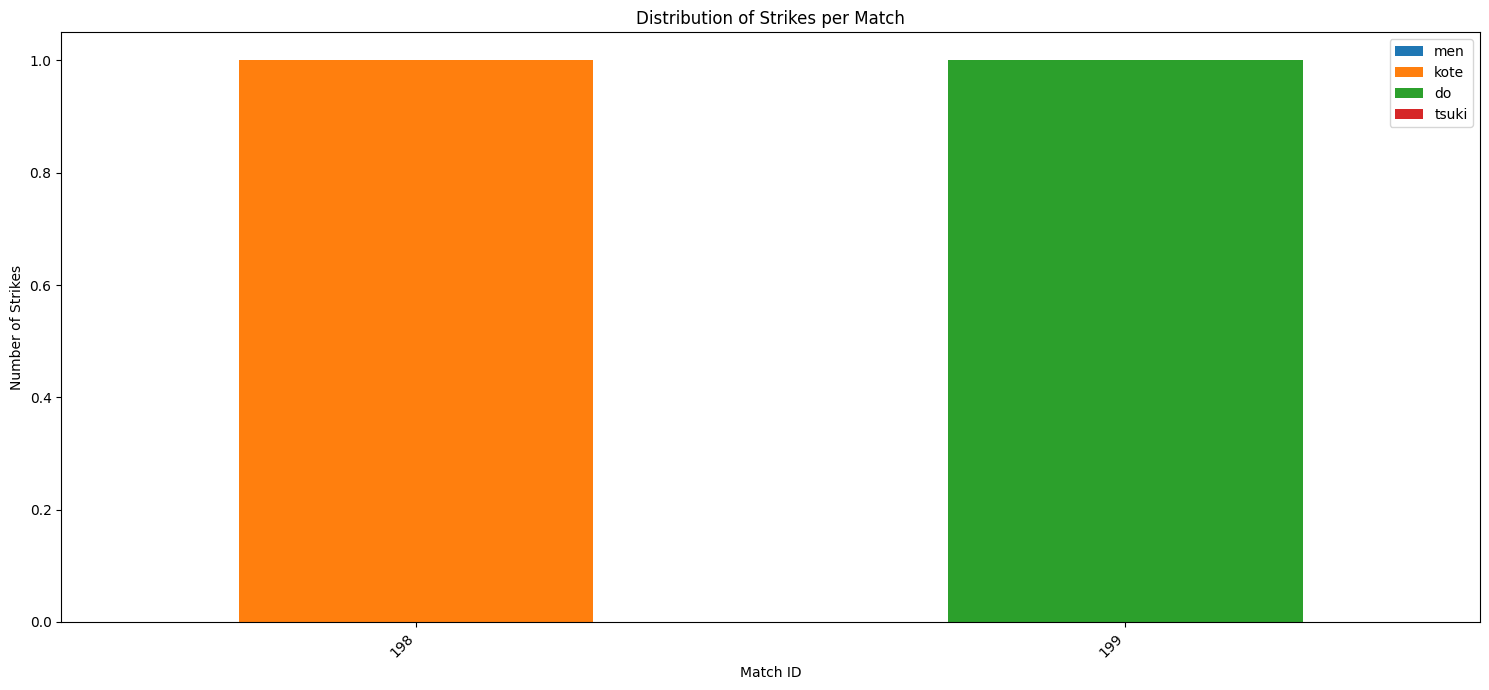

In [281]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by match_id and sum the strike counts
strike_summary = df.groupby('match_id')[['men', 'kote', 'do', 'tsuki']]

# Create a stacked bar plot
strike_summary.plot(kind='bar', stacked=True, figsize=(15, 7))

plt.title('Distribution of Strikes per Match')
plt.xlabel('Match ID')
plt.ylabel('Number of Strikes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [273]:
# Salvar CSV limpo
clean_path = "kendo_matches_TRATADOS.csv"
df.to_csv(clean_path, index=False)
print(f"\nArquivo salvo em: {clean_path}")


Arquivo salvo em: kendo_matches_TRATADOS.csv
